# Black-box optimization exercise

## Introduction

This is part of the capstone project for the Professional Certificate in Machine Learning and AI from Imperial College Business School.

The goal is the optimization of 8 black-box functions. For each of the functions 10 initial data points are given and each week I must submit a new data point to evaluate. This simulates a costly process of actual evaluation.

All variables range from 0 to 1.

This notebook will document the whole process. It is structured in a way that follows, function by function and week by week, the thought process and techniques used.

This kind of problem is the textbook example of usage of Bayesian optimization. 

In this kind of problem the most widely used surrogate function is a Gaussian process because, among other things, it already comes with uncertainty measures embedded. I will be testing our different kernels and acquisition functions depending on the case at hand. The litterature suggests applying. Automatic relevance determination (ARD) to the kernels which allows for differnet "length scale" for each dimension. (https://www.pnas.org/doi/10.1073/pnas.1912342117)

## Overview

The challenge provided a certain number of initial points for all 8 functions and then, after each submission, files containing the results a provided.

In this notebook, a dataframe called results_df contains all such results, however they are loaded progressively week by week into variables called fx_inputs and fx_outputs, so as to guarantee that progressive data acquisition can be reproduced throught this notebook. It is therefore very important that all cells are executed in order.

The main approach has been the use of Gaussian Processes as surrogate functions in a Bayesian estimate approach. Some Support Vector Machines and even Dense Neural Networks have been used to explore the classification of the space between "good" and "bad" areas. Some of the early submissions are even based on manual sampling of the unexplored space.

Week 6 marks the point when I look back on functions 4-8 and reapply whatever worked the last time an improvement was found.

Building on these insights, week 8 marked the beginning of an effort to emulate the stratified search strategies of leading NeurIPS Black Box Optimization approaches, particularly TuRBO-style adaptive trust-region methods, integrating their decaying-radius dynamics into my own experimental framework.

### Environment preparation

In [27]:
# Environment preparation, all libs imports

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# !pip install pydot
from IPython.display import Image, display
import os
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel as C, Matern
from sklearn.decomposition import PCA
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import NearestNeighbors
from scipy.optimize import minimize
from scipy.spatial.distance import cdist
from scipy.stats import qmc
from scipy.stats import norm as normal_dist
from skopt import forest_minimize
from mpl_toolkits.mplot3d import Axes3D
import scipy.stats as stats
import ast, re
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.neighbors import NearestNeighbors
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import layers, models

In [28]:
# Environment preparation, populating `results_df`, which is a dataframe with all the results known for all functions

results_df = pd.DataFrame(columns=['week', 'function', 'known_best', 'provided_input', 'output', 'submission_improved'])

# Load initial values
for X in range(1, 9):
    inputs_path = f"initial_data/function_{X}/initial_inputs.npy"
    outputs_path = f"initial_data/function_{X}/initial_outputs.npy"
    
    globals()[f"f{X}_inputs"] = np.load(inputs_path)
    globals()[f"f{X}_outputs"] = np.load(outputs_path)

    results_df.loc[len(results_df)] = [0, X, np.max(globals()[f"f{X}_outputs"]), globals()[f"f{X}_inputs"][np.argmax(globals()[f"f{X}_outputs"])], np.nan, False]

# Load results dataframe with each weeks inputs and outputs
#for X in range(1,3):
inputs_path = f"submissions/w5_inputs.txt"
outputs_path = f"submissions/w5_outputs.txt"

#Inputs
with open(inputs_path, 'r') as file:
    content = file.read()

# Split out the separate sets
raw_sets = re.split(r'\]\s*\[', content.strip())
raw_sets = [s.strip('[]') for s in raw_sets]

# Parse each set into lists of numpy arrays
all_sets = []
for s in raw_sets:
    arrays_raw = re.findall(r'array\((.*?)\)', s, re.DOTALL)
    instance_set = [np.array(eval(a)) for a in arrays_raw]
    all_sets.append(instance_set)

# Transpose structure: arrays[i] has i-th array of each set
max_len = max(len(s) for s in all_sets)
arrays = []
for i in range(max_len):
    group = []
    for n, s in enumerate(all_sets, start=1):
        if i < len(s):
            #week number, function, best_output, provided_input, output, submission_improved
            results_df.loc[len(results_df)] = [n, i+1, np.nan, s[i], np.nan, False]
    
#Outputs
with open(outputs_path, 'r') as file:
    for line_number, line in enumerate(file, start=1):
        content = line.strip()

        # Replace 'np.float64(' and ')' so the string only has floats, then use ast.literal_eval for safety
        content_clean = content.replace('np.float64(', '').replace(')', '')
        float_list = ast.literal_eval(f'[{content_clean}]')

        outputs = np.array(float_list, dtype=np.float64)

        # for each function
        for i in range(0,8):
            #Determine if the submission if best than the known best previous week (hence the -1)
            row = results_df[(results_df['week'] == line_number-1) & (results_df['function'] == i+1)]
            known_best = row['known_best'].values[0]
        
            improved = (outputs[0,i] > known_best)
            if improved:
                known_best = outputs[0,i]
            # populate the dataframe
            condition = (results_df['week'] == line_number) & (results_df['function'] == i+1)
            results_df.loc[condition, 'submission_improved'] = improved
            results_df.loc[condition, 'known_best'] = known_best
            results_df.loc[condition, 'output'] = outputs[0,i]

In [29]:
# Environment preparation, definition of some common functions

## todo

### Observation of weekly results

In [30]:
results_df.sort_values(by=['function', 'week'])

results_df[results_df['week'] == 1]

,week,function,known_best,provided_input,output,submission_improved
8,1,1,7.710875e-16,"[0.373737, 0.232323]",-3.425816e-28,False
13,1,2,6.112052e-01,"[0.818182, 0.979798]",1.117392e-01,False
18,1,3,-3.483531e-02,"[0.172414, 0.206897, 0.206897]",-1.475633e-01,False
23,1,4,-5.117018e-02,"[0.448276, 0.413793, 0.37931, 0.37931]",-5.117018e-02,True
28,1,5,1.687380e+03,"[0.586207, 0.62069, 1.0, 0.931034]",1.687380e+03,True
33,1,6,-7.142649e-01,"[0.0, 0.655172, 0.103448, 0.931034, 0.275862]",-1.529715e+00,False
38,1,7,1.367086e+00,"[0.014182, 0.276863, 0.738085, 0.05311, 0.3758...",1.367086e+00,True
43,1,8,9.905913e+00,"[0.053588, 0.199773, 0.0651, 0.022307, 0.89028...",9.905913e+00,True


In [31]:
results_df[results_df['week'] == 2]

,week,function,known_best,provided_input,output,submission_improved
9,2,1,7.710875e-16,"[0.989899, 0.767677]",-3.043130e-105,False
14,2,2,6.112052e-01,"[0.707071, 0.10101]",5.755701e-01,False
19,2,3,-3.483531e-02,"[0.862069, 0.137931, 0.655172]",-1.405773e-01,False
24,2,4,6.230694e-01,"[0.413793, 0.413793, 0.344828, 0.413793]",6.230694e-01,True
29,2,5,1.687380e+03,"[0.894898, 0.105102, 0.894898, 0.894898]",1.488865e+03,False
34,2,6,-4.072034e-01,"[0.517241, 0.310345, 0.517241, 0.862069, 0.103...",-4.072034e-01,True
39,2,7,1.599912e+00,"[0.016974, 0.324003, 0.154628, 0.172541, 0.388...",1.599912e+00,True
44,2,8,9.908052e+00,"[0.076967, 0.216041, 0.229342, 0.023042, 0.977...",9.908052e+00,True


In [32]:
results_df[results_df['week'] == 3]


,week,function,known_best,provided_input,output,submission_improved
10,3,1,7.710875e-16,"[0.818182, 0.979798]",8.656108e-113,False
15,3,2,6.669888e-01,"[0.693605, 0.805808]",6.669888e-01,True
20,3,3,-3.483531e-02,"[0.507468, 0.006386, 0.305268]",-1.296685e-01,False
25,3,4,6.230694e-01,"[0.471861, 0.446201, 0.136768, 0.434511]",-5.280037e+00,False
30,3,5,1.687380e+03,"[0.45264, 0.433354, 0.202919, 0.441704]",8.665691e+01,False
35,3,6,-4.072034e-01,"[0.493775, 0.266439, 0.665329, 1.0, 0.266425]",-6.037058e-01,False
40,3,7,1.599912e+00,"[0.015145, 0.20482, 0.115783, 0.977408, 0.4150...",1.575459e-02,False
45,3,8,9.938326e+00,"[0.054303, 0.023167, 0.046826, 0.146788, 0.981...",9.938326e+00,True


In [33]:
results_df[results_df['week'] == 4]

,week,function,known_best,provided_input,output,submission_improved
11,4,1,7.710875e-16,"[0.871653, 0.585572]",1.250482e-43,False
16,4,2,6.669888e-01,"[0.688772, 0.849196]",5.631154e-01,False
21,4,3,-1.494250e-03,"[0.589937, 0.603952, 0.435945]",-1.494250e-03,True
26,4,4,6.230694e-01,"[0.571931, 1.0, 1.0, 0.0]",-3.676854e+01,False
31,4,5,1.687380e+03,"[0.0177, 0.472569, 0.49207, 0.597183]",3.713125e+01,False
36,4,6,-4.072034e-01,"[0.48231, 0.418871, 0.20131, 0.981559, 0.0]",-9.820758e-01,False
41,4,7,1.599912e+00,"[0.036332, 0.920708, 0.509829, 0.218803, 0.361...",2.969508e-01,False
46,4,8,9.938326e+00,"[0.229166, 0.133413, 0.151014, 0.018894, 0.960...",9.919728e+00,False


In [34]:
results_df[results_df['week'] == 5]

,week,function,known_best,provided_input,output,submission_improved
12,5,1,2.675288e-09,"[0.5, 0.5]",2.675288e-09,True
17,5,2,6.669888e-01,"[0.696738, 0.300878]",6.459308e-01,False
22,5,3,-1.494250e-03,"[0.593114, 0.448446, 0.293211]",-7.525400e-02,False
27,5,4,6.230694e-01,"[0.305616, 0.434746, 0.456803, 0.473341]",-1.981731e+00,False
32,5,5,3.997541e+03,"[1.0, 0.0, 1.0, 0.965517]",3.997541e+03,True
37,5,6,-4.072034e-01,"[0.241379, 0.310345, 0.689655, 0.931034, 0.103...",-4.698626e-01,False
42,5,7,1.599912e+00,"[0.020515, 0.735827, 0.008273, 0.047345, 0.254...",1.525320e-01,False
47,5,8,9.938326e+00,"[0.066684, 0.029599, 0.012412, 0.855233, 0.692...",8.764698e+00,False


## Function 1

This function is a function with a 1D output and a 2D input. 

This is the description of the function: Detect likely contamination sources in a two-dimensional area, such as a radiation field, where only proximity yields a non-zero reading. The system uses Bayesian optimisation to tune detection parameters and reliably identify both strong and weak sources.

### Week 1

This is a 2D function, so we can start by plotting the known datapoints

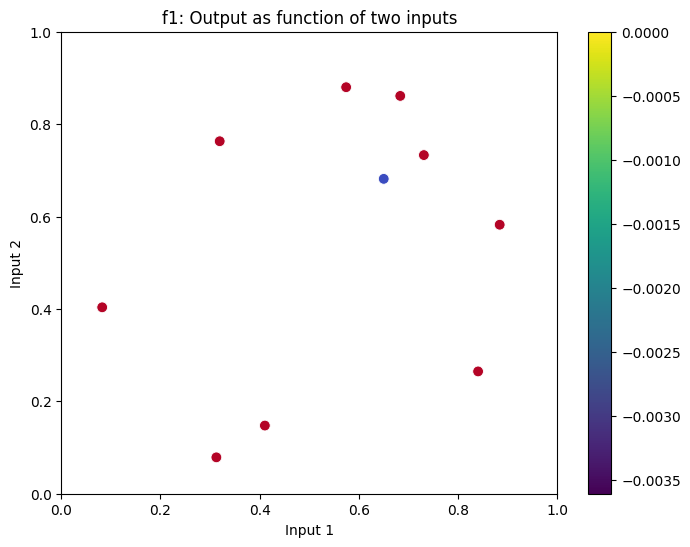

Evaluations: 10
Inputs shape: (10, 2)
Inputs range: [0.0787, 0.8839]
Performance range: [-3.6061e-03, 7.7109e-16]
Current best: 7.7109e-16
Inputs producing current best: [0.73102363 0.73299988]


In [35]:
x1 = f1_inputs[:, 0]
x2 = f1_inputs[:, 1]
y = f1_outputs

# Put data into a DataFrame
df = pd.DataFrame({
    "x1": x1,
    "x2": x2,
    "y": y
})

# Scatter plot with color encoding the output
plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x="x1", y="x2", hue="y", palette="coolwarm", s=60, legend=False)
plt.title("f1: Output as function of two inputs")
plt.xlabel("Input 1")
plt.ylabel("Input 2")
plt.xlim(0, 1)
plt.ylim(0, 1)
norm = plt.Normalize(vmin=y.min(), vmax=y.max())
sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
plt.colorbar(sm, ax=plt.gca())
plt.show()


print(f"Evaluations: {len(f1_inputs)}")
print(f"Inputs shape: {f1_inputs.shape}")
print(f"Inputs range: [{np.min(f1_inputs):.4f}, {np.max(f1_inputs):.4f}]")
print(f"Performance range: [{np.min(f1_outputs):.4e}, {np.max(f1_outputs):.4e}]")
print(f"Current best: {np.max(f1_outputs):.4e}")
print(f"Inputs producing current best: {f1_inputs[np.argmax(f1_outputs)]}")

Most values are rather on the lower end, which is normal because radiation will be low outside the contaminated area. Peaks are expected to be localized.

We can try a Matern kernel in a Gaussian process regressor to consider that data is not smooth, with a smart selection of nu. If nu tends to infinity, then this behaves as a RBF kernel (reference: https://andrewcharlesjones.github.io/journal/matern-kernels.html). We will initially try with a nu of 1.5

c:\ml\.venv\Lib\site-packages\sklearn\gaussian_process\kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\ml\.venv\Lib\site-packages\sklearn\gaussian_process\kernels.py:440: ConvergenceWarning: The optimal value found for dimension 1 of parameter length_scale is close to the specified lower bound 0.05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


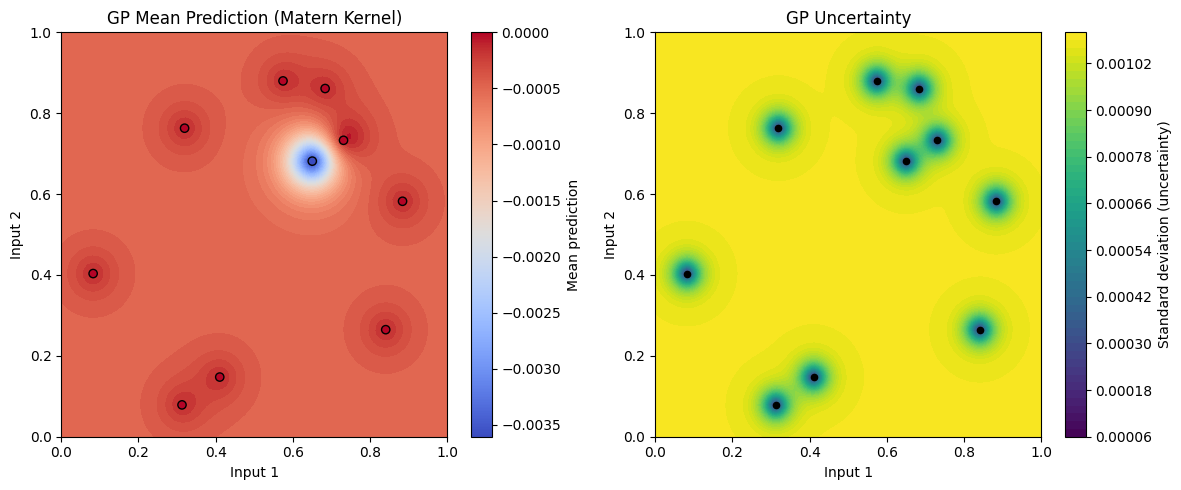

In [36]:
kernel = Matern(length_scale=[0.1, 0.1], length_scale_bounds=(0.05, 0.5), nu=1.5)
gp = GaussianProcessRegressor(
    kernel=kernel,
    n_restarts_optimizer=20,
    alpha=1e-6, #modelling noise     
    normalize_y=True,
    random_state=42
)
gp.fit(f1_inputs, f1_outputs)

x1 = np.linspace(0, 1, 100)
x2 = np.linspace(0, 1, 100)
X1, X2 = np.meshgrid(x1, x2)
X_grid = np.column_stack([X1.ravel(), X2.ravel()])

y_mean, y_std = gp.predict(X_grid, return_std=True)
Y_mean = y_mean.reshape(X1.shape)
Y_std = y_std.reshape(X1.shape)

# Plot mean
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.contourf(X1, X2, Y_mean, cmap='coolwarm', levels=50)
plt.scatter(f1_inputs[:,0], f1_inputs[:,1], c=f1_outputs, cmap='coolwarm', edgecolor='k')
plt.colorbar(label='Mean prediction')
plt.title("GP Mean Prediction (Matern Kernel)")
plt.xlabel("Input 1")
plt.ylabel("Input 2")

# Plot uncertainty
plt.subplot(1,2,2)
plt.contourf(X1, X2, Y_std, cmap='viridis', levels=50)
plt.colorbar(label='Standard deviation (uncertainty)')
plt.scatter(f1_inputs[:,0], f1_inputs[:,1], c='k', s=20)
plt.title("GP Uncertainty")
plt.xlabel("Input 1")
plt.ylabel("Input 2")

plt.tight_layout()
plt.show()

I am getting warnings about the optimal values being to close to the bounds provided, so let's try again with new values.

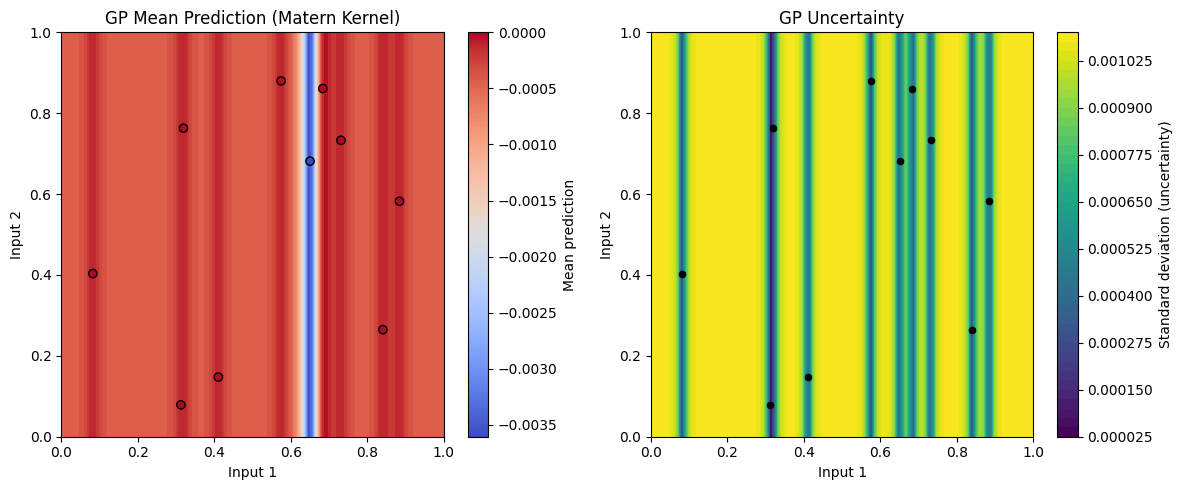

In [37]:

kernel = Matern(length_scale=[0.1, 0.1], length_scale_bounds=(1e-2, 1e5), nu=1.5)
gp = GaussianProcessRegressor(
    kernel=kernel,
    n_restarts_optimizer=20,
    alpha=1e-6, #modelling noise     
    normalize_y=True,
    random_state=42
)
gp.fit(f1_inputs, f1_outputs)

x1 = np.linspace(0, 1, 100)
x2 = np.linspace(0, 1, 100)
X1, X2 = np.meshgrid(x1, x2)
X_grid = np.column_stack([X1.ravel(), X2.ravel()])

y_mean, y_std = gp.predict(X_grid, return_std=True)
Y_mean = y_mean.reshape(X1.shape)
Y_std = y_std.reshape(X1.shape)

# Plot mean
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.contourf(X1, X2, Y_mean, cmap='coolwarm', levels=50)
plt.scatter(f1_inputs[:,0], f1_inputs[:,1], c=f1_outputs, cmap='coolwarm', edgecolor='k')
plt.colorbar(label='Mean prediction')
plt.title("GP Mean Prediction (Matern Kernel)")
plt.xlabel("Input 1")
plt.ylabel("Input 2")

# Plot uncertainty
plt.subplot(1,2,2)
plt.contourf(X1, X2, Y_std, cmap='viridis', levels=50)
plt.colorbar(label='Standard deviation (uncertainty)')
plt.scatter(f1_inputs[:,0], f1_inputs[:,1], c='k', s=20)
plt.title("GP Uncertainty")
plt.xlabel("Input 1")
plt.ylabel("Input 2")

plt.tight_layout()
plt.show()

As this is a problem that must encourage exploration, let's use a UCB acquisition function, with a choice of k = 3.

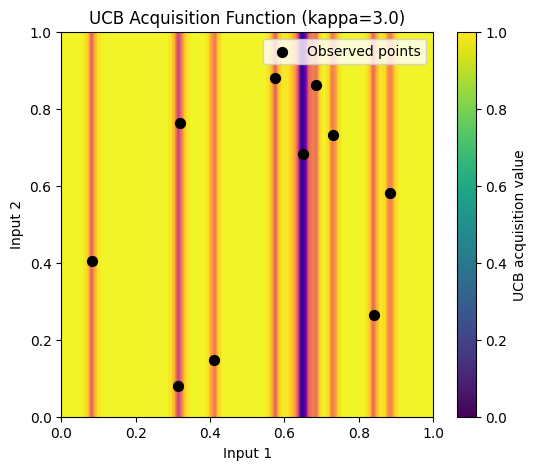

In [38]:
kappa = 3.0
UCB = Y_mean + kappa * Y_std  # shape = (grid_size, grid_size)

plt.figure(figsize=(6,5))
plt.contourf(X1, X2, UCB, cmap='plasma', levels=50)
plt.scatter(f1_inputs[:,0], f1_inputs[:,1], c='k', s=50, label='Observed points')
plt.colorbar(label='UCB acquisition value')
plt.title(f"UCB Acquisition Function (kappa={kappa})")
plt.xlabel("Input 1")
plt.ylabel("Input 2")
plt.legend()
plt.show()

In [39]:
max_idx = np.argmax(UCB)  # index of the maximum UCB
next_point = X_grid[max_idx]  # coordinates in input space

print(f"Current best: {np.max(f1_outputs):.4e}")
print(f"Inputs producing current best: {f1_inputs[np.argmax(f1_outputs)]}")
print("Next point to sample based on UCB:", next_point)
print("-".join(f"{x:.6f}" for x in next_point.flatten()))

# With the other bounds the suggested submission was 0.78787879 0.7979798

Current best: 7.7109e-16
Inputs producing current best: [0.73102363 0.73299988]
Next point to sample based on UCB: [0.37373737 0.23232323]
0.373737-0.232323


Submission for week 1: 0.373737-0.232323

### Week 2

In [40]:
#Load points to inputs and outputs from previous week
function = 1
week = 1 #previous

row = results_df[(results_df['week'] == week) & (results_df['function'] == function)]
f1_inputs = np.vstack([f1_inputs, row['provided_input'].values[0]])
f1_outputs = np.append(f1_outputs, row['output'].values[0])

improved = row['submission_improved'].values[0]
print(f"Submission from last week improved something? {improved}")
print(f"Current best: {np.max(f1_outputs):.4e}")
print(f"Last week's results: {row['output'].values[0]:.4e}")


Submission from last week improved something? False
Current best: 7.7109e-16
Last week's results: -3.4258e-28


Let's try the same thing but adjusting the surrogate function so that the importance is given to both parameters. UCB as acquisition function favors exploration, which is what we want at this point.

c:\ml\.venv\Lib\site-packages\sklearn\gaussian_process\kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified upper bound 0.3. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


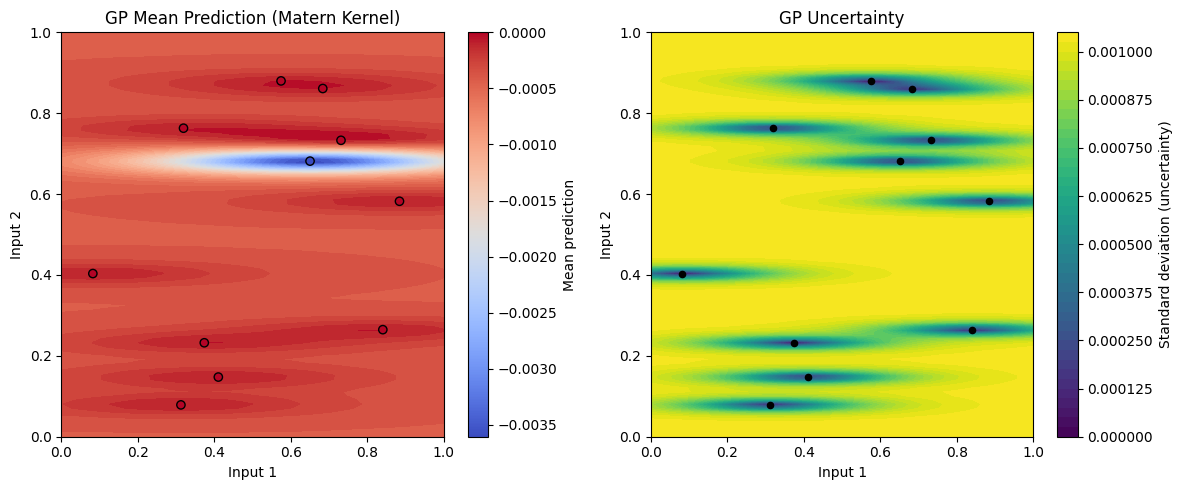

In [41]:

kernel = C(1.0, (1e-5, 1e5)) * Matern(length_scale=[0.05, 0.05], length_scale_bounds=(0.01, 0.3), nu=2.5) + WhiteKernel(noise_level=1e-8, noise_level_bounds=(1e-12, 1e2))
gp = GaussianProcessRegressor(
    kernel=kernel,
    n_restarts_optimizer=50,
    alpha=1e-6, #modelling noise     
    normalize_y=True,
    random_state=42
)
gp.fit(f1_inputs, f1_outputs)

x1 = np.linspace(0, 1, 100)
x2 = np.linspace(0, 1, 100)
X1, X2 = np.meshgrid(x1, x2)
X_grid = np.column_stack([X1.ravel(), X2.ravel()])

y_mean, y_std = gp.predict(X_grid, return_std=True)
Y_mean = y_mean.reshape(X1.shape)
Y_std = y_std.reshape(X1.shape)

# Plot mean
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.contourf(X1, X2, Y_mean, cmap='coolwarm', levels=50)
plt.scatter(f1_inputs[:,0], f1_inputs[:,1], c=f1_outputs, cmap='coolwarm', edgecolor='k')
plt.colorbar(label='Mean prediction')
plt.title("GP Mean Prediction (Matern Kernel)")
plt.xlabel("Input 1")
plt.ylabel("Input 2")

# Plot uncertainty
plt.subplot(1,2,2)
plt.contourf(X1, X2, Y_std, cmap='viridis', levels=50)
plt.colorbar(label='Standard deviation (uncertainty)')
plt.scatter(f1_inputs[:,0], f1_inputs[:,1], c='k', s=20)
plt.title("GP Uncertainty")
plt.xlabel("Input 1")
plt.ylabel("Input 2")

plt.tight_layout()
plt.show()

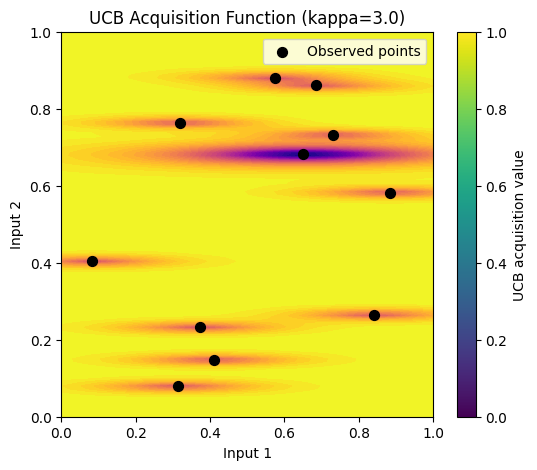

In [42]:
kappa = 3.0
UCB = Y_mean + kappa * Y_std  # shape = (grid_size, grid_size)

plt.figure(figsize=(6,5))
plt.contourf(X1, X2, UCB, cmap='plasma', levels=50)
plt.scatter(f1_inputs[:,0], f1_inputs[:,1], c='k', s=50, label='Observed points')
plt.colorbar(label='UCB acquisition value')
plt.title(f"UCB Acquisition Function (kappa={kappa})")
plt.xlabel("Input 1")
plt.ylabel("Input 2")
plt.legend()
plt.show()

In [43]:
max_idx = np.argmax(UCB)  # index of the maximum UCB
next_point = X_grid[max_idx]  # coordinates in input space

print(f"Current best: {np.max(f1_outputs):.4e}")
print(f"Inputs producing current best: {f1_inputs[np.argmax(f1_outputs)]}")
print("Next point to sample based on UCB:", next_point)
print("-".join(f"{x:.6f}" for x in next_point.flatten()))

Current best: 7.7109e-16
Inputs producing current best: [0.73102363 0.73299988]
Next point to sample based on UCB: [0.98989899 0.76767677]
0.989899-0.767677


Submission for week 2: 0.989899-0.767677

### Week 3

In [44]:
#Load points to inputs and outputs from previous week
function = 1
week = 2 #previous

row = results_df[(results_df['week'] == week) & (results_df['function'] == function)]
f1_inputs = np.vstack([f1_inputs, row['provided_input'].values[0]])
f1_outputs = np.append(f1_outputs, row['output'].values[0])

improved = row['submission_improved'].values[0]
print(f"Submission from last week improved something? {improved}")
print(f"Current best: {np.max(f1_outputs):.4e}")
print(f"Last week's results: {row['output'].values[0]:.4e}")
print('--')
print(f"Inputs shape: {f1_inputs.shape}")
print(f"Inputs range: [{np.min(f1_inputs):.4f}, {np.max(f1_inputs):.4f}]")
print(f"Performance range: [{np.min(f1_outputs):.4e}, {np.max(f1_outputs):.4e}]")

Submission from last week improved something? False
Current best: 7.7109e-16
Last week's results: -3.0431e-105
--
Inputs shape: (12, 2)
Inputs range: [0.0787, 0.9899]
Performance range: [-3.6061e-03, 7.7109e-16]


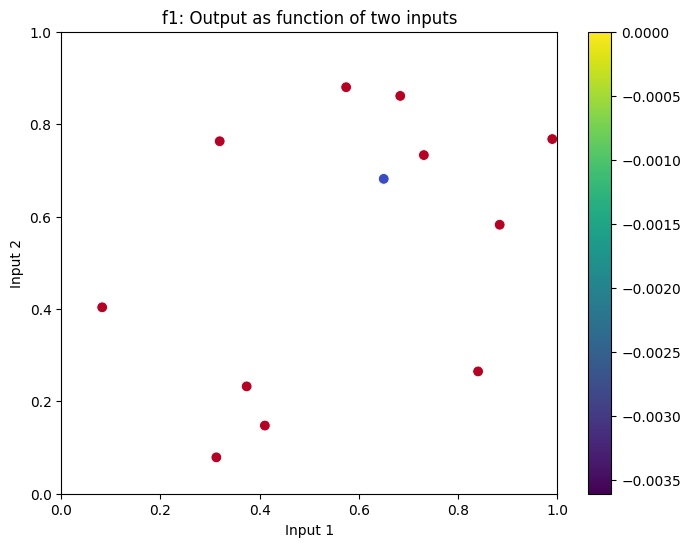

Evaluations: 12
Inputs shape: (12, 2)
Inputs range: [0.0787, 0.9899]
Performance range: [-3.6061e-03, 7.7109e-16]
Current best: 7.7109e-16
Inputs producing current best: [0.73102363 0.73299988]


In [45]:
x1 = f1_inputs[:, 0]
x2 = f1_inputs[:, 1]
y = f1_outputs

# Put data into a DataFrame
df = pd.DataFrame({
    "x1": x1,
    "x2": x2,
    "y": y
})

# Scatter plot with color encoding the output
plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x="x1", y="x2", hue="y", palette="coolwarm", s=60, legend=False)
plt.title("f1: Output as function of two inputs")
plt.xlabel("Input 1")
plt.ylabel("Input 2")
plt.xlim(0, 1)
plt.ylim(0, 1)
norm = plt.Normalize(vmin=y.min(), vmax=y.max())
sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
plt.colorbar(sm, ax=plt.gca())
plt.show()


print(f"Evaluations: {len(f1_inputs)}")
print(f"Inputs shape: {f1_inputs.shape}")
print(f"Inputs range: [{np.min(f1_inputs):.4f}, {np.max(f1_inputs):.4f}]")
print(f"Performance range: [{np.min(f1_outputs):.4e}, {np.max(f1_outputs):.4e}]")
print(f"Current best: {np.max(f1_outputs):.4e}")
print(f"Inputs producing current best: {f1_inputs[np.argmax(f1_outputs)]}")

We haven't had any improvement for this function so far. It is known that values only peak close to a contamination source. One has already been identified (blue dot above), the goal is to determine if other exist in the 2D plane.

In preparation for more complex cases, I am exploring forest_minimize from skopt which efficiently maximizes the value of the acquisition function. This will help also with high-dimensional cases. I am using a L-BFGS-B (Limited-memory Broyden–Fletcher–Goldfarb–Shanno with Bounds), which according to my limited research is optimal for bounded sets of input values.

In [68]:
# Define kernel: Matern with nu=2.5 for sharp peaks
kernel = C(1.0, (1e-3, 1e3)) * Matern(length_scale=[0.2]*2, nu=1.5)

# Instantiate GP with small noise level
gp = GaussianProcessRegressor(kernel=kernel, alpha=1e-5, normalize_y=True)

# Fit the GP model
gp.fit(f1_inputs, f1_outputs)
print(gp.kernel_)


# Function to optimize acquisition: Expected Improvement
def acquisitionf(x):
    x = np.array(x).reshape(1, -1)
    mean, std = gp.predict(x, return_std=True)
    # Current best observation
    best_y = np.max(f1_outputs)
    # Calculate EI
    z = (mean - best_y) / (std + 1e-9)
    ei = (mean - best_y) * normal_dist.cdf(z) + std * normal_dist.pdf(z)
    return -ei.item()  

# Robust acquisition maximization via multi-start local optimization
bounds = [(0, 1), (0, 1)]
num_restarts = 1500 # I have incremented this until the estimation did no longer move (fixed random seed)
results = []
np.random.seed(42)

for _ in range(num_restarts):
    x0 = np.random.uniform(0, 1, 2)
    res = minimize(acquisitionf, x0, bounds=bounds, method='L-BFGS-B')
    results.append(res)

print(f"Current best: {np.max(f1_outputs):.4e}")
print(f"Inputs producing current best: {f1_inputs[np.argmax(f1_outputs)]}")

# Select best solution from restarts
next_point = min(results, key=lambda r: r.fun).x
print("Next sample point (local optimizer):", next_point)
print("-".join(f"{x:.6f}" for x in next_point.flatten()))

1**2 * Matern(length_scale=[0.00684, 0.0127], nu=1.5)
Current best: 7.7109e-16
Inputs producing current best: [0.73102363 0.73299988]
Next sample point (local optimizer): [0.40501878 0.16214521]
0.405019-0.162145


Submission for week 3: 0.405019-0.162145

### Week 4

In [69]:
#Load points to inputs and outputs from previous week
function = 1
week = 3 #previous

row = results_df[(results_df['week'] == week) & (results_df['function'] == function)]
f1_inputs = np.vstack([f1_inputs, row['provided_input'].values[0]])
f1_outputs = np.append(f1_outputs, row['output'].values[0])

improved = row['submission_improved'].values[0]
print(f"Submission from last week improved something? {improved}")
print(f"Current best: {np.max(f1_outputs):.4e}")
print(f"Last week's results: {row['output'].values[0]:.4e}")
print('--')
print(f"Inputs shape: {f1_inputs.shape}")
print(f"Inputs range: [{np.min(f1_inputs):.4f}, {np.max(f1_inputs):.4f}]")
print(f"Performance range: [{np.min(f1_outputs):.4e}, {np.max(f1_outputs):.4e}]")

Submission from last week improved something? False
Current best: 7.7109e-16
Last week's results: 8.6561e-113
--
Inputs shape: (13, 2)
Inputs range: [0.0787, 0.9899]
Performance range: [-3.6061e-03, 7.7109e-16]


No improvement has been possible so far. The maximum value is part of the initial values.

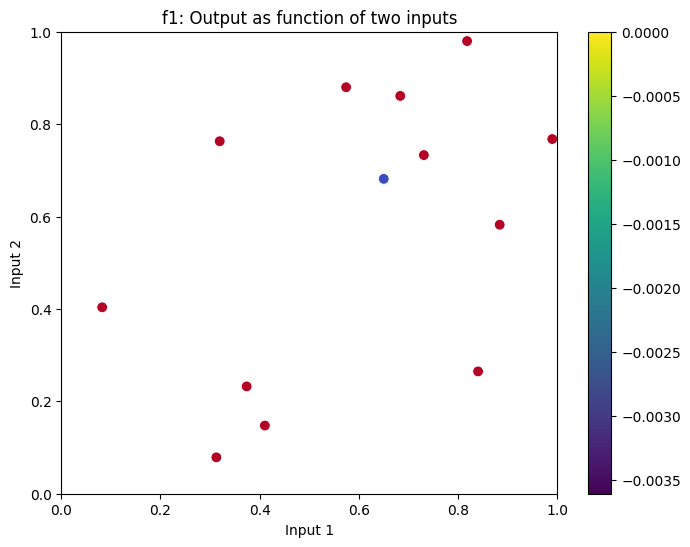

Evaluations: 13
Inputs shape: (13, 2)
Inputs range: [0.0787, 0.9899]
Performance range: [-3.6061e-03, 7.7109e-16]
Current best: 7.7109e-16
Inputs producing current best: [0.73102363 0.73299988]


In [70]:
x1 = f1_inputs[:, 0]
x2 = f1_inputs[:, 1]
y = f1_outputs

# Put data into a DataFrame
df = pd.DataFrame({
    "x1": x1,
    "x2": x2,
    "y": y
})

# Scatter plot with color encoding the output
plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x="x1", y="x2", hue="y", palette="coolwarm", s=60, legend=False)
plt.title("f1: Output as function of two inputs")
plt.xlabel("Input 1")
plt.ylabel("Input 2")
plt.xlim(0, 1)
plt.ylim(0, 1)
norm = plt.Normalize(vmin=y.min(), vmax=y.max())
sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
plt.colorbar(sm, ax=plt.gca())
plt.show()


print(f"Evaluations: {len(f1_inputs)}")
print(f"Inputs shape: {f1_inputs.shape}")
print(f"Inputs range: [{np.min(f1_inputs):.4f}, {np.max(f1_inputs):.4f}]")
print(f"Performance range: [{np.min(f1_outputs):.4e}, {np.max(f1_outputs):.4e}]")
print(f"Current best: {np.max(f1_outputs):.4e}")
print(f"Inputs producing current best: {f1_inputs[np.argmax(f1_outputs)]}")

In [71]:
# Define kernel: Matern with nu=2.5 for sharp peaks
kernel = C(1.0, (1e-3, 1e3)) * Matern(length_scale=[0.2]*2, nu=1.5)

# Instantiate GP with small noise level
gp = GaussianProcessRegressor(kernel=kernel, alpha=1e-5, normalize_y=True)

# Fit the GP model
gp.fit(f1_inputs, f1_outputs)
print(gp.kernel_)


# Function to optimize acquisition: Expected Improvement
def acquisitionf(x):
    x = np.array(x).reshape(1, -1)
    mean, std = gp.predict(x, return_std=True)
    # Current best observation
    best_y = np.max(f1_outputs)
    # Calculate EI
    z = (mean - best_y) / (std + 1e-9)
    ei = (mean - best_y) * normal_dist.cdf(z) + std * normal_dist.pdf(z)
    return -ei.item()  

# Robust acquisition maximization via multi-start local optimization
bounds = [(0, 1), (0, 1)]
num_restarts = 150 
results = []
np.random.seed(42)

for _ in range(num_restarts):
    x0 = np.random.uniform(0, 1, 2)
    res = minimize(acquisitionf, x0, bounds=bounds, method='L-BFGS-B')
    results.append(res)

print(f"Current best: {np.max(f1_outputs):.4e}")
print(f"Inputs producing current best: {f1_inputs[np.argmax(f1_outputs)]}")

# Select best solution from restarts
next_point_ei = min(results, key=lambda r: r.fun).x
print("Next sample point (ei):", next_point_ei)


def negative_ucb(x, gp, kappa):
    mu, sigma = gp.predict(x.reshape(1, -1), return_std=True)
    return -(mu[0] + kappa * sigma[0])

dims = 2
bounds = [(0, 1) for _ in range(dims)]
num_restarts = 50
results = []
np.random.seed(42)

for _ in range(num_restarts):
    x0 = np.random.uniform(0, 1, dims)
    #choosing kappa 2.7 
    result = minimize(negative_ucb, x0=np.random.uniform(0, 1, dims), 
                 args=(gp, 1.7), bounds=bounds, method='L-BFGS-B')
    if result.success:
        results.append(result)
    
# Select best solution from restarts
next_point_ucb = min(results, key=lambda r: r.fun).x
print("Next sample point (ucb):", next_point_ucb)


print("-".join(f"{x:.6f}" for x in next_point_ucb.flatten()))

1**2 * Matern(length_scale=[0.00667, 0.00999], nu=1.5)
Current best: 7.7109e-16
Inputs producing current best: [0.73102363 0.73299988]
Next sample point (ei): [0.30959297 0.09217781]
Next sample point (ucb): [0.87165265 0.58557223]
0.871653-0.585572


I choose the UCB value.

Sample for week 4: 0.871653-0.585572

### Week 5

In [72]:
#Load points to inputs and outputs from previous week
function = 1
week = 4 #previous

row = results_df[(results_df['week'] == week) & (results_df['function'] == function)]
f1_inputs = np.vstack([f1_inputs, row['provided_input'].values[0]])
f1_outputs = np.append(f1_outputs, row['output'].values[0])

improved = row['submission_improved'].values[0]
print(f"Submission from last week improved something? {improved}")
print(f"Current best: {np.max(f1_outputs):.4e}")
print(f"Last week's results: {row['output'].values[0]:.4e}")
print('--')
print(f"Inputs shape: {f1_inputs.shape}")
print(f"Inputs range: [{np.min(f1_inputs):.4f}, {np.max(f1_inputs):.4f}]")
print(f"Performance range: [{np.min(f1_outputs):.4e}, {np.max(f1_outputs):.4e}]")

Submission from last week improved something? False
Current best: 7.7109e-16
Last week's results: 1.2505e-43
--
Inputs shape: (14, 2)
Inputs range: [0.0787, 0.9899]
Performance range: [-3.6061e-03, 7.7109e-16]


Still not found a non-zero reading. The maximum is close to 0. The description of the function cleams that only proximity to a contamination source yield a non-zero reading.

This week I am choosing to sample in the middle of the square:

In [73]:
chosen_point = np.array([0.5, 0.5])
print("-".join(f"{x:.6f}" for x in chosen_point.flatten()))

0.500000-0.500000


Submissison for week 5: 0.500000-0.500000

### Week 6

In [74]:
#Load points to inputs and outputs from previous week
function = 1
week = 5 #previous

row = results_df[(results_df['week'] == week) & (results_df['function'] == function)]
f1_inputs = np.vstack([f1_inputs, row['provided_input'].values[0]])
f1_outputs = np.append(f1_outputs, row['output'].values[0])

improved = row['submission_improved'].values[0]
print(f"Submission from last week improved something? {improved}")
print(f"Current best: {np.max(f1_outputs):.4e}")
print(f"Last week's results: {row['output'].values[0]:.4e}")
print('--')
print(f"Inputs shape: {f1_inputs.shape}")
print(f"Inputs range: [{np.min(f1_inputs):.4f}, {np.max(f1_inputs):.4f}]")
print(f"Performance range: [{np.min(f1_outputs):.4e}, {np.max(f1_outputs):.4e}]")

Submission from last week improved something? True
Current best: 2.6753e-09
Last week's results: 2.6753e-09
--
Inputs shape: (15, 2)
Inputs range: [0.0787, 0.9899]
Performance range: [-3.6061e-03, 2.6753e-09]


Sampling the middle has yielded the best value so far, slightly positive. 

C:\Users\Eduardo\AppData\Local\Temp\ipykernel_15200\1995708060.py:3: RuntimeWarning: invalid value encountered in log
  y = np.log(f1_outputs)


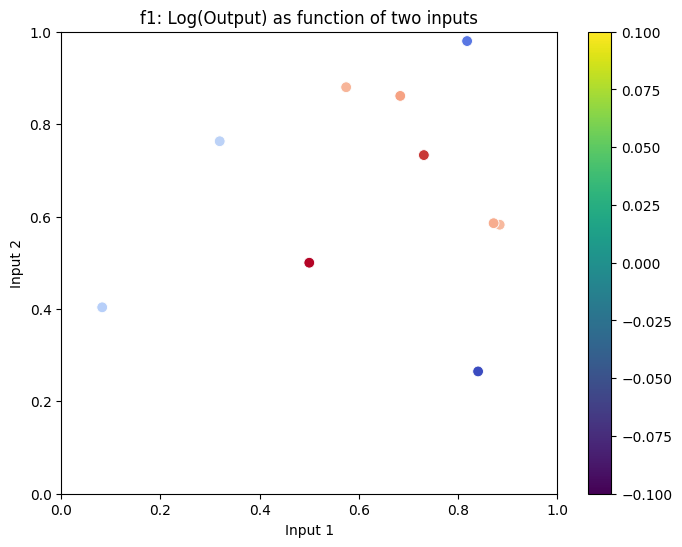

Evaluations: 15
Inputs shape: (15, 2)
Inputs range: [0.0787, 0.9899]
Performance range: [-3.6061e-03, 2.6753e-09]
Current best: 2.6753e-09
Inputs producing current best: [0.5 0.5]


In [75]:
x1 = f1_inputs[:, 0]
x2 = f1_inputs[:, 1]
y = np.log(f1_outputs)

# Put data into a DataFrame
df = pd.DataFrame({
    "x1": x1,
    "x2": x2,
    "y": y
})

# Scatter plot with color encoding the output
plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x="x1", y="x2", hue="y", palette="coolwarm", s=60, legend=False)
plt.title("f1: Log(Output) as function of two inputs")
plt.xlabel("Input 1")
plt.ylabel("Input 2")
plt.xlim(0, 1)
plt.ylim(0, 1)
norm = plt.Normalize(vmin=y.min(), vmax=y.max())
sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
plt.colorbar(sm, ax=plt.gca())
plt.show()


print(f"Evaluations: {len(f1_inputs)}")
print(f"Inputs shape: {f1_inputs.shape}")
print(f"Inputs range: [{np.min(f1_inputs):.4f}, {np.max(f1_inputs):.4f}]")
print(f"Performance range: [{np.min(f1_outputs):.4e}, {np.max(f1_outputs):.4e}]")
print(f"Current best: {np.max(f1_outputs):.4e}")
print(f"Inputs producing current best: {f1_inputs[np.argmax(f1_outputs)]}")

I am once again sampling a point with little information selected manually so that I can use those to better approximate the underlying function.

In [76]:
chosen_point = np.array([0.3, 0.2])
print("-".join(f"{x:.6f}" for x in chosen_point.flatten()))

0.300000-0.200000


Submission for week 6: 0.300000-0.200000

### Week 7

In [77]:
#Load points to inputs and outputs from previous week
function = 1
week = 6 #previous

row = results_df[(results_df['week'] == week) & (results_df['function'] == function)]
f1_inputs = np.vstack([f1_inputs, row['provided_input'].values[0]])
f1_outputs = np.append(f1_outputs, row['output'].values[0])

improved = row['submission_improved'].values[0]
print(f"Submission from last week improved something? {improved}")
print(f"Current best: {np.max(f1_outputs):.4e}")
print(f"Last week's results: {row['output'].values[0]:.4e}")
print('--')
print(f"Inputs shape: {f1_inputs.shape}")
print(f"Inputs range: [{np.min(f1_inputs):.4f}, {np.max(f1_inputs):.4f}]")
print(f"Performance range: [{np.min(f1_outputs):.4e}, {np.max(f1_outputs):.4e}]")

IndexError: index 0 is out of bounds for axis 0 with size 0

This week I am choosing to use another Gaussian process with an UCB aquisition function, but I am going to approximate log(y) instead of y.

In [ ]:
# code...

## Function 2

This function is a function with a 1D output and a 2D input. 

This is the description of the function: Imagine a black box, or a mystery ML model, that takes two numbers as input and returns a log-likelihood score. Your goal is to maximise that score, but each output is noisy, and depending on where you start, you might get stuck in a local optimum. 

To tackle this, you use Bayesian optimisation, which selects the next inputs based on what it has learned so far. It balances exploration with exploitation, making it well suited to noisy outputs and complex functions with many local peaks.

### Week 1

This is a 2D function, so we can start by plotting the known datapoints

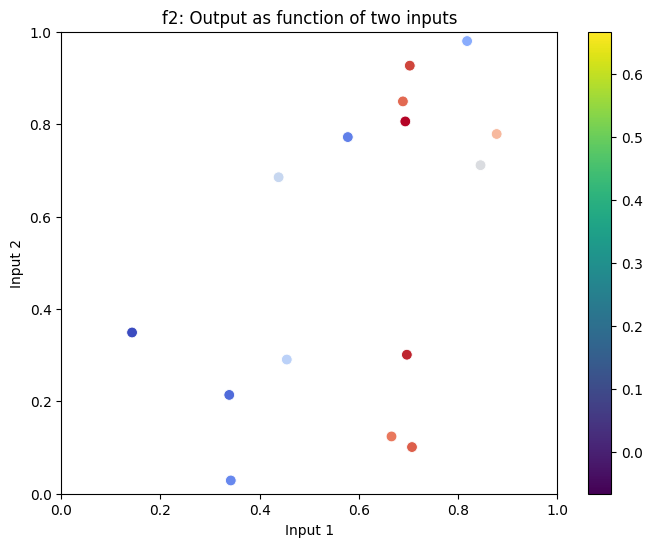

Evaluations: 15
Inputs shape: (15, 2)
Inputs range: [0.0287, 0.9798]
Performance range: [-0.0656, 0.6670]
Current best: 0.6670
Inputs producing current best: [0.693605 0.805808]


In [78]:
x1 = f2_inputs[:, 0]
x2 = f2_inputs[:, 1]
y = f2_outputs

# Put data into a DataFrame
df = pd.DataFrame({
    "x1": x1,
    "x2": x2,
    "y": y
})

# Scatter plot with color encoding the output
plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x="x1", y="x2", hue="y", palette="coolwarm", s=60, legend=False)
plt.title("f2: Output as function of two inputs")
plt.xlabel("Input 1")
plt.ylabel("Input 2")
plt.xlim(0, 1)
plt.ylim(0, 1)
norm = plt.Normalize(vmin=y.min(), vmax=y.max())
sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
plt.colorbar(sm, ax=plt.gca())
plt.show()


print(f"Evaluations: {len(f2_inputs)}")
print(f"Inputs shape: {f2_inputs.shape}")
print(f"Inputs range: [{np.min(f2_inputs):.4f}, {np.max(f2_inputs):.4f}]")
print(f"Performance range: [{np.min(f2_outputs):.4f}, {np.max(f2_outputs):.4f}]")
print(f"Current best: {np.max(f2_outputs):.4f}")
print(f"Inputs producing current best: {f2_inputs[np.argmax(f2_outputs)]}")



Data is noisy.

We can try a RBF kernel combined with a WhiteKernel for noise in a Gaussian process regressor to consider that data is smooth as expected in a log likelihood.

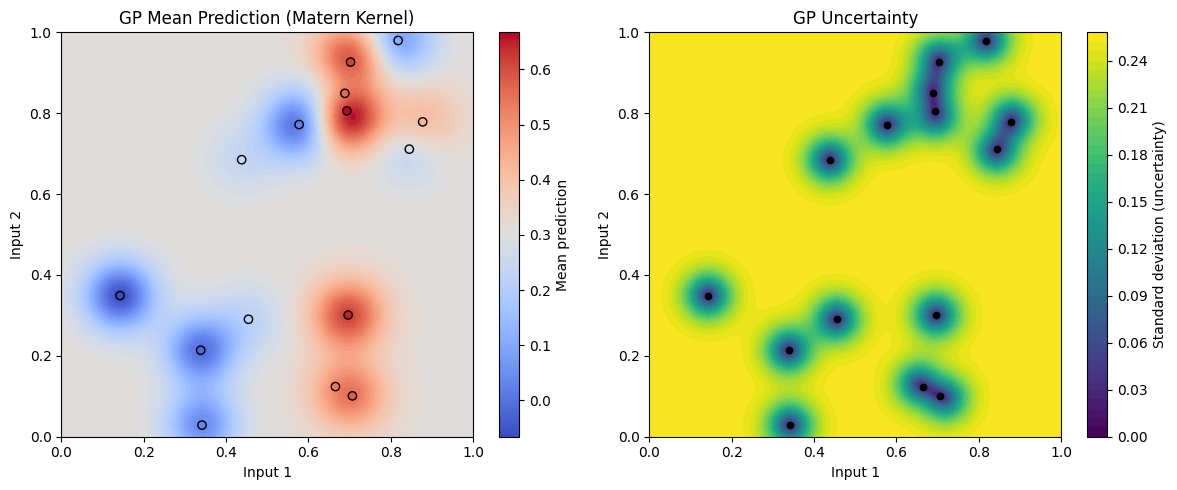

In [79]:
kernel = RBF(length_scale=0.2, length_scale_bounds=(1e-10,1)) + WhiteKernel(noise_level=1e-9, noise_level_bounds=(1e-12, 1e-3))
gp = GaussianProcessRegressor(
    kernel=kernel,
    n_restarts_optimizer=20,
    alpha=1e-8, #modelling noise     
    normalize_y=True,
    random_state=42
)
gp.fit(f2_inputs, f2_outputs)

x1 = np.linspace(0, 1, 100)
x2 = np.linspace(0, 1, 100)
X1, X2 = np.meshgrid(x1, x2)
X_grid = np.column_stack([X1.ravel(), X2.ravel()])

y_mean, y_std = gp.predict(X_grid, return_std=True)
Y_mean = y_mean.reshape(X1.shape)
Y_std = y_std.reshape(X1.shape)

# Plot mean
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.contourf(X1, X2, Y_mean, cmap='coolwarm', levels=50)
plt.scatter(f2_inputs[:,0], f2_inputs[:,1], c=f2_outputs, cmap='coolwarm', edgecolor='k')
plt.colorbar(label='Mean prediction')
plt.title("GP Mean Prediction (Matern Kernel)")
plt.xlabel("Input 1")
plt.ylabel("Input 2")

# Plot uncertainty
plt.subplot(1,2,2)
plt.contourf(X1, X2, Y_std, cmap='viridis', levels=50)
plt.colorbar(label='Standard deviation (uncertainty)')
plt.scatter(f2_inputs[:,0], f2_inputs[:,1], c='k', s=20)
plt.title("GP Uncertainty")
plt.xlabel("Input 1")
plt.ylabel("Input 2")

plt.tight_layout()
plt.show()

Let's use a UCB acquisition function, with a choice of k = 2.5.

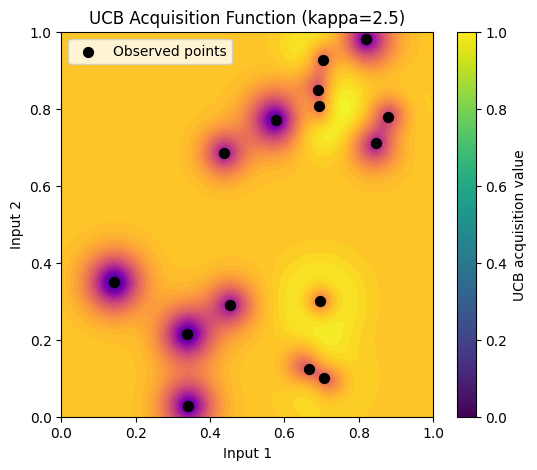

In [80]:
kappa = 2.5
UCB = Y_mean + kappa * Y_std  # shape = (grid_size, grid_size)

plt.figure(figsize=(6,5))
plt.contourf(X1, X2, UCB, cmap='plasma', levels=50)
plt.scatter(f2_inputs[:,0], f2_inputs[:,1], c='k', s=50, label='Observed points')
plt.colorbar(label='UCB acquisition value')
plt.title(f"UCB Acquisition Function (kappa={kappa})")
plt.xlabel("Input 1")
plt.ylabel("Input 2")
plt.legend()
plt.show()

In [81]:
max_idx = np.argmax(UCB)  # index of the maximum UCB
next_point = X_grid[max_idx]  # coordinates in input space

print(f"Current best: {np.max(f2_outputs):.4f}")
print(f"Inputs producing current best: {f2_inputs[np.argmax(f2_outputs)]}")
print("Next point to sample based on UCB:", next_point)
print("-".join(f"{x:.6f}" for x in next_point.flatten()))

Current best: 0.6670
Inputs producing current best: [0.693605 0.805808]
Next point to sample based on UCB: [0.76767677 0.80808081]
0.767677-0.808081


Submission for week 1: 0.818182-0.979798


### Week 2

In [82]:
#Load points to inputs and outputs from previous week
function = 2
week = 1 #previous

row = results_df[(results_df['week'] == week) & (results_df['function'] == function)]
f2_inputs = np.vstack([f2_inputs, row['provided_input'].values[0]])
f2_outputs = np.append(f2_outputs, row['output'].values[0])

improved = row['submission_improved'].values[0]
print(f"Submission from last week improved something? {improved}")
print(f"Current best: {np.max(f2_outputs):.4f}")
print(f"Last week's results: {row['output'].values[0]:.4f}")

Submission from last week improved something? False
Current best: 0.6670
Last week's results: 0.1117


In [83]:
print(f"Correlation between inputs: {np.corrcoef(f2_inputs, rowvar=False)}")

print('Means:', f2_inputs.mean(axis=0))
print('Stds:', f2_inputs.std(axis=0))
print('Mins:', f2_inputs.min(axis=0))
print('Maxs:', f2_inputs.max(axis=0))
print('Std/Mean Ratios:', f2_inputs.std(axis=0) / (f2_inputs.mean(axis=0) + 1e-12))

Correlation between inputs: [[1.         0.55588934]
 [0.55588934 1.        ]]
Means: [0.61297971 0.55598661]
Stds: [0.20525964 0.33062705]
Mins: [0.14269907 0.02869772]
Maxs: [0.87779099 0.979798  ]
Std/Mean Ratios: [0.33485552 0.59466728]


Let's try again a similar Gaussian process and plot the results with the new datapoint in hand.

c:\ml\.venv\Lib\site-packages\sklearn\gaussian_process\kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-12. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


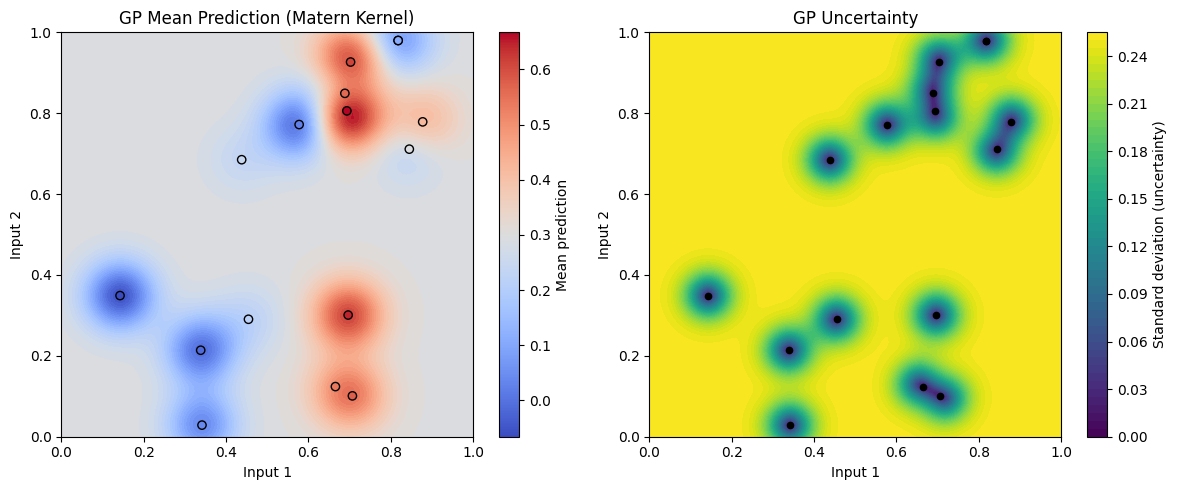

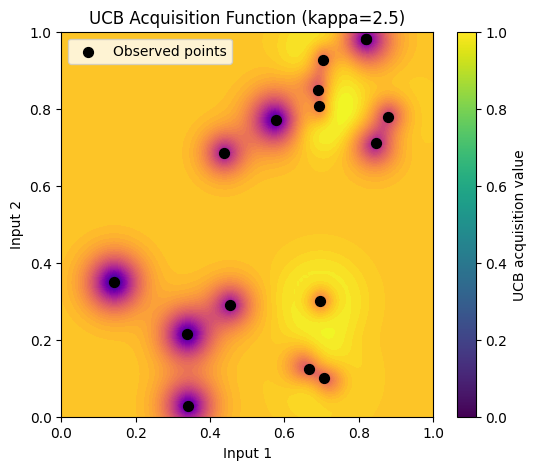

In [84]:
kernel = RBF(length_scale=0.2, length_scale_bounds=(1e-10,1)) + WhiteKernel(noise_level=1e-9, noise_level_bounds=(1e-12, 1e-3))
gp = GaussianProcessRegressor(
    kernel=kernel,
    n_restarts_optimizer=20,
    alpha=1e-8, #modelling noise     
    normalize_y=True,
    random_state=42
)
gp.fit(f2_inputs, f2_outputs)

x1 = np.linspace(0, 1, 100)
x2 = np.linspace(0, 1, 100)
X1, X2 = np.meshgrid(x1, x2)
X_grid = np.column_stack([X1.ravel(), X2.ravel()])

y_mean, y_std = gp.predict(X_grid, return_std=True)
Y_mean = y_mean.reshape(X1.shape)
Y_std = y_std.reshape(X1.shape)

# Plot mean
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.contourf(X1, X2, Y_mean, cmap='coolwarm', levels=50)
plt.scatter(f2_inputs[:,0], f2_inputs[:,1], c=f2_outputs, cmap='coolwarm', edgecolor='k')
plt.colorbar(label='Mean prediction')
plt.title("GP Mean Prediction (Matern Kernel)")
plt.xlabel("Input 1")
plt.ylabel("Input 2")

# Plot uncertainty
plt.subplot(1,2,2)
plt.contourf(X1, X2, Y_std, cmap='viridis', levels=50)
plt.colorbar(label='Standard deviation (uncertainty)')
plt.scatter(f2_inputs[:,0], f2_inputs[:,1], c='k', s=20)
plt.title("GP Uncertainty")
plt.xlabel("Input 1")
plt.ylabel("Input 2")

plt.tight_layout()
plt.show()

kappa = 2.5
UCB = Y_mean + kappa * Y_std  # shape = (grid_size, grid_size)

plt.figure(figsize=(6,5))
plt.contourf(X1, X2, UCB, cmap='plasma', levels=50)
plt.scatter(f2_inputs[:,0], f2_inputs[:,1], c='k', s=50, label='Observed points')
plt.colorbar(label='UCB acquisition value')
plt.title(f"UCB Acquisition Function (kappa={kappa})")
plt.xlabel("Input 1")
plt.ylabel("Input 2")
plt.legend()
plt.show()

In [85]:
max_idx = np.argmax(UCB)  # index of the maximum UCB
next_point = X_grid[max_idx]  # coordinates in input space

print(f"Inputs producing current best: {f2_inputs[np.argmax(f2_outputs)]}")
print("Next point to sample based on UCB:", next_point)

Inputs producing current best: [0.693605 0.805808]
Next point to sample based on UCB: [0.75757576 0.7979798 ]


The acquisition function is basically suggesting to sample around already known points that are close to the maximum. As we are still on week 2, it is worth to use exploration before exploiting the known areas, especially since we are told that it is easy to get stuck at a local minimum.

Let's try a different surrogate function with a penalized UCB for getting close to the borders.

c:\ml\.venv\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge after 13 iteration(s) (status=2):
ABNORMAL: 

You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
c:\ml\.venv\Lib\site-packages\sklearn\gaussian_process\kernels.py:450: ConvergenceWarning: The optimal value found for dimension 1 of parameter k2__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


0.869**2 * Matern(length_scale=[0.0139, 10], nu=2.5)
(10000, 2)


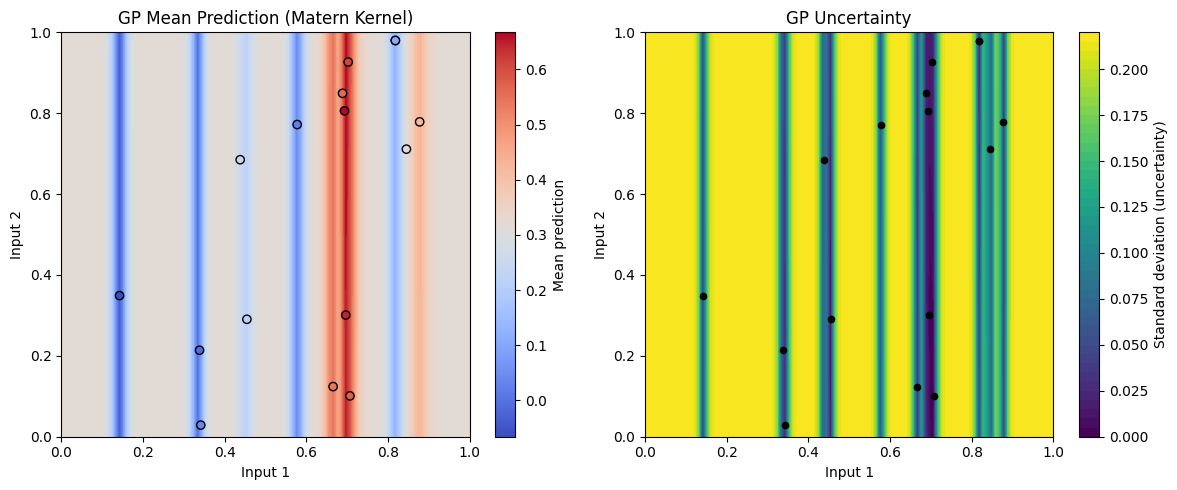

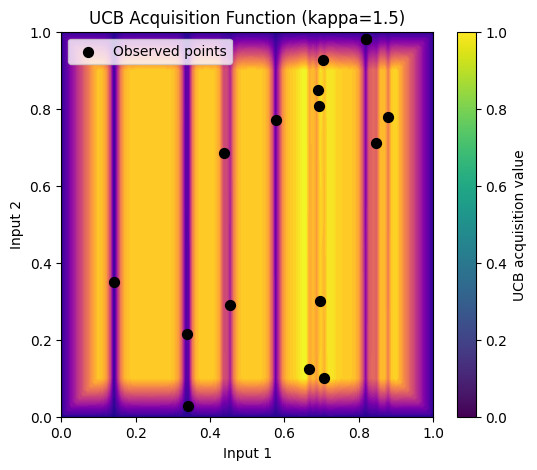

0.869**2 * Matern(length_scale=[0.0139, 10], nu=2.5)


In [86]:
kernel = C(1.0, (1e-2, 10.0)) * Matern(length_scale=[1.0, 1.0], length_scale_bounds=(0.01, 10.0), nu=2.5)
gp = GaussianProcessRegressor(
    kernel=kernel,
    n_restarts_optimizer=20,
    alpha=1e-8, #modelling noise     
    normalize_y=True,
    random_state=42
)
gp.fit(f2_inputs, f2_outputs)

print(gp.kernel_)

x1 = np.linspace(0, 1, 100)
x2 = np.linspace(0, 1, 100)
X1, X2 = np.meshgrid(x1, x2)
X_grid = np.column_stack([X1.ravel(), X2.ravel()])

print(X_grid.shape)

y_mean, y_std = gp.predict(X_grid, return_std=True)
Y_mean = y_mean.reshape(X1.shape)
Y_std = y_std.reshape(X1.shape)

# Plot mean
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.contourf(X1, X2, Y_mean, cmap='coolwarm', levels=50)
plt.scatter(f2_inputs[:,0], f2_inputs[:,1], c=f2_outputs, cmap='coolwarm', edgecolor='k')
plt.colorbar(label='Mean prediction')
plt.title("GP Mean Prediction (Matern Kernel)")
plt.xlabel("Input 1")
plt.ylabel("Input 2")

# Plot uncertainty
plt.subplot(1,2,2)
plt.contourf(X1, X2, Y_std, cmap='viridis', levels=50)
plt.colorbar(label='Standard deviation (uncertainty)')
plt.scatter(f2_inputs[:,0], f2_inputs[:,1], c='k', s=20)
plt.title("GP Uncertainty")
plt.xlabel("Input 1")
plt.ylabel("Input 2")

plt.tight_layout()
plt.show()

kappa = 1.5
UCB = Y_mean + kappa * Y_std  # shape = (grid_size, grid_size)


# Let's add a penalty for getting close to the borders
# Calculate distance to nearest boundary for each dimension (0 and 1 here)
min_boundary_distance = np.minimum(np.min(X_grid, axis=1), np.min(1 - X_grid, axis=1))

# Penalty factor: linearly scale with distance from boundary (0 at boundary, 1 at distance >= penalty_radius)
penalty_radius = 0.1
penalty_factor = np.clip(min_boundary_distance / penalty_radius, 0, 1)

# Apply penalty
UCB = UCB.reshape(100, 100)
penalty_factor = penalty_factor.reshape(100, 100)
UCB_penalized = UCB * penalty_factor

plt.figure(figsize=(6,5))
plt.contourf(X1, X2, UCB_penalized, cmap='plasma', levels=50)
plt.scatter(f2_inputs[:,0], f2_inputs[:,1], c='k', s=50, label='Observed points')
plt.colorbar(label='UCB acquisition value')
plt.title(f"UCB Acquisition Function (kappa={kappa})")
plt.xlabel("Input 1")
plt.ylabel("Input 2")
plt.legend()
plt.show()

print(gp.kernel_)


In [87]:
max_idx = np.argmax(UCB_penalized)  # index of the maximum UCB
next_point = X_grid[max_idx]  # coordinates in input space

print(f"Current best: {np.max(f2_outputs):.4f}")
print(f"Inputs producing current best: {f2_inputs[np.argmax(f2_outputs)]}")
print("Next point to sample based on UCB:", next_point)
print("-".join(f"{x:.6f}" for x in next_point.flatten()))

Current best: 0.6670
Inputs producing current best: [0.693605 0.805808]
Next point to sample based on UCB: [0.65656566 0.8989899 ]
0.656566-0.898990


Submission for week 2: 0.707071-0.101010

### Week 3

In [88]:
#Load points to inputs and outputs from previous week
function = 2
week = 2 #previous

row = results_df[(results_df['week'] == week) & (results_df['function'] == function)]
f2_inputs = np.vstack([f2_inputs, row['provided_input'].values[0]])
f2_outputs = np.append(f2_outputs, row['output'].values[0])

improved = row['submission_improved'].values[0]
print(f"Submission from last week improved something? {improved}")
print(f"Current best: {np.max(f2_outputs):.4f}")
print(f"Last week's results: {row['output'].values[0]:.4f}")
print('--')
print(f"Inputs shape: {f2_inputs.shape}")
print(f"Inputs range: [{np.min(f2_inputs):.4f}, {np.max(f2_inputs):.4f}]")
print(f"Performance range: [{np.min(f2_outputs):.4e}, {np.max(f2_outputs):.4e}]")

Submission from last week improved something? False
Current best: 0.6670
Last week's results: 0.5756
--
Inputs shape: (17, 2)
Inputs range: [0.0287, 0.9798]
Performance range: [-6.5624e-02, 6.6699e-01]


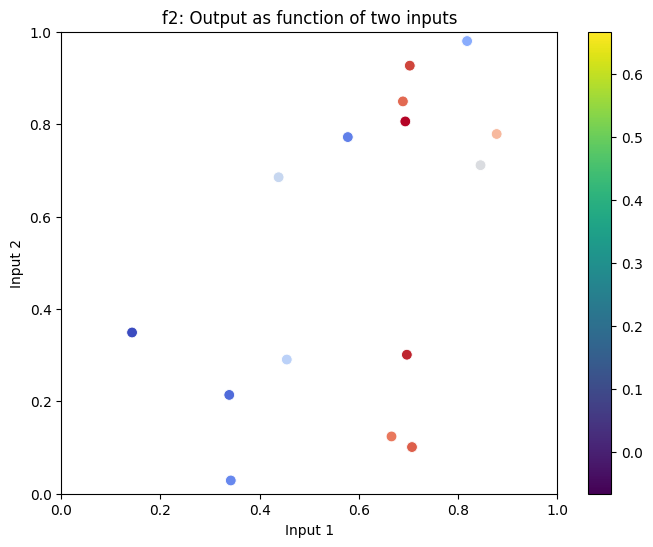

Evaluations: 17
Inputs shape: (17, 2)
Inputs range: [0.0287, 0.9798]
Performance range: [-0.0656, 0.6670]
Current best: 0.6670
Inputs producing current best: [0.693605 0.805808]


In [89]:
x1 = f2_inputs[:, 0]
x2 = f2_inputs[:, 1]
y = f2_outputs

# Put data into a DataFrame
df = pd.DataFrame({
    "x1": x1,
    "x2": x2,
    "y": y
})

# Scatter plot with color encoding the output
plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x="x1", y="x2", hue="y", palette="coolwarm", s=60, legend=False)
plt.title("f2: Output as function of two inputs")
plt.xlabel("Input 1")
plt.ylabel("Input 2")
plt.xlim(0, 1)
plt.ylim(0, 1)
norm = plt.Normalize(vmin=y.min(), vmax=y.max())
sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
plt.colorbar(sm, ax=plt.gca())
plt.show()


print(f"Evaluations: {len(f2_inputs)}")
print(f"Inputs shape: {f2_inputs.shape}")
print(f"Inputs range: [{np.min(f2_inputs):.4f}, {np.max(f2_inputs):.4f}]")
print(f"Performance range: [{np.min(f2_outputs):.4f}, {np.max(f2_outputs):.4f}]")
print(f"Current best: {np.max(f2_outputs):.4f}")
print(f"Inputs producing current best: {f2_inputs[np.argmax(f2_outputs)]}")

Even though the performance did not improve this week, we found potential for another local maximum.

In [90]:
# Define kernel: Matern with nu=2.5 for sharp peaks
kernel = C(1.0, (1e-3, 1e3)) * Matern(length_scale=[0.2, 0.2], nu=2.5)

# Instantiate GP with small noise level
gp = GaussianProcessRegressor(kernel=kernel, alpha=1e-3, normalize_y=True)

# Fit the GP model
gp.fit(f2_inputs, f2_outputs)
print(gp.kernel_)


# Function to optimize acquisition: Expected Improvement
def acquisitionf(x):
    x = np.array(x).reshape(1, -1)
    mean, std = gp.predict(x, return_std=True)
    # Current best observation
    best_y = np.max(f1_outputs)
    # Calculate EI
    z = (mean - best_y) / (std + 1e-9)
    ei = (mean - best_y) * normal_dist.cdf(z) + std * normal_dist.pdf(z)
    return -ei.item()  

# Robust acquisition maximization via multi-start local optimization
bounds = [(0, 1), (0, 1)]
num_restarts = 1500 # I have incremented this until the estimation did no longer move (fixed random seed)
results = []
np.random.seed(42)

for _ in range(num_restarts):
    x0 = np.random.uniform(0, 1, 2)
    res = minimize(acquisitionf, x0, bounds=bounds, method='L-BFGS-B')
    results.append(res)

print(f"Current best: {np.max(f2_outputs):.4f}")
print(f"Inputs producing current best: {f2_inputs[np.argmax(f2_outputs)]}")

# Select best solution from restarts
next_point = min(results, key=lambda r: r.fun).x
print("Next sample point (local optimizer):", next_point)
print("-".join(f"{x:.6f}" for x in next_point.flatten()))

0.886**2 * Matern(length_scale=[0.0149, 16.1], nu=2.5)
Current best: 0.6670
Inputs producing current best: [0.693605 0.805808]
Next sample point (local optimizer): [0.69456776 1.        ]
0.694568-1.000000


Submission for week 3: 0.693605-0.805808

Which is along the vertical line that we found to seem to contain maxima.

### Week 4

In [91]:
#Load points to inputs and outputs from previous week
function = 2
week = 3 #previous

row = results_df[(results_df['week'] == week) & (results_df['function'] == function)]
f2_inputs = np.vstack([f2_inputs, row['provided_input'].values[0]])
f2_outputs = np.append(f2_outputs, row['output'].values[0])

improved = row['submission_improved'].values[0]
print(f"Submission from last week improved something? {improved}")
print(f"Current best: {np.max(f2_outputs):.4f}")
print(f"Last week's results: {row['output'].values[0]:.4f}")
print('--')
print(f"Inputs shape: {f2_inputs.shape}")
print(f"Inputs range: [{np.min(f2_inputs):.4f}, {np.max(f2_inputs):.4f}]")
print(f"Performance range: [{np.min(f2_outputs):.4e}, {np.max(f2_outputs):.4e}]")

Submission from last week improved something? True
Current best: 0.6670
Last week's results: 0.6670
--
Inputs shape: (18, 2)
Inputs range: [0.0287, 0.9798]
Performance range: [-6.5624e-02, 6.6699e-01]


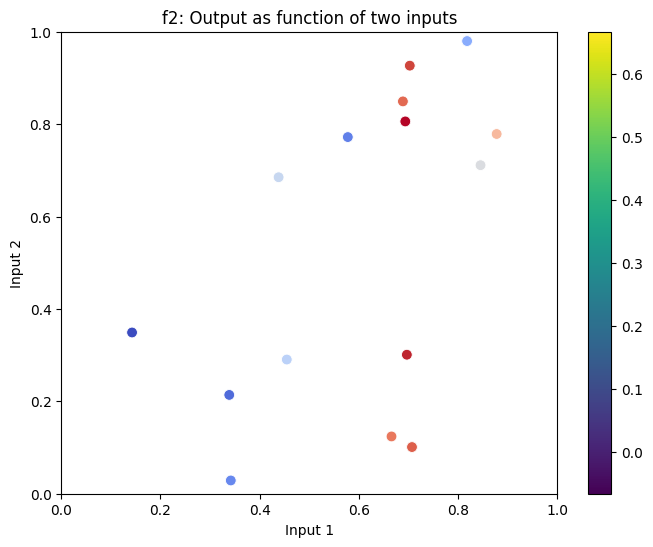

Evaluations: 18
Inputs shape: (18, 2)
Inputs range: [0.0287, 0.9798]
Performance range: [-0.0656, 0.6670]
Current best: 0.6670
Inputs producing current best: [0.693605 0.805808]


In [92]:
x1 = f2_inputs[:, 0]
x2 = f2_inputs[:, 1]
y = f2_outputs

# Put data into a DataFrame
df = pd.DataFrame({
    "x1": x1,
    "x2": x2,
    "y": y
})

# Scatter plot with color encoding the output
plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x="x1", y="x2", hue="y", palette="coolwarm", s=60, legend=False)
plt.title("f2: Output as function of two inputs")
plt.xlabel("Input 1")
plt.ylabel("Input 2")
plt.xlim(0, 1)
plt.ylim(0, 1)
norm = plt.Normalize(vmin=y.min(), vmax=y.max())
sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
plt.colorbar(sm, ax=plt.gca())
plt.show()


print(f"Evaluations: {len(f2_inputs)}")
print(f"Inputs shape: {f2_inputs.shape}")
print(f"Inputs range: [{np.min(f2_inputs):.4f}, {np.max(f2_inputs):.4f}]")
print(f"Performance range: [{np.min(f2_outputs):.4f}, {np.max(f2_outputs):.4f}]")
print(f"Current best: {np.max(f2_outputs):.4f}")
print(f"Inputs producing current best: {f2_inputs[np.argmax(f2_outputs)]}")

This confirms that there is a vertical line along which the function evaluates to the highest values.

In [93]:
# Define kernel: Matern with nu=2.5 for sharp peaks
kernel = C(1.0, (1e-3, 1e3)) * Matern(length_scale=[0.2, 0.2], nu=2.5)

# Instantiate GP with small noise level
gp = GaussianProcessRegressor(kernel=kernel, alpha=1e-3, normalize_y=True)

# Fit the GP model
gp.fit(f2_inputs, f2_outputs)
print(gp.kernel_)


# Function to optimize acquisition: Expected Improvement
def acquisitionf(x):
    x = np.array(x).reshape(1, -1)
    mean, std = gp.predict(x, return_std=True)
    # Current best observation
    best_y = np.max(f1_outputs)
    # Calculate EI
    z = (mean - best_y) / (std + 1e-9)
    ei = (mean - best_y) * normal_dist.cdf(z) + std * normal_dist.pdf(z)
    return -ei.item()  

# Robust acquisition maximization via multi-start local optimization
bounds = [(0, 1), (0, 1)]
num_restarts = 1500 # I have incremented this until the estimation did no longer move (fixed random seed)
results = []
np.random.seed(42)

for _ in range(num_restarts):
    x0 = np.random.uniform(0, 1, 2)
    res = minimize(acquisitionf, x0, bounds=bounds, method='L-BFGS-B')
    results.append(res)

print(f"Current best: {np.max(f2_outputs):.4f}")
print(f"Inputs producing current best: {f2_inputs[np.argmax(f2_outputs)]}")

# Select best solution from restarts
next_point = min(results, key=lambda r: r.fun).x
print("Next sample point (local optimizer):", next_point)
print("-".join(f"{x:.6f}" for x in next_point.flatten()))

0.894**2 * Matern(length_scale=[0.0148, 13.5], nu=2.5)
Current best: 0.6670
Inputs producing current best: [0.693605 0.805808]
Next sample point (local optimizer): [0.69454585 1.        ]
0.694546-1.000000


Submission for week 4: 0.688772-0.849196

### Week 5

In [94]:
#Load points to inputs and outputs from previous week
function = 2
week = 4 #previous

row = results_df[(results_df['week'] == week) & (results_df['function'] == function)]
f2_inputs = np.vstack([f2_inputs, row['provided_input'].values[0]])
f2_outputs = np.append(f2_outputs, row['output'].values[0])

improved = row['submission_improved'].values[0]
print(f"Submission from last week improved something? {improved}")
print(f"Current best: {np.max(f2_outputs):.4f}")
print(f"Last week's results: {row['output'].values[0]:.4f}")
print('--')
print(f"Inputs shape: {f2_inputs.shape}")
print(f"Inputs range: [{np.min(f2_inputs):.4f}, {np.max(f2_inputs):.4f}]")
print(f"Performance range: [{np.min(f2_outputs):.4e}, {np.max(f2_outputs):.4e}]")

Submission from last week improved something? False
Current best: 0.6670
Last week's results: 0.5631
--
Inputs shape: (19, 2)
Inputs range: [0.0287, 0.9798]
Performance range: [-6.5624e-02, 6.6699e-01]


The description of the function tells us to keep exploring bayesian optimisation, so I will continue using surrogate Gaussian processes for this week with tweaked hyperparameters and still some exploration bias.

In [95]:
dims = 2

# Define kernel: Matern with nu=2.5 for sharp peaks
kernel = C(1.0, (1e-3, 1e3)) * Matern(length_scale=[0.2, 0.2], nu=1.5)

# Instantiate GP with small noise level
gp = GaussianProcessRegressor(kernel=kernel, alpha=1e-3, normalize_y=True)

# Fit the GP model
gp.fit(f2_inputs, f2_outputs)
print(gp.kernel_)

def negative_ucb(x, gp, kappa):
    mu, sigma = gp.predict(x.reshape(1, -1), return_std=True)
    return -(mu[0] + kappa * sigma[0])

bounds = [(0, 1) for _ in range(dims)]
num_restarts = 150
results = []
np.random.seed(42)

for _ in range(num_restarts):
    x0 = np.random.uniform(0, 1, dims)
    #choosing kappa 1.5
    result = minimize(negative_ucb, x0=np.random.uniform(0, 1, dims), 
                 args=(gp, 1.5), bounds=bounds, method='L-BFGS-B')
    if result.success:
        results.append(result)
    
# Select best solution from restarts
next_point = min(results, key=lambda r: r.fun).x

print(f"Current best: {np.max(f2_outputs):.4f}")
print(f"Inputs producing current best: {f2_inputs[np.argmax(f2_outputs)]}")

# Select best solution from restarts
print("Next sample point (local optimizer):", next_point)
print("-".join(f"{x:.6f}" for x in next_point.flatten()))

0.947**2 * Matern(length_scale=[0.0231, 1.32e+04], nu=1.5)
Current best: 0.6670
Inputs producing current best: [0.693605 0.805808]
Next sample point (local optimizer): [0.64428354 0.87146059]
0.644284-0.871461


Submission for week 5: 0.696738-0.300878

### Week 6

In [96]:
#Load points to inputs and outputs from previous week
function = 2
week = 5 #previous

row = results_df[(results_df['week'] == week) & (results_df['function'] == function)]
f2_inputs = np.vstack([f2_inputs, row['provided_input'].values[0]])
f2_outputs = np.append(f2_outputs, row['output'].values[0])

improved = row['submission_improved'].values[0]
print(f"Submission from last week improved something? {improved}")
print(f"Current best: {np.max(f2_outputs):.4f}")
print(f"Last week's results: {row['output'].values[0]:.4f}")
print('--')
print(f"Inputs shape: {f2_inputs.shape}")
print(f"Inputs range: [{np.min(f2_inputs):.4f}, {np.max(f2_inputs):.4f}]")
print(f"Performance range: [{np.min(f2_outputs):.4e}, {np.max(f2_outputs):.4e}]")

Submission from last week improved something? False
Current best: 0.6670
Last week's results: 0.6459
--
Inputs shape: (20, 2)
Inputs range: [0.0287, 0.9798]
Performance range: [-6.5624e-02, 6.6699e-01]


This is best than last week, and close to the currently known best, but not better than previous outputs.

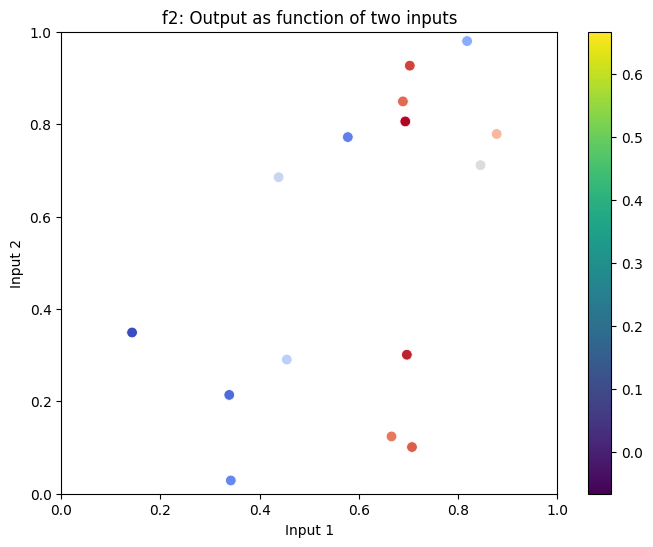

Evaluations: 20
Inputs shape: (20, 2)
Inputs range: [0.0287, 0.9798]
Performance range: [-0.0656, 0.6670]
Current best: 0.6670
Inputs producing current best: [0.693605 0.805808]


In [97]:
x1 = f2_inputs[:, 0]
x2 = f2_inputs[:, 1]
y = f2_outputs

# Put data into a DataFrame
df = pd.DataFrame({
    "x1": x1,
    "x2": x2,
    "y": y
})

# Scatter plot with color encoding the output
plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x="x1", y="x2", hue="y", palette="coolwarm", s=60, legend=False)
plt.title("f2: Output as function of two inputs")
plt.xlabel("Input 1")
plt.ylabel("Input 2")
plt.xlim(0, 1)
plt.ylim(0, 1)
norm = plt.Normalize(vmin=y.min(), vmax=y.max())
sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
plt.colorbar(sm, ax=plt.gca())
plt.show()


print(f"Evaluations: {len(f2_inputs)}")
print(f"Inputs shape: {f2_inputs.shape}")
print(f"Inputs range: [{np.min(f2_inputs):.4f}, {np.max(f2_inputs):.4f}]")
print(f"Performance range: [{np.min(f2_outputs):.4f}, {np.max(f2_outputs):.4f}]")
print(f"Current best: {np.max(f2_outputs):.4f}")
print(f"Inputs producing current best: {f2_inputs[np.argmax(f2_outputs)]}")

There is clearly something along the vertial line at x1 = 0.7 that indicates maxima along that axis. The max values are in the 0.6-0.7 range.

Similar to what I have tried with function 1, I will just sample one random point manually. This is how I have decided to spend this week's "bullet".

In [98]:
chosen_point = np.array([0.9, 0.5])
print("-".join(f"{x:.6f}" for x in chosen_point.flatten()))

0.900000-0.500000


Sample for week 6: 0.900000-0.500000

### Week 7

In [99]:
#Load points to inputs and outputs from previous week
function = 2
week = 7 #previous

row = results_df[(results_df['week'] == week) & (results_df['function'] == function)]
f2_inputs = np.vstack([f2_inputs, row['provided_input'].values[0]])
f2_outputs = np.append(f2_outputs, row['output'].values[0])

improved = row['submission_improved'].values[0]
print(f"Submission from last week improved something? {improved}")
print(f"Current best: {np.max(f2_outputs):.4f}")
print(f"Last week's results: {row['output'].values[0]:.4f}")
print('--')
print(f"Inputs shape: {f2_inputs.shape}")
print(f"Inputs range: [{np.min(f2_inputs):.4f}, {np.max(f2_inputs):.4f}]")
print(f"Performance range: [{np.min(f2_outputs):.4e}, {np.max(f2_outputs):.4e}]")

IndexError: index 0 is out of bounds for axis 0 with size 0

## Function 3

This function is a function with a 1D output and a 3D input. 

This is the description of the function: you’re working on a drug discovery project, testing combinations of three compounds to create a new medicine.

Each experiment is stored in initial_inputs.npy as a 3D array, where each row lists the amounts of the three compounds used. After each experiment, you record the number of adverse reactions, stored in initial_outputs.npy as a 1D array.

Your goal is to minimise side effects; in this competition, it is framed as maximisation by optimising a transformed output (e.g. the negative of side effects). 

### Week 1

Let's observe the data.

In [100]:
#print(f3_inputs)
#print(f3_outputs)

print(f"Evaluations: {len(f3_inputs)}")
print(f"Inputs shape: {f3_inputs.shape}")
print(f"Inputs range: [{np.min(f3_inputs):.4f}, {np.max(f3_inputs):.4f}]")
print(f"Performance range: [{np.min(f3_outputs):.4f}, {np.max(f3_outputs):.4f}]")
print(f"Current best: {np.max(f3_outputs):.4f}")
print(f"Inputs producing current best: {f3_inputs[np.argmax(f3_outputs)]}")


Evaluations: 15
Inputs shape: (15, 3)
Inputs range: [0.0468, 0.9909]
Performance range: [-0.3989, -0.0348]
Current best: -0.0348
Inputs producing current best: [0.49258141 0.61159319 0.34017639]


And even attempt to plot it.

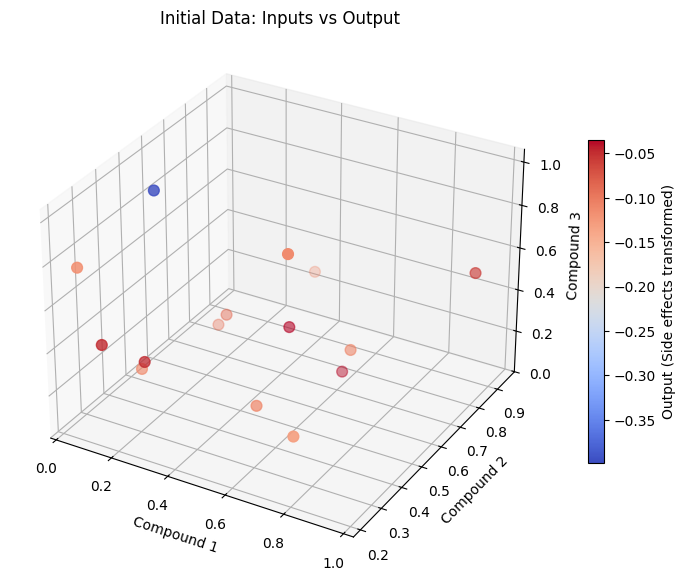

In [101]:
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(f3_inputs[:,0], f3_inputs[:,1], f3_inputs[:,2], 
                c=f3_outputs, cmap='coolwarm', s=60)

ax.set_xlabel("Compound 1")
ax.set_ylabel("Compound 2")
ax.set_zlabel("Compound 3")
ax.set_title("Initial Data: Inputs vs Output")
cbar = fig.colorbar(sc, ax=ax, shrink=0.6)
cbar.set_label("Output (Side effects transformed)")
plt.show()

In [102]:
# Let's follow a similar approach as with the others with a Matern and WhiteKerel

kernel = Matern(length_scale=[0.1, 0.1, 0.1], length_scale_bounds=(0.01, 1.0), nu=1.5) \
         + WhiteKernel(noise_level=1e-6)
gp = GaussianProcessRegressor(kernel=kernel, alpha=1e-6, normalize_y=True, n_restarts_optimizer=10)
gp.fit(f3_inputs, f3_outputs)

c:\ml\.venv\Lib\site-packages\sklearn\gaussian_process\kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\ml\.venv\Lib\site-packages\sklearn\gaussian_process\kernels.py:450: ConvergenceWarning: The optimal value found for dimension 1 of parameter k1__length_scale is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\ml\.venv\Lib\site-packages\sklearn\gaussian_process\kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


,kernel,Matern(length...e_level=1e-06)
,alpha,1e-06
,optimizer,'fmin_l_bfgs_b'
,n_restarts_optimizer,10
,normalize_y,True
,copy_X_train,True
,n_targets,None
,random_state,None
,kernel__k1,"Matern(length... 0.1], nu=1.5)"
,kernel__k2,WhiteKernel(noise_level=1e-06)
,kernel__k1__length_scale,"[0.1, 0.1, ...]"


Getting these warnings:
* ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
* ConvergenceWarning: The optimal value found for dimension 1 of parameter k1__length_scale is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
* ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.

In [103]:
# Trying new hyperparameters, with wider length scale bounds, and introducing noise_level_bounds. amd more restarts optimizers, a constant kernel and wider bounds.

# Let's follow a similar approach as with the others with a Matern and WhiteKerel and a Constant Kernel (because I was getting many "close to bounds" messages)

kernel = C(1.0, (1e-5, 1e5)) * Matern(length_scale=[1.0, 1.0, 1.0], length_scale_bounds=(1e-5, 1e8), nu=2.5) \
         + WhiteKernel(noise_level=1e-8, noise_level_bounds=(1e-10, 1e0))
gp = GaussianProcessRegressor(kernel=kernel, alpha=1e-6, normalize_y=True, n_restarts_optimizer=20, random_state=42)
gp.fit(f3_inputs, f3_outputs)

# And calculate over the whole cube

x1 = np.linspace(0, 1, 30)
x2 = np.linspace(0, 1, 30)
x3 = np.linspace(0, 1, 30)
X1, X2, X3 = np.meshgrid(x1, x2, x3)
X_candidate = np.column_stack([X1.ravel(), X2.ravel(), X3.ravel()])
y_mean, y_std = gp.predict(X_candidate, return_std=True)

# We will use Probability of improvement (PI) as an acquisition function with a penalty for being close to the boundary (was getting 1 1 0)
y_max = np.max(f3_outputs)
eta = 0.01
z = (y_mean - y_max - eta) / (y_std + 1e-12)
pi = stats.norm.cdf(z)
boundary_distances = np.minimum(X_candidate, 1 - X_candidate)
min_boundary_distance = np.min(boundary_distances, axis=1)
boundary_penalty = np.clip(min_boundary_distance / 0.1, 0, 1)
        
acquisition_function = pi * boundary_penalty

best_idx = np.argmax(acquisition_function)
next_point = X_candidate[best_idx]

print(f"Current best: {np.max(f3_outputs):.4f}")
print(f"Inputs producing current best: {f3_inputs[np.argmax(f3_outputs)]}")
print("Next point to sample based on PI:", next_point)
print("-".join(f"{x:.6f}" for x in next_point.flatten()))

Current best: -0.0348
Inputs producing current best: [0.49258141 0.61159319 0.34017639]
Next point to sample based on PI: [0.17241379 0.20689655 0.24137931]
0.172414-0.206897-0.241379


Submission for week 1: 0.172414-0.206897-0.206897

### Week 2

In [104]:
#Load points to inputs and outputs from previous week
function = 3
week = 1 #previous

row = results_df[(results_df['week'] == week) & (results_df['function'] == function)]
f3_inputs = np.vstack([f3_inputs, row['provided_input'].values[0]])
f3_outputs = np.append(f3_outputs, row['output'].values[0])

improved = row['submission_improved'].values[0]
print(f"Submission from last week improved something? {improved}")
print(f"Current best: {np.max(f3_outputs):.4f}")
print(f"Last week's results: {row['output'].values[0]:.4f}")

Submission from last week improved something? False
Current best: -0.0348
Last week's results: -0.1476


In [105]:
print(f"Correlation between inputs: {np.corrcoef(f3_inputs, rowvar=False)}")

print('Means:', f3_inputs.mean(axis=0))
print('Stds:', f3_inputs.std(axis=0))
print('Mins:', f3_inputs.min(axis=0))
print('Maxs:', f3_inputs.max(axis=0))
print('Std/Mean Ratios:', f3_inputs.std(axis=0) / (f3_inputs.mean(axis=0) + 1e-12))

Correlation between inputs: [[ 1.          0.43437673 -0.08996019]
 [ 0.43437673  1.         -0.22739406]
 [-0.08996019 -0.22739406  1.        ]]
Means: [0.39424239 0.49825298 0.3905444 ]
Stds: [0.26357423 0.23052493 0.26998681]
Mins: [0.04680895 0.206897   0.06608864]
Maxs: [0.96599485 0.94135983 0.99088187]
Std/Mean Ratios: [0.66855884 0.46266644 0.6913089 ]


Let us try the same strategy again but with a UCB function

In [106]:
kernel = C(1.0, (1e-5, 1e5)) * Matern(length_scale=[1.0, 1.0, 1.0], length_scale_bounds=(1e-5, 1e8), nu=2.5) \
         + WhiteKernel(noise_level=1e-8, noise_level_bounds=(1e-10, 1e0))
gp = GaussianProcessRegressor(kernel=kernel, alpha=1e-6, normalize_y=True, n_restarts_optimizer=20, random_state=42)
gp.fit(f3_inputs, f3_outputs)


print(gp.kernel_)
#print(f3_inputs)

# And calculate over the whole cube

x1 = np.linspace(0, 1, 30)
x2 = np.linspace(0, 1, 30)
x3 = np.linspace(0, 1, 30)
X1, X2, X3 = np.meshgrid(x1, x2, x3)
X_candidate = np.column_stack([X1.ravel(), X2.ravel(), X3.ravel()])
y_mean, y_std = gp.predict(X_candidate, return_std=True)

# We will use Probability of improvement (PI) as an acquisition function with a penalty for being close to the boundary (was getting 1 1 0)
y_max = np.max(f3_outputs)
eta = 0.01
z = (y_mean - y_max - eta) / (y_std + 1e-12)
pi = stats.norm.cdf(z)
boundary_distances = np.minimum(X_candidate, 1 - X_candidate)
min_boundary_distance = np.min(boundary_distances, axis=1)
boundary_penalty = np.clip(min_boundary_distance / 0.1, 0, 1)
        
acquisition_function = pi * boundary_penalty

best_idx = np.argmax(acquisition_function)
next_point_pi = X_candidate[best_idx]

print(f"Current best: {np.max(f3_outputs):.4f}")
print(f"Inputs producing current best: {f3_inputs[np.argmax(f3_outputs)]}")
print("Next point to sample based on PI:", next_point_pi)

kappa = 0.5
UCB = y_mean + kappa * y_std  # shape = (grid_size, grid_size)
max_idx = np.argmax(UCB)  # index of the maximum UCB
next_point_ucb = X_candidate[max_idx]  # coordinates in input space
print("Next point to sample based on UCB:", next_point_ucb)


print("-".join(f"{x:.6f}" for x in next_point_ucb.flatten()))

1.06**2 * Matern(length_scale=[0.00375, 1.59e+07, 2.7e+04], nu=2.5) + WhiteKernel(noise_level=0.00456)
Current best: -0.0348
Inputs producing current best: [0.49258141 0.61159319 0.34017639]
Next point to sample based on PI: [0.13793103 0.10344828 0.4137931 ]
Next point to sample based on UCB: [0.13793103 0.         0.4137931 ]
0.137931-0.000000-0.413793


Submission for week 2: 0.862069-0.137931-0.655172

### Week 3

In [107]:
#Load points to inputs and outputs from previous week
function = 3
week = 2 #previous

row = results_df[(results_df['week'] == week) & (results_df['function'] == function)]
f3_inputs = np.vstack([f3_inputs, row['provided_input'].values[0]])
f3_outputs = np.append(f3_outputs, row['output'].values[0])

improved = row['submission_improved'].values[0]
print(f"Submission from last week improved something? {improved}")
print(f"Current best: {np.max(f3_outputs):.4f}")
print(f"Last week's results: {row['output'].values[0]:.4f}")
print('--')
print(f"Inputs shape: {f3_inputs.shape}")
print(f"Inputs range: [{np.min(f3_inputs):.4f}, {np.max(f3_inputs):.4f}]")
print(f"Performance range: [{np.min(f3_outputs):.4f}, {np.max(f3_outputs):.4f}]")

Submission from last week improved something? False
Current best: -0.0348
Last week's results: -0.1406
--
Inputs shape: (17, 3)
Inputs range: [0.0468, 0.9909]
Performance range: [-0.3989, -0.0348]


For this function I have been unable to make any improvement yet. This week I will try the same approach as for functions 1 and 2 with an EI acquisition function.

In [108]:
# Define kernel: Matern with nu=2.5 for sharp peaks
kernel = C(1.0, (1e-3, 1e3)) * Matern(length_scale=[0.2]*3, nu=2.5)

# Instantiate GP with small noise level
gp = GaussianProcessRegressor(kernel=kernel, alpha=1e-3, normalize_y=True)

# Fit the GP model
gp.fit(f3_inputs, f3_outputs)
print(gp.kernel_)


# Function to optimize acquisition: Expected Improvement
def acquisitionf(x):
    x = np.array(x).reshape(1, -1)
    mean, std = gp.predict(x, return_std=True)
    # Current best observation
    best_y = np.max(f3_outputs)
    # Calculate EI
    z = (mean - best_y) / (std + 1e-9)
    ei = (mean - best_y) * normal_dist.cdf(z) + std * normal_dist.pdf(z)
    return -ei.item()  

# Robust acquisition maximization via multi-start local optimization
bounds = [(0, 1), (0, 1), (0, 1)]
num_restarts = 1500 # I have incremented this until the estimation did no longer move (fixed random seed)
results = []
np.random.seed(42)

for _ in range(num_restarts):
    x0 = np.random.uniform(0, 1, 3)
    res = minimize(acquisitionf, x0, bounds=bounds, method='L-BFGS-B')
    results.append(res)

print(f"Current best: {np.max(f3_outputs):.4f}")
print(f"Inputs producing current best: {f3_inputs[np.argmax(f3_outputs)]}")

# Select best solution from restarts
next_point = min(results, key=lambda r: r.fun).x
print("Next sample point (local optimizer):", next_point)
print("-".join(f"{x:.6f}" for x in next_point.flatten()))

1.19**2 * Matern(length_scale=[1e+05, 2.5e+04, 0.0299], nu=2.5)


c:\ml\.venv\Lib\site-packages\sklearn\gaussian_process\kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Current best: -0.0348
Inputs producing current best: [0.49258141 0.61159319 0.34017639]
Next sample point (local optimizer): [0.50746773 0.00638587 0.30476654]
0.507468-0.006386-0.304767


Submission for week 3: 0.507468-0.006386-0.305268

### Week 4

In [109]:
#Load points to inputs and outputs from previous week
function = 3
week = 3 #previous

row = results_df[(results_df['week'] == week) & (results_df['function'] == function)]
f3_inputs = np.vstack([f3_inputs, row['provided_input'].values[0]])
f3_outputs = np.append(f3_outputs, row['output'].values[0])

improved = row['submission_improved'].values[0]
print(f"Submission from last week improved something? {improved}")
print(f"Current best: {np.max(f3_outputs):.4f}")
print(f"Last week's results: {row['output'].values[0]:.4f}")
print('--')
print(f"Inputs shape: {f3_inputs.shape}")
print(f"Inputs range: [{np.min(f3_inputs):.4f}, {np.max(f3_inputs):.4f}]")
print(f"Performance range: [{np.min(f3_outputs):.4f}, {np.max(f3_outputs):.4f}]")

Submission from last week improved something? False
Current best: -0.0348
Last week's results: -0.1297
--
Inputs shape: (18, 3)
Inputs range: [0.0064, 0.9909]
Performance range: [-0.3989, -0.0348]


I have yet to be able to further optimize this function beyond the known best values.

I will try an RBF kernel despite the description of sharp peaks.

In [110]:
dims = 3

kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale=[0.2]*dims, length_scale_bounds=(1e-10,1))

# Instantiate GP with small noise level
gp = GaussianProcessRegressor(kernel=kernel, alpha=1e-3, normalize_y=True)

# Fit the GP model
gp.fit(f3_inputs, f3_outputs)
print(gp.kernel_)


# Function to optimize acquisition: Expected Improvement
def acquisitionf(x):
    x = np.array(x).reshape(1, -1)
    mean, std = gp.predict(x, return_std=True)
    # Current best observation
    best_y = np.max(f3_outputs)
    # Calculate EI
    z = (mean - best_y) / (std + 1e-9)
    ei = (mean - best_y) * normal_dist.cdf(z) + std * normal_dist.pdf(z)
    return -ei.item()  

# Robust acquisition maximization via multi-start local optimization
bounds = [(0, 1) for _ in range(dims)]
num_restarts = 150 
results = []
np.random.seed(42)

for _ in range(num_restarts):
    x0 = np.random.uniform(0, 1, dims)
    res = minimize(acquisitionf, x0, bounds=bounds, method='L-BFGS-B')
    results.append(res)

print(f"Current best: {np.max(f3_outputs):.4e}")
print(f"Inputs producing current best: {f3_inputs[np.argmax(f3_outputs)]}")

# Select best solution from restarts
next_point_ei = min(results, key=lambda r: r.fun).x
print("Next sample point (ei):", next_point_ei)


def negative_ucb(x, gp, kappa):
    mu, sigma = gp.predict(x.reshape(1, -1), return_std=True)
    return -(mu[0] + kappa * sigma[0])

bounds = [(0, 1) for _ in range(dims)]
num_restarts = 150
results = []
np.random.seed(42)

for _ in range(num_restarts):
    x0 = np.random.uniform(0, 1, dims)
    result = minimize(negative_ucb, x0=np.random.uniform(0, 1, dims), 
                 args=(gp, 1.7), bounds=bounds, method='L-BFGS-B')
    if result.success:
        results.append(result)
    
# Select best solution from restarts
next_point_ucb = min(results, key=lambda r: r.fun).x
print("Next sample point (ucb):", next_point_ucb)


print("-".join(f"{x:.6f}" for x in next_point_ei.flatten()))

1.83**2 * RBF(length_scale=[1, 0.93, 0.15])


c:\ml\.venv\Lib\site-packages\sklearn\gaussian_process\kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Current best: -3.4835e-02
Inputs producing current best: [0.49258141 0.61159319 0.34017639]
Next sample point (ei): [1.         0.60328737 0.83528216]
Next sample point (ucb): [1.         1.         0.81556324]
1.000000-0.603287-0.835282


I choose the EI value.

Submission for week 4: 0.589937-0.603952-0.435945

### Week 5

In [111]:
#Load points to inputs and outputs from previous week
function = 3
week = 4 #previous

row = results_df[(results_df['week'] == week) & (results_df['function'] == function)]
f3_inputs = np.vstack([f3_inputs, row['provided_input'].values[0]])
f3_outputs = np.append(f3_outputs, row['output'].values[0])

improved = row['submission_improved'].values[0]
print(f"Submission from last week improved something? {improved}")
print(f"Current best: {np.max(f3_outputs):.4f}")
print(f"Last week's results: {row['output'].values[0]:.4f}")
print('--')
print(f"Inputs shape: {f3_inputs.shape}")
print(f"Inputs range: [{np.min(f3_inputs):.4f}, {np.max(f3_inputs):.4f}]")
print(f"Performance range: [{np.min(f3_outputs):.4f}, {np.max(f3_outputs):.4f}]")

Submission from last week improved something? True
Current best: -0.0015
Last week's results: -0.0015
--
Inputs shape: (19, 3)
Inputs range: [0.0064, 0.9909]
Performance range: [-0.3989, -0.0015]


This is a near 0 value! Remember that 0 is the goal. This week's submission should be focused on exploitation of this area. Last week we chose the highest EI, let's replicate the same again.

In [112]:
dims = 3

#kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale=[0.2]*dims, length_scale_bounds=(1e-10,10))
#kernel = C(1.0, (1e-3, 1e3)) * Matern(length_scale=[0.2]*dims, nu=1.5) + C(1.0, (1e-3, 1e3)) * RBF(length_scale=[0.2]*dims, length_scale_bounds=(1e-10,1))

kernel = C(1.0, (1e-5, 1e5)) * Matern(length_scale=[1.0, 1.0, 1.0], length_scale_bounds=(1e-5, 1e8), nu=2.5) \
         + WhiteKernel(noise_level=1e-8, noise_level_bounds=(1e-10, 1e0))
gp = GaussianProcessRegressor(kernel=kernel, alpha=1e-6, normalize_y=True, n_restarts_optimizer=20, random_state=42)
# Instantiate GP with small noise level
#gp = GaussianProcessRegressor(kernel=kernel, alpha=1e-3, normalize_y=True)

# Fit the GP model
gp.fit(f3_inputs, f3_outputs)
print(gp.kernel_)


# Function to optimize acquisition: Expected Improvement
def acquisitionf(x):
    x = np.array(x).reshape(1, -1)
    mean, std = gp.predict(x, return_std=True)
    # Current best observation
    best_y = np.max(f3_outputs)
    # Calculate EI
    z = (mean - best_y) / (std + 1e-12)
    ei = (mean - best_y) * normal_dist.cdf(z) + std * normal_dist.pdf(z)
    return -ei.item()  

# Robust acquisition maximization via multi-start local optimization
bounds = [(0, 1) for _ in range(dims)]
num_restarts = 250 
results = []
np.random.seed(42)

for _ in range(num_restarts):
    x0 = np.random.uniform(0, 1, dims)
    res = minimize(acquisitionf, x0, bounds=bounds, method='L-BFGS-B')
    results.append(res)

print(f"Current best: {np.max(f3_outputs):.4e}")
print(f"Inputs producing current best: {f3_inputs[np.argmax(f3_outputs)]}")

# Select best solution from restarts
next_point_ei = min(results, key=lambda r: r.fun).x
print("Next sample point (ei):", next_point_ei)


def negative_ucb(x, gp, kappa):
    mu, sigma = gp.predict(x.reshape(1, -1), return_std=True)
    return -(mu[0] + kappa * sigma[0])

bounds = [(0, 1) for _ in range(dims)]
num_restarts = 250
results = []
np.random.seed(42)

for _ in range(num_restarts):
    x0 = np.random.uniform(0, 1, dims)
    result = minimize(negative_ucb, x0=np.random.uniform(0, 1, dims), 
                 args=(gp, 0.4), bounds=bounds, method='L-BFGS-B')
    if result.success:
        results.append(result)
    
# Select best solution from restarts
next_point_ucb = min(results, key=lambda r: r.fun).x
print("Next sample point (ucb):", next_point_ucb)


x1 = np.linspace(0, 1, 50)
x2 = np.linspace(0, 1, 50)
x3 = np.linspace(0, 1, 50)
X1, X2, X3 = np.meshgrid(x1, x2, x3)
X_candidate = np.column_stack([X1.ravel(), X2.ravel(), X3.ravel()])
y_mean, y_std = gp.predict(X_candidate, return_std=True)

# We will use Probability of improvement (PI) as an acquisition function with a penalty for being close to the boundary (was getting 1 1 0)
y_max = np.max(f3_outputs)
eta = 0.01
z = (y_mean - y_max - eta) / (y_std + 1e-12)
pi = stats.norm.cdf(z)
boundary_distances = np.minimum(X_candidate, 1 - X_candidate)
min_boundary_distance = np.min(boundary_distances, axis=1)
boundary_penalty = np.clip(min_boundary_distance / 0.1, 0, 1)
        
acquisition_function = pi * boundary_penalty

best_idx = np.argmax(acquisition_function)
next_point_pi = X_candidate[best_idx]

print("Next sample point (pi):", next_point_pi)


print(f"Current best: {np.max(f3_outputs):.4f}")
print(f"Inputs producing current best: {f3_inputs[np.argmax(f3_outputs)]}")
print("-".join(f"{x:.6f}" for x in next_point_ei.flatten()))

1.05**2 * Matern(length_scale=[0.00415, 1.06e+07, 139], nu=2.5) + WhiteKernel(noise_level=0.00824)
Current best: -1.4942e-03
Inputs producing current best: [0.589937 0.603952 0.435945]
Next sample point (ei): [0.59311412 0.44844552 0.29321078]
Next sample point (ucb): [0.59125107 0.47157619 0.41184091]
Next sample point (pi): [0.59183673 0.44897959 0.3877551 ]
Current best: -0.0015
Inputs producing current best: [0.589937 0.603952 0.435945]
0.593114-0.448446-0.293211


Submission for week 5: 0.593114-0.448446-0.293211

### Week 6

In [113]:
#Load points to inputs and outputs from previous week
function = 3
week = 5 #previous

row = results_df[(results_df['week'] == week) & (results_df['function'] == function)]
f3_inputs = np.vstack([f3_inputs, row['provided_input'].values[0]])
f3_outputs = np.append(f3_outputs, row['output'].values[0])

improved = row['submission_improved'].values[0]
print(f"Submission from last week improved something? {improved}")
print(f"Current best: {np.max(f3_outputs):.4f}")
print(f"Last week's results: {row['output'].values[0]:.4f}")
print('--')
print(f"Inputs shape: {f3_inputs.shape}")
print(f"Inputs range: [{np.min(f3_inputs):.4f}, {np.max(f3_inputs):.4f}]")
print(f"Performance range: [{np.min(f3_outputs):.4f}, {np.max(f3_outputs):.4f}]")

Submission from last week improved something? False
Current best: -0.0015
Last week's results: -0.0753
--
Inputs shape: (20, 3)
Inputs range: [0.0064, 0.9909]
Performance range: [-0.3989, -0.0015]


I will try again the same strategy as we are very close to 0. EI as aquisition function.

In [114]:
dims = 3

#kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale=[0.2]*dims, length_scale_bounds=(1e-10,10))
#kernel = C(1.0, (1e-3, 1e3)) * Matern(length_scale=[0.2]*dims, nu=1.5) + C(1.0, (1e-3, 1e3)) * RBF(length_scale=[0.2]*dims, length_scale_bounds=(1e-10,1))

kernel = C(1.0, (1e-5, 1e5)) * Matern(length_scale=[1.0, 1.0, 1.0], length_scale_bounds=(1e-5, 1e8), nu=2.5) \
         + WhiteKernel(noise_level=1e-8, noise_level_bounds=(1e-10, 1e0))
gp = GaussianProcessRegressor(kernel=kernel, alpha=1e-6, normalize_y=True, n_restarts_optimizer=20, random_state=42)
# Instantiate GP with small noise level
#gp = GaussianProcessRegressor(kernel=kernel, alpha=1e-3, normalize_y=True)

# Fit the GP model
gp.fit(f3_inputs, f3_outputs)
print(gp.kernel_)


# Function to optimize acquisition: Expected Improvement
def acquisitionf(x):
    x = np.array(x).reshape(1, -1)
    mean, std = gp.predict(x, return_std=True)
    # Current best observation
    best_y = np.max(f3_outputs)
    # Calculate EI
    z = (mean - best_y) / (std + 1e-12)
    ei = (mean - best_y) * normal_dist.cdf(z) + std * normal_dist.pdf(z)
    return -ei.item()  

# Robust acquisition maximization via multi-start local optimization
bounds = [(0, 1) for _ in range(dims)]
num_restarts = 250 
results = []
np.random.seed(42)

for _ in range(num_restarts):
    x0 = np.random.uniform(0, 1, dims)
    res = minimize(acquisitionf, x0, bounds=bounds, method='L-BFGS-B')
    results.append(res)

print(f"Current best: {np.max(f3_outputs):.4e}")
print(f"Inputs producing current best: {f3_inputs[np.argmax(f3_outputs)]}")

# Select best solution from restarts
next_point_ei = min(results, key=lambda r: r.fun).x
print("Next sample point (ei):", next_point_ei)


def negative_ucb(x, gp, kappa):
    mu, sigma = gp.predict(x.reshape(1, -1), return_std=True)
    return -(mu[0] + kappa * sigma[0])

bounds = [(0, 1) for _ in range(dims)]
num_restarts = 250
results = []
np.random.seed(42)

for _ in range(num_restarts):
    x0 = np.random.uniform(0, 1, dims)
    result = minimize(negative_ucb, x0=np.random.uniform(0, 1, dims), 
                 args=(gp, 0.4), bounds=bounds, method='L-BFGS-B')
    if result.success:
        results.append(result)
    
# Select best solution from restarts
next_point_ucb = min(results, key=lambda r: r.fun).x
print("Next sample point (ucb):", next_point_ucb)


x1 = np.linspace(0, 1, 50)
x2 = np.linspace(0, 1, 50)
x3 = np.linspace(0, 1, 50)
X1, X2, X3 = np.meshgrid(x1, x2, x3)
X_candidate = np.column_stack([X1.ravel(), X2.ravel(), X3.ravel()])
y_mean, y_std = gp.predict(X_candidate, return_std=True)

# We will use Probability of improvement (PI) as an acquisition function with a penalty for being close to the boundary (was getting 1 1 0)
y_max = np.max(f3_outputs)
eta = 0.01
z = (y_mean - y_max - eta) / (y_std + 1e-12)
pi = stats.norm.cdf(z)
boundary_distances = np.minimum(X_candidate, 1 - X_candidate)
min_boundary_distance = np.min(boundary_distances, axis=1)
boundary_penalty = np.clip(min_boundary_distance / 0.1, 0, 1)
        
acquisition_function = pi * boundary_penalty

best_idx = np.argmax(acquisition_function)
next_point_pi = X_candidate[best_idx]

print("Next sample point (pi):", next_point_pi)


print(f"Current best: {np.max(f3_outputs):.4f}")
print(f"Inputs producing current best: {f3_inputs[np.argmax(f3_outputs)]}")
print("-".join(f"{x:.6f}" for x in next_point_ei.flatten()))

c:\ml\.venv\Lib\site-packages\sklearn\gaussian_process\kernels.py:450: ConvergenceWarning: The optimal value found for dimension 1 of parameter k1__k2__length_scale is close to the specified upper bound 100000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


1.05**2 * Matern(length_scale=[0.0034, 1e+08, 2.5e+04], nu=2.5) + WhiteKernel(noise_level=0.00394)
Current best: -1.4942e-03
Inputs producing current best: [0.589937 0.603952 0.435945]
Next sample point (ei): [0.5878696  0.09717649 0.61500723]
Next sample point (ucb): [0.58889535 0.77096718 0.4937956 ]
Next sample point (pi): [0.48979592 0.10204082 0.89795918]
Current best: -0.0015
Inputs producing current best: [0.589937 0.603952 0.435945]
0.587870-0.097176-0.615007


Submission for week 6: 0.587870-0.097176-0.615007

## Function 4

This function is a function with a 1D output and a 4D input. 

This is the description of the function: Address the challenge of optimally placing products across warehouses for a business with high online sales, where accurate calculations are costly and only feasible biweekly. To speed up decision-making, an ML model approximates these results within hours. The model has four hyperparameters to tune, and its output reflects the difference from the expensive baseline. Because the system is dynamic and full of local optima, it requires careful tuning and robust validation to find reliable, near-optimal solutions. 

### Week 1

It is no longer viable to plot anything, so let's just look at the data:

In [115]:
print(f"Evaluations: {len(f4_inputs)}")
print(f"Inputs shape: {f4_inputs.shape}")
print(f"Inputs range: [{np.min(f4_inputs):.4f}, {np.max(f4_inputs):.4f}]")
print(f"Performance range: [{np.min(f4_outputs):.4f}, {np.max(f4_outputs):.4f}]")
print(f"Current best: {np.max(f4_outputs):.4f}")
print(f"Inputs producing current best: {f4_inputs[np.argmax(f4_outputs)]}")


Evaluations: 30
Inputs shape: (30, 4)
Inputs range: [0.0063, 0.9995]
Performance range: [-32.6257, -4.0255]
Current best: -4.0255
Inputs producing current best: [0.57776561 0.42877174 0.42582587 0.24900741]


In [116]:
kernel = (C(1.0, (1e-3, 1e3)) * Matern(length_scale=[2.0]*4, length_scale_bounds=(0.1, 1000.0), nu=2.5) + WhiteKernel(noise_level=1e-6, noise_level_bounds=(1e-15, 1e-1)))
gp = GaussianProcessRegressor(
        kernel=kernel,
        alpha=1e-6,
        normalize_y=True,
        n_restarts_optimizer=30,
        random_state=42
    )
gp.fit(f4_inputs, f4_outputs)

x1 = np.linspace(0, 1, 30)
x2 = np.linspace(0, 1, 30)
x3 = np.linspace(0, 1, 30)
x4 = np.linspace(0, 1, 30)
X1, X2, X3, X4 = np.meshgrid(x1, x2, x3, x4)
X_candidate = np.column_stack([X1.ravel(), X2.ravel(), X3.ravel(), X4.ravel()])

# Expected improvement
mu, sigma = gp.predict(X_candidate, return_std=True)
best = np.max(f4_outputs)
xi = 0.01
z = (mu - best - xi) / (sigma + 1e-12)
ei = (mu - best - xi) * stats.norm.cdf(z) + sigma * stats.norm.pdf(z)
ei

best_idx = np.argmax(ei)
next_point = X_candidate[best_idx]

print(f"Current best: {np.max(f4_outputs):.4f}")
print(f"Inputs producing current best: {f4_inputs[np.argmax(f4_outputs)]}")
print("Next point to sample based on PI:", next_point)
print("-".join(f"{x:.6f}" for x in next_point.flatten()))

Current best: -4.0255
Inputs producing current best: [0.57776561 0.42877174 0.42582587 0.24900741]
Next point to sample based on PI: [0.44827586 0.4137931  0.37931034 0.37931034]
0.448276-0.413793-0.379310-0.379310


Submission for week 1: 0.448276-0.413793-0.379310-0.379310

### Week 2

In [117]:
#Load points to inputs and outputs from previous week
function = 4
week = 1 #previous

row = results_df[(results_df['week'] == week) & (results_df['function'] == function)]
f4_inputs = np.vstack([f4_inputs, row['provided_input'].values[0]])
f4_outputs = np.append(f4_outputs, row['output'].values[0])

improved = row['submission_improved'].values[0]
print(f"Submission from last week improved something? {improved}")
print(f"Current best: {np.max(f4_outputs):.4f}")
print(f"Previous best: {results_df[(results_df['week'] == week-1) & (results_df['function'] == function)]['known_best'].values[0]:.4f}")
print(f"Last week's results: {row['output'].values[0]:.4f}")

Submission from last week improved something? True
Current best: -0.0512
Previous best: -4.0255
Last week's results: -0.0512


This yielded a very good improvement. Let's replicate the method again this week, including the EI function.

In [118]:
kernel = (C(1.0, (1e-3, 1e3)) * Matern(length_scale=[2.0]*4, length_scale_bounds=(0.1, 1000.0), nu=2.5) + WhiteKernel(noise_level=1e-6, noise_level_bounds=(1e-15, 1e-1)))
gp = GaussianProcessRegressor(
        kernel=kernel,
        alpha=1e-6,
        normalize_y=True,
        n_restarts_optimizer=30,
        random_state=42
    )
gp.fit(f4_inputs, f4_outputs)
print(gp.kernel_)

x1 = np.linspace(0, 1, 30)
x2 = np.linspace(0, 1, 30)
x3 = np.linspace(0, 1, 30)
x4 = np.linspace(0, 1, 30)
X1, X2, X3, X4 = np.meshgrid(x1, x2, x3, x4)
X_candidate = np.column_stack([X1.ravel(), X2.ravel(), X3.ravel(), X4.ravel()])

# Expected improvement
mu, sigma = gp.predict(X_candidate, return_std=True)
best = np.max(f4_outputs)
xi = 0.01
z = (mu - best - xi) / (sigma + 1e-12)
ei = (mu - best - xi) * stats.norm.cdf(z) + sigma * stats.norm.pdf(z)

best_idx = np.argmax(ei)
next_point = X_candidate[best_idx]

print(f"Current best: {np.max(f4_outputs):.4f}")
print(f"Inputs producing current best: {f4_inputs[np.argmax(f4_outputs)]}")
print("Next point to sample based on PI:", next_point)
print("-".join(f"{x:.6f}" for x in next_point.flatten()))

3.18**2 * Matern(length_scale=[1.56, 1.46, 1.58, 1.43], nu=2.5) + WhiteKernel(noise_level=7.76e-15)
Current best: -0.0512
Inputs producing current best: [0.448276 0.413793 0.37931  0.37931 ]
Next point to sample based on PI: [0.4137931  0.4137931  0.34482759 0.4137931 ]
0.413793-0.413793-0.344828-0.413793


The kernel is very balanced in terms of length scale for each dimension.

Submission for week 2: 0.413793-0.413793-0.344828-0.413793

### Week 3

In [119]:
#Load points to inputs and outputs from previous week
function = 4
week = 2 #previous

row = results_df[(results_df['week'] == week) & (results_df['function'] == function)]
f4_inputs = np.vstack([f4_inputs, row['provided_input'].values[0]])
f4_outputs = np.append(f4_outputs, row['output'].values[0])

improved = row['submission_improved'].values[0]
print(f"Submission from last week improved something? {improved}")
print(f"Current best: {np.max(f4_outputs):.4f}")
print(f"Last week's results: {row['output'].values[0]:.4f}")
print('--')
print(f"Inputs shape: {f4_inputs.shape}")
print(f"Inputs range: [{np.min(f4_inputs):.4f}, {np.max(f4_inputs):.4f}]")
print(f"Performance range: [{np.min(f4_outputs):.4f}, {np.max(f4_outputs):.4f}]")

Submission from last week improved something? True
Current best: 0.6231
Last week's results: 0.6231
--
Inputs shape: (32, 4)
Inputs range: [0.0063, 0.9995]
Performance range: [-32.6257, 0.6231]


While this is the second improvement in a row, this function 4 has been sampled around the same point for two weeks in a row already.  This is encouraging exploitation. This week, for a change, I am using a UCB kernel encouraging exploration to see if I can find another local minimum.

In [120]:
kernel = (C(1.0, (1e-3, 1e3)) * Matern(length_scale=[2.0]*4, length_scale_bounds=(0.1, 1000.0), nu=2.5) + WhiteKernel(noise_level=1e-6, noise_level_bounds=(1e-15, 1e-1)))
gp = GaussianProcessRegressor(
        kernel=kernel,
        alpha=1e-6,
        normalize_y=True,
        n_restarts_optimizer=30,
        random_state=42
    )
gp.fit(f4_inputs, f4_outputs)
print(gp.kernel_)

def negative_ucb(x, gp, kappa):
    mu, sigma = gp.predict(x.reshape(1, -1), return_std=True)
    return -(mu[0] + kappa * sigma[0])

bounds = [(0, 1) for _ in range(4)]
num_restarts = 50 
results = []
np.random.seed(42)

for _ in range(num_restarts):
    x0 = np.random.uniform(0, 1, 4)
    #choosing kappa 3.7 to encourage exploration
    result = minimize(negative_ucb, x0=np.random.uniform(0, 1, 4), 
                 args=(gp, 3.7), bounds=bounds, method='L-BFGS-B')
    if result.success:
        results.append(result)
    
# Select best solution from restarts
next_point = min(results, key=lambda r: r.fun).x

print(f"Current best: {np.max(f4_outputs):.4f}")
print(f"Inputs producing current best: {f4_inputs[np.argmax(f4_outputs)]}")
print("Next sample point (local optimizer):", next_point)
print("-".join(f"{x:.6f}" for x in next_point.flatten()))


3.03**2 * Matern(length_scale=[1.57, 1.38, 1.64, 1.42], nu=2.5) + WhiteKernel(noise_level=0.000247)
Current best: 0.6231
Inputs producing current best: [0.413793 0.413793 0.344828 0.413793]
Next sample point (local optimizer): [0.47186128 0.44620017 0.13676784 0.43451091]
0.471861-0.446200-0.136768-0.434511


Submission for week 3: 0.471861-0.446201-0.136768-0.434511

This is still exploiting this area. Next week I will just sample the point furthest from all known samples.

### Week 4

In [121]:
#Load points to inputs and outputs from previous week
function = 4
week = 3 #previous

row = results_df[(results_df['week'] == week) & (results_df['function'] == function)]
f4_inputs = np.vstack([f4_inputs, row['provided_input'].values[0]])
f4_outputs = np.append(f4_outputs, row['output'].values[0])

improved = row['submission_improved'].values[0]
print(f"Submission from last week improved something? {improved}")
print(f"Current best: {np.max(f4_outputs):.4f}")
print(f"Last week's results: {row['output'].values[0]:.4f}")
print('--')
print(f"Inputs shape: {f4_inputs.shape}")
print(f"Inputs range: [{np.min(f4_inputs):.4f}, {np.max(f4_inputs):.4f}]")
print(f"Performance range: [{np.min(f4_outputs):.4f}, {np.max(f4_outputs):.4f}]")

Submission from last week improved something? False
Current best: 0.6231
Last week's results: -5.2800
--
Inputs shape: (33, 4)
Inputs range: [0.0063, 0.9995]
Performance range: [-32.6257, 0.6231]


This week the goal is just to sample the point that is further away from all known points to try and find another local minimum as the function descriptions describes it as having many and my strategy so far has been on exploitation.

In [122]:
# Function to compute the minimum distance from a given point to the set of known points
def min_distance_to_points(point, points):
    # Compute pairwise distances between the point and each of the known points
    distances = cdist([point], points)
    # Return the minimum distance (further away from the closest point)
    return np.min(distances)

# Objective function to maximize the minimum distance
def objective_function(point, points):
    # We want to maximize the minimum distance, so we return the negative of the minimum distance
    return -min_distance_to_points(point, points)

# Bounds for the variables (each dimension is within [0,1])
bounds = [(0, 1)] * 4
num_restarts = 150
results = []
# Initial guess (can be any point in the space, e.g., the center of the space)
np.random.seed(42)
initial_guess = np.random.uniform(0, 1, 4)

for _ in range(num_restarts):
    res = minimize(objective_function, initial_guess, args=(f4_inputs,), bounds=bounds, method='L-BFGS-B')
    results.append(res)

# The resulting point is the one furthest from all known points
next_point = min(results, key=lambda r: r.fun).x

print(f"Current best: {np.max(f4_outputs):.4f}")
print(f"Inputs producing current best: {f4_inputs[np.argmax(f4_outputs)]}")
print("Next sample point (furthest point from known data):", next_point)
print("-".join(f"{x:.6f}" for x in next_point.flatten()))

Current best: 0.6231
Inputs producing current best: [0.413793 0.413793 0.344828 0.413793]
Next sample point (furthest point from known data): [0.57193085 1.         1.         0.        ]
0.571931-1.000000-1.000000-0.000000


This is clearly one corner that I am choosing to explore.

Submission for week 4: 0.571931-1.000000-1.000000-0.000000

### Week 5

In [123]:
#Load points to inputs and outputs from previous week
function = 4
week = 4 #previous

row = results_df[(results_df['week'] == week) & (results_df['function'] == function)]
f4_inputs = np.vstack([f4_inputs, row['provided_input'].values[0]])
f4_outputs = np.append(f4_outputs, row['output'].values[0])

improved = row['submission_improved'].values[0]
print(f"Submission from last week improved something? {improved}")
print(f"Current best: {np.max(f4_outputs):.4f}")
print(f"Last week's results: {row['output'].values[0]:.4f}")
print('--')
print(f"Inputs shape: {f4_inputs.shape}")
print(f"Inputs range: [{np.min(f4_inputs):.4f}, {np.max(f4_inputs):.4f}]")
print(f"Performance range: [{np.min(f4_outputs):.4f}, {np.max(f4_outputs):.4f}]")

Submission from last week improved something? False
Current best: 0.6231
Last week's results: -36.7685
--
Inputs shape: (34, 4)
Inputs range: [0.0000, 1.0000]
Performance range: [-36.7685, 0.6231]


In [124]:
f4_inputs_outputs = np.hstack([f4_inputs, f4_outputs.reshape(f4_inputs.shape[0],1)])
#print(f4_inputs_outputs)

print(f"Correlation between inputs and with outputs (last column): \n{np.corrcoef(f4_inputs_outputs, rowvar=False)}")


Correlation between inputs and with outputs (last column): 
[[ 1.          0.24865683  0.25104458  0.18123066 -0.46836549]
 [ 0.24865683  1.          0.0425613   0.09155326 -0.49608928]
 [ 0.25104458  0.0425613   1.         -0.22290882 -0.28641173]
 [ 0.18123066  0.09155326 -0.22290882  1.         -0.30544031]
 [-0.46836549 -0.49608928 -0.28641173 -0.30544031  1.        ]]


There is a negative correlation between all the inputs and the outputs.

Let's remember that this function is full of local optima. Because we are still in week 5, we can affort to explore a bit more.

I will try a dimensionality-reduction technique to plot and visualize what we`ve got so far.

In [125]:
pca = PCA(n_components = 3)
f4_inputs_3d = pca.fit_transform(f4_inputs)

print(pca.explained_variance_ratio_)

[0.35518956 0.29370292 0.22081233]


So three dimentions explain about 0.35 + 0.30 + 0.22 = 0.87 of the variance. 

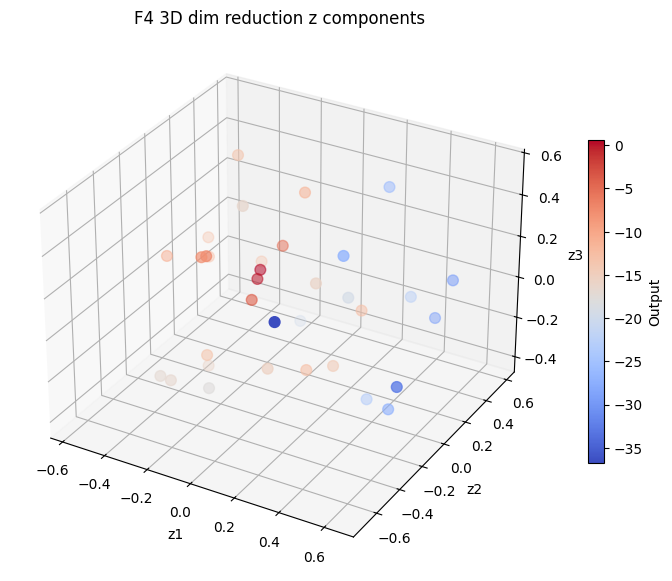

In [126]:
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(f4_inputs_3d[:,0], f4_inputs_3d[:,1], f4_inputs_3d[:,2], 
                c=f4_outputs, cmap='coolwarm', s=60)

ax.set_xlabel("z1")
ax.set_ylabel("z2")
ax.set_zlabel("z3")
ax.set_title("F4 3D dim reduction z components")
cbar = fig.colorbar(sc, ax=ax, shrink=0.6)
cbar.set_label("Output")
plt.show()

No local minima are observed but rather a cluster of values close to the maximum. 

I wanted to explore using a neural network this week, but given the results I think there is still some value in using a Gaussian process as a surrogate function once again considering the new extreme data point from last week.

Let's first explore where the furthest point lies now.

In [127]:
num_restarts = 250

for _ in range(num_restarts):
    res = minimize(objective_function, initial_guess, args=(f4_inputs,), bounds=bounds, method='L-BFGS-B')
    results.append(res)

# The resulting point is the one furthest from all known points
next_point = min(results, key=lambda r: r.fun).x

print("Current furthest point from known data:", next_point)

Current furthest point from known data: [0.57193085 1.         1.         0.        ]


No need to explore another corner. Let's use a GP with a Matern kernel and a softer nu. Still UCB, with a heavily exploratory kappa parameter.

In [128]:
dims = 4

kernel = (C(1.0, (1e-3, 1e3)) * Matern(length_scale=[2.0]*dims, length_scale_bounds=(0.1, 1000.0), nu=1.5) + WhiteKernel(noise_level=1e-6, noise_level_bounds=(1e-15, 1e-1)))
gp = GaussianProcessRegressor(
        kernel=kernel,
        alpha=1e-6,
        normalize_y=True,
        n_restarts_optimizer=30,
        random_state=42
    )
gp.fit(f4_inputs, f4_outputs)
print(gp.kernel_)

def negative_ucb(x, gp, kappa):
    mu, sigma = gp.predict(x.reshape(1, -1), return_std=True)
    return -(mu[0] + kappa * sigma[0])

bounds = [(0, 1) for _ in range(dims)]
num_restarts = 50 
results = []
np.random.seed(42)

for _ in range(num_restarts):
    x0 = np.random.uniform(0, 1, dims)
    result = minimize(negative_ucb, x0=np.random.uniform(0, 1, dims), 
                 args=(gp, 3.5), bounds=bounds, method='L-BFGS-B')
    if result.success:
        results.append(result)
    
# Select best solution from restarts
next_point = min(results, key=lambda r: r.fun).x

print(f"Current best: {np.max(f4_outputs):.4f}")
print(f"Inputs producing current best: {f4_inputs[np.argmax(f4_outputs)]}")
print("Next sample point (local optimizer):", next_point)
print("-".join(f"{x:.6f}" for x in next_point.flatten()))

4.6**2 * Matern(length_scale=[3.57, 3.14, 3.2, 3.31], nu=1.5) + WhiteKernel(noise_level=0.000542)
Current best: 0.6231
Inputs producing current best: [0.413793 0.413793 0.344828 0.413793]
Next sample point (local optimizer): [0.3056165  0.43474574 0.45680304 0.47334119]
0.305616-0.434746-0.456803-0.473341


Submission for week 5: 0.305616-0.434746-0.456803-0.473341

### Week 6

In [129]:
#Load points to inputs and outputs from previous week
function = 4
week = 5 #previous

row = results_df[(results_df['week'] == week) & (results_df['function'] == function)]
f4_inputs = np.vstack([f4_inputs, row['provided_input'].values[0]])
f4_outputs = np.append(f4_outputs, row['output'].values[0])

improved = row['submission_improved'].values[0]
print(f"Submission from last week improved something? {improved}")
print(f"Current best: {np.max(f4_outputs):.4f}")
print(f"Last week's results: {row['output'].values[0]:.4f}")
print('--')
print(f"Inputs shape: {f4_inputs.shape}")
print(f"Inputs range: [{np.min(f4_inputs):.4f}, {np.max(f4_inputs):.4f}]")
print(f"Performance range: [{np.min(f4_outputs):.4f}, {np.max(f4_outputs):.4f}]")

Submission from last week improved something? False
Current best: 0.6231
Last week's results: -1.9817
--
Inputs shape: (35, 4)
Inputs range: [0.0000, 1.0000]
Performance range: [-36.7685, 0.6231]


Last week's results were far from an improvement, actually improvement was found only on the first 2 weeks, so let us focus on what was done then and try to exploit around that point.

In [153]:
kernel = (C(1.0, (1e-3, 1e3)) * Matern(length_scale=[2.0]*4, length_scale_bounds=(0.1, 1000.0), nu=2.5) + WhiteKernel(noise_level=1e-6, noise_level_bounds=(1e-15, 1e-1)))
gp = GaussianProcessRegressor(
        kernel=kernel,
        alpha=1e-6,
        normalize_y=True,
        n_restarts_optimizer=30,
        random_state=42
    )
gp.fit(f4_inputs, f4_outputs)
print(gp.kernel_)

x1 = np.linspace(0, 1, 30)
x2 = np.linspace(0, 1, 30)
x3 = np.linspace(0, 1, 30)
x4 = np.linspace(0, 1, 30)
X1, X2, X3, X4 = np.meshgrid(x1, x2, x3, x4)
X_candidate = np.column_stack([X1.ravel(), X2.ravel(), X3.ravel(), X4.ravel()])

# Expected improvement
mu, sigma = gp.predict(X_candidate, return_std=True)
best = np.max(f4_outputs)
xi = 0.01
z = (mu - best - xi) / (sigma + 1e-12)
ei = (mu - best - xi) * stats.norm.cdf(z) + sigma * stats.norm.pdf(z)

best_idx = np.argmax(ei)
next_point = X_candidate[best_idx]

print(f"Current best: {np.max(f4_outputs):.4f}")
print(f"Inputs producing current best: {f4_inputs[np.argmax(f4_outputs)]}")
print("Next point to sample based on PI:", next_point)
print("-".join(f"{x:.6f}" for x in next_point.flatten()))

2.73**2 * Matern(length_scale=[1.52, 1.54, 1.43, 1.5], nu=2.5) + WhiteKernel(noise_level=0.00273)
Current best: 0.6231
Inputs producing current best: [0.413793 0.413793 0.344828 0.413793]
Next point to sample based on PI: [0.4137931  0.4137931  0.37931034 0.4137931 ]
0.413793-0.413793-0.379310-0.413793


Submission for week 6: 0.413793-0.413793-0.379310-0.413793

## Function 5

This function is a function with a 1D output and a 4D input. 

This is the description of the function: You’re tasked with optimising a four-variable black-box function that represents the yield of a chemical process in a factory. The function is typically unimodal, with a single peak where yield is maximised. 

Your goal is to find the optimal combination of chemical inputs that delivers the highest possible yield, using systematic exploration and optimisation methods.

### Week 1

In [130]:
print(f"Evaluations: {len(f5_inputs)}")
print(f"Inputs shape: {f5_inputs.shape}")
print(f"Inputs range: [{np.min(f5_inputs):.4f}, {np.max(f5_inputs):.4f}]")
print(f"Performance range: [{np.min(f5_outputs):.4f}, {np.max(f5_outputs):.4f}]")
print(f"Current best: {np.max(f5_outputs):.4f}")
print(f"Inputs producing current best: {f5_inputs[np.argmax(f5_outputs)]}")

Evaluations: 20
Inputs shape: (20, 4)
Inputs range: [0.0382, 0.9576]
Performance range: [0.1129, 1088.8596]
Current best: 1088.8596
Inputs producing current best: [0.22418902 0.84648049 0.87948418 0.87851568]


In [131]:
# Function is unimodal with a single peak, so I am choosing an RBF kernel
kernel = RBF(length_scale=[1.0] * 4, length_scale_bounds=(0.05, 15000.0)) 
gp = GaussianProcessRegressor(
    kernel=kernel,
    n_restarts_optimizer=15,
    alpha=1e-6, #modelling noise     
    normalize_y=True,
    random_state=42
)
gp.fit(f5_inputs, f5_outputs)

x1 = np.linspace(0, 1, 30)
x2 = np.linspace(0, 1, 30)
x3 = np.linspace(0, 1, 30)
x4 = np.linspace(0, 1, 30)
X1, X2, X3, X4 = np.meshgrid(x1, x2, x3, x4)
X_candidate = np.column_stack([X1.ravel(), X2.ravel(), X3.ravel(), X4.ravel()])

# Expected improvement
y_mean, y_std = gp.predict(X_candidate, return_std=True)

# The fact that the function has a single peak also makes me avoid PI, and a simple UCB should be fine
kappa = 2.0
UCB = y_mean + kappa * y_std 

max_idx = np.argmax(UCB)  # index of the maximum UCB
next_point = X_candidate[max_idx]  # coordinates in input space

print(f"Current best: {np.max(f5_outputs):.4f}")
print(f"Inputs producing current best: {f5_inputs[np.argmax(f5_outputs)]}")
print("Next point to sample based on UCB:", next_point)
print("-".join(f"{x:.6f}" for x in next_point.flatten()))

Current best: 1088.8596
Inputs producing current best: [0.22418902 0.84648049 0.87948418 0.87851568]
Next point to sample based on UCB: [0.5862069  0.62068966 1.         0.93103448]
0.586207-0.620690-1.000000-0.931034


Submission for week 1: 0.586207-0.620690-1.000000-0.931034

It is noted that I am one value at one of the bounds, will explore next week.

### Week 2

In [132]:
#Load points to inputs and outputs from previous week
function = 5
week = 1 #previous

row = results_df[(results_df['week'] == week) & (results_df['function'] == function)]
f5_inputs = np.vstack([f5_inputs, row['provided_input'].values[0]])
f5_outputs = np.append(f5_outputs, row['output'].values[0])

improved = row['submission_improved'].values[0]
print(f"Submission from last week improved something? {improved}")
print(f"Current best: {np.max(f5_outputs):.4f}")
print(f"Previous best: {results_df[(results_df['week'] == week-1) & (results_df['function'] == function)]['known_best'].values[0]:.4f}")
print(f"Last week's results: {row['output'].values[0]:.4f}")

Submission from last week improved something? True
Current best: 1687.3801
Previous best: 1088.8596
Last week's results: 1687.3801


This yielded a very good improvement, what this function maximum is is unknown.

Let's replicate again the same method this week

In [133]:
# Function is unimodal with a single peak, so I am choosing an RBF kernel
kernel = RBF(length_scale=[1.0] * 4, length_scale_bounds=(0.05, 15000.0)) 
gp = GaussianProcessRegressor(
    kernel=kernel,
    n_restarts_optimizer=15,
    alpha=1e-6, #modelling noise     
    normalize_y=True,
    random_state=42
)
gp.fit(f5_inputs, f5_outputs)

print(gp.kernel_)

x1 = np.linspace(0, 1, 30)
x2 = np.linspace(0, 1, 30)
x3 = np.linspace(0, 1, 30)
x4 = np.linspace(0, 1, 30)
X1, X2, X3, X4 = np.meshgrid(x1, x2, x3, x4)
X_candidate = np.column_stack([X1.ravel(), X2.ravel(), X3.ravel(), X4.ravel()])

# Expected improvement
y_mean, y_std = gp.predict(X_candidate, return_std=True)

# The fact that the function has a single peak also makes me avoid PI, and a simple UCB should be fine
kappa = 0.5
UCB = y_mean + kappa * y_std 

max_idx = np.argmax(UCB)  # index of the maximum UCB
next_point = X_candidate[max_idx]  # coordinates in input space

print(f"Current best: {np.max(f5_outputs):.4f}")
print(f"Inputs producing current best: {f5_inputs[np.argmax(f5_outputs)]}")
print("Next point to sample based on UCB:", next_point)

RBF(length_scale=[11.3, 5.31, 0.513, 0.209])
Current best: 1687.3801
Inputs producing current best: [0.586207 0.62069  1.       0.931034]
Next point to sample based on UCB: [1. 0. 1. 1.]


This would be encouraging sampling on a corner. While I may try this once, I will first try for this week's submission:
* Reducing the boundaries so that extreme values are not suggested.
* A denser mesh as 4 dimensions is still manageable.
* A penalty for being close to the borders (not linear but harsh around the border)

In [134]:
# If you want to avoid sampling exactly at the edges
x1 = np.linspace(0.05, 0.95, 50)
x2 = np.linspace(0.05, 0.95, 50)
x3 = np.linspace(0.05, 0.95, 50)
x4 = np.linspace(0.05, 0.95, 50)
X1, X2, X3, X4 = np.meshgrid(x1, x2, x3, x4)
X_candidate = np.column_stack([X1.ravel(), X2.ravel(), X3.ravel(), X4.ravel()])

y_mean, y_std = gp.predict(X_candidate, return_std=True)

kappa = 0.5
UCB = y_mean + kappa * y_std
#edge_penalty = 0.5 * ((X_candidate < 0.07) | (X_candidate > 0.93)).sum(axis=1)
#UCB_adjusted = UCB - edge_penalty

# Let's add a penalty for getting close to the borders
# Calculate distance to nearest boundary for each dimension (0 and 1 here)
min_boundary_distance = np.minimum(np.min(X_candidate, axis=1), np.min(1 - X_candidate, axis=1))
min_boundary_distance.shape

# Penalty factor: linearly scale with distance from boundary (0 at boundary, 1 at distance >= penalty_radius)
penalty_radius = 0.1
penalty_factor = np.clip(min_boundary_distance / penalty_radius, 0, 1)

# Apply penalty
UCB_penalized = UCB * penalty_factor

max_idx = np.argmax(UCB_penalized)
next_point_2 = X_candidate[max_idx]

print(f"Current best: {np.max(f5_outputs):.4f}")
print(f"Inputs producing current best: {f5_inputs[np.argmax(f5_outputs)]}")
print("Next point to sample based on UCB:", next_point_2)

Current best: 1687.3801
Inputs producing current best: [0.586207 0.62069  1.       0.931034]
Next point to sample based on UCB: [0.89489796 0.10510204 0.89489796 0.89489796]


Considering this, I will choose to sample the extreme this week and, depending on the result, reevaluate next week.

In [135]:
print("Next point to sample based on UCB:", next_point_2)
print("-".join(f"{x:.6f}" for x in next_point_2.flatten()))

Next point to sample based on UCB: [0.89489796 0.10510204 0.89489796 0.89489796]
0.894898-0.105102-0.894898-0.894898


Submission for week 2: 0.894898-0.105102-0.894898-0.894898

### Week 3

In [136]:
#Load points to inputs and outputs from previous week
function = 5
week = 2 #previous

row = results_df[(results_df['week'] == week) & (results_df['function'] == function)]
f5_inputs = np.vstack([f5_inputs, row['provided_input'].values[0]])
f5_outputs = np.append(f5_outputs, row['output'].values[0])

improved = row['submission_improved'].values[0]
print(f"Submission from last week improved something? {improved}")
print(f"Current best: {np.max(f5_outputs):.4f}")
print(f"Last week's results: {row['output'].values[0]:.4f}")
print('--')
print(f"Inputs shape: {f5_inputs.shape}")
print(f"Inputs range: [{np.min(f5_inputs):.4f}, {np.max(f5_inputs):.4f}]")
print(f"Performance range: [{np.min(f5_outputs):.4f}, {np.max(f5_outputs):.4f}]")

Submission from last week improved something? False
Current best: 1687.3801
Last week's results: 1488.8645
--
Inputs shape: (22, 4)
Inputs range: [0.0382, 1.0000]
Performance range: [0.1129, 1687.3801]


In [137]:
#Switching to Mattern kernel
 
kernel = C(1.0, (1e-3, 1e3)) * Matern(length_scale=[0.2]*4, nu=2.5) \
         + WhiteKernel(noise_level=1e-6, noise_level_bounds=(1e-8, 1e0))
gp = GaussianProcessRegressor(
        kernel=kernel,
        alpha=1e-6,
        normalize_y=True,
        n_restarts_optimizer=30,
        random_state=42
    )
gp.fit(f4_inputs, f4_outputs)
print(gp.kernel_)

def negative_ucb(x, gp, kappa):
    mu, sigma = gp.predict(x.reshape(1, -1), return_std=True)
    return -(mu[0] + kappa * sigma[0])

bounds = [(0, 1) for _ in range(4)]
num_restarts = 50
results = []
np.random.seed(42)

for _ in range(num_restarts):
    x0 = np.random.uniform(0, 1, 4)
    #choosing kappa 2.7 
    result = minimize(negative_ucb, x0=np.random.uniform(0, 1, 4), 
                 args=(gp, 2.7), bounds=bounds, method='L-BFGS-B')
    if result.success:
        results.append(result)
    
# Select best solution from restarts
next_point = min(results, key=lambda r: r.fun).x

print(f"Current best: {np.max(f5_outputs):.4f}")
print(f"Inputs producing current best: {f5_inputs[np.argmax(f5_outputs)]}")
print("Next sample point (local optimizer):", next_point)
print("-".join(f"{x:.6f}" for x in next_point.flatten()))

2.73**2 * Matern(length_scale=[1.52, 1.54, 1.43, 1.5], nu=2.5) + WhiteKernel(noise_level=0.00273)
Current best: 1687.3801
Inputs producing current best: [0.586207 0.62069  1.       0.931034]
Next sample point (local optimizer): [0.42620665 0.38417577 0.38945932 0.42437136]
0.426207-0.384176-0.389459-0.424371


Submission for week 3: 0.452640-0.433354-0.202919-0.441704

### Week 4

In [138]:
#Load points to inputs and outputs from previous week
function = 5
week = 3 #previous

row = results_df[(results_df['week'] == week) & (results_df['function'] == function)]
f5_inputs = np.vstack([f5_inputs, row['provided_input'].values[0]])
f5_outputs = np.append(f5_outputs, row['output'].values[0])

improved = row['submission_improved'].values[0]
print(f"Submission from last week improved something? {improved}")
print(f"Current best: {np.max(f5_outputs):.4f}")
print(f"Last week's results: {row['output'].values[0]:.4f}")
print('--')
print(f"Inputs shape: {f5_inputs.shape}")
print(f"Inputs range: [{np.min(f5_inputs):.4f}, {np.max(f5_inputs):.4f}]")
print(f"Performance range: [{np.min(f5_outputs):.4f}, {np.max(f5_outputs):.4f}]")

Submission from last week improved something? False
Current best: 1687.3801
Last week's results: 86.6569
--
Inputs shape: (23, 4)
Inputs range: [0.0382, 1.0000]
Performance range: [0.1129, 1687.3801]


This is not an improvement, but this allows me to capture yet another datapoint that will be useful.

I am choosing to apply the same methodology once again this week, but reverting to an RBF kernel.

In [139]:
#Switching to Mattern kernel

kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale=[1.0] * 4, length_scale_bounds=(0.05, 15000.0)) 
#kernel = C(1.0, (1e-3, 1e3)) * Matern(length_scale=[0.2]*4, nu=2.5) \
#         + WhiteKernel(noise_level=1e-6, noise_level_bounds=(1e-8, 1e0))
gp = GaussianProcessRegressor(
        kernel=kernel,
        alpha=1e-6,
        normalize_y=True,
        n_restarts_optimizer=30,
        random_state=42
    )
gp.fit(f4_inputs, f4_outputs)
print(gp.kernel_)

def negative_ucb(x, gp, kappa):
    mu, sigma = gp.predict(x.reshape(1, -1), return_std=True)
    return -(mu[0] + kappa * sigma[0])

bounds = [(0, 1) for _ in range(4)]
num_restarts = 150
results = []
np.random.seed(42)

for _ in range(num_restarts):
    x0 = np.random.uniform(0, 1, 4)
    #choosing kappa 1.5
    result = minimize(negative_ucb, x0=np.random.uniform(0, 1, 4), 
                 args=(gp, 1.5), bounds=bounds, method='L-BFGS-B')
    if result.success:
        results.append(result)
    
# Select best solution from restarts
next_point = min(results, key=lambda r: r.fun).x

print(f"Current best: {np.max(f5_outputs):.4f}")
print(f"Inputs producing current best: {f5_inputs[np.argmax(f5_outputs)]}")
print("Next sample point (local optimizer):", next_point)
print("-".join(f"{x:.6f}" for x in next_point.flatten()))

1.39**2 * RBF(length_scale=[0.757, 0.565, 0.312, 0.624])
Current best: 1687.3801
Inputs producing current best: [0.586207 0.62069  1.       0.931034]
Next sample point (local optimizer): [0.46329134 0.3764285  0.28869506 0.37979577]
0.463291-0.376429-0.288695-0.379796


Submission for week 4: 0.017701-0.472569-0.492069-0.597183

### Week 5

In [140]:
#Load points to inputs and outputs from previous week
function = 5
week = 4 #previous

row = results_df[(results_df['week'] == week) & (results_df['function'] == function)]
f5_inputs = np.vstack([f5_inputs, row['provided_input'].values[0]])
f5_outputs = np.append(f5_outputs, row['output'].values[0])

improved = row['submission_improved'].values[0]
print(f"Submission from last week improved something? {improved}")
print(f"Current best: {np.max(f5_outputs):.4f}")
print(f"Last week's results: {row['output'].values[0]:.4f}")
print('--')
print(f"Inputs shape: {f5_inputs.shape}")
print(f"Inputs range: [{np.min(f5_inputs):.4f}, {np.max(f5_inputs):.4f}]")
print(f"Performance range: [{np.min(f5_outputs):.4f}, {np.max(f5_outputs):.4f}]")

Submission from last week improved something? False
Current best: 1687.3801
Last week's results: 37.1313
--
Inputs shape: (24, 4)
Inputs range: [0.0177, 1.0000]
Performance range: [0.1129, 1687.3801]


In [141]:
f5_inputs_outputs = np.hstack([f5_inputs, f5_outputs.reshape(f5_inputs.shape[0],1)])
#print(f5_inputs_outputs)

print(f"Correlation between inputs and with outputs (last column): \n{np.corrcoef(f5_inputs_outputs, rowvar=False)}")

Correlation between inputs and with outputs (last column): 
[[ 1.         -0.26047977  0.0209165   0.15864518  0.19043415]
 [-0.26047977  1.         -0.15942968  0.15756671  0.07716471]
 [ 0.0209165  -0.15942968  1.          0.0898764   0.59754565]
 [ 0.15864518  0.15756671  0.0898764   1.          0.58891962]
 [ 0.19043415  0.07716471  0.59754565  0.58891962  1.        ]]


Results were better with a RBF kernel. Function is unimodal and there is a single peak.

In [142]:
# Function is unimodal with a single peak, so I am choosing an RBF kernel
kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale=[1.0] * 4, length_scale_bounds=(0.05, 15000.0)) 
gp = GaussianProcessRegressor(
    kernel=kernel,
    n_restarts_optimizer=25,
    alpha=1e-6, #modelling noise     
    normalize_y=True,
    random_state=42
)
gp.fit(f5_inputs, f5_outputs)

print(gp.kernel_)

x1 = np.linspace(0, 1, 30)
x2 = np.linspace(0, 1, 30)
x3 = np.linspace(0, 1, 30)
x4 = np.linspace(0, 1, 30)
X1, X2, X3, X4 = np.meshgrid(x1, x2, x3, x4)
X_candidate = np.column_stack([X1.ravel(), X2.ravel(), X3.ravel(), X4.ravel()])

# Expected improvement
y_mean, y_std = gp.predict(X_candidate, return_std=True)

# The fact that the function has a single peak also makes me avoid PI, and a simple UCB should be fine
kappa = 0.3
UCB = y_mean + kappa * y_std 

max_idx = np.argmax(UCB)  # index of the maximum UCB
next_point = X_candidate[max_idx]  # coordinates in input space

print(f"Current best: {np.max(f5_outputs):.4f}")
print(f"Inputs producing current best: {f5_inputs[np.argmax(f5_outputs)]}")
print("Next point to sample based on UCB:", next_point)
print("-".join(f"{x:.6f}" for x in next_point.flatten()))

1.08**2 * RBF(length_scale=[6.94, 2.93, 0.555, 0.152])
Current best: 1687.3801
Inputs producing current best: [0.586207 0.62069  1.       0.931034]
Next point to sample based on UCB: [1.         0.         1.         0.96551724]
1.000000-0.000000-1.000000-0.965517


Submission for week 5: 1.000000-0.000000-1.000000-0.965517

### Week 6

In [143]:
#Load points to inputs and outputs from previous week
function = 5
week = 5 #previous

row = results_df[(results_df['week'] == week) & (results_df['function'] == function)]
f5_inputs = np.vstack([f5_inputs, row['provided_input'].values[0]])
f5_outputs = np.append(f5_outputs, row['output'].values[0])

improved = row['submission_improved'].values[0]
print(f"Submission from last week improved something? {improved}")
print(f"Current best: {np.max(f5_outputs):.4f}")
print(f"Last week's results: {row['output'].values[0]:.4f}")
print('--')
print(f"Inputs shape: {f5_inputs.shape}")
print(f"Inputs range: [{np.min(f5_inputs):.4f}, {np.max(f5_inputs):.4f}]")
print(f"Performance range: [{np.min(f5_outputs):.4f}, {np.max(f5_outputs):.4f}]")

Submission from last week improved something? True
Current best: 3997.5415
Last week's results: 3997.5415
--
Inputs shape: (25, 4)
Inputs range: [0.0000, 1.0000]
Performance range: [0.1129, 3997.5415]


Last week marked a dramatic improvement of the output, peaking at almost 4000 from a previous known best of 1687 from week 1.

The RBF kernel seems most adapted to the unimodal underlying function, so for this week I am choosing to replicate the methodology to fully exploit its potential.

In [154]:
# Function is unimodal with a single peak, so I am choosing an RBF kernel
kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale=[1.0] * 4, length_scale_bounds=(0.05, 15000.0)) 
gp = GaussianProcessRegressor(
    kernel=kernel,
    n_restarts_optimizer=25,
    alpha=1e-6, #modelling noise     
    normalize_y=True,
    random_state=42
)
gp.fit(f5_inputs, f5_outputs)

print(gp.kernel_)

x1 = np.linspace(0, 1, 30)
x2 = np.linspace(0, 1, 30)
x3 = np.linspace(0, 1, 30)
x4 = np.linspace(0, 1, 30)
X1, X2, X3, X4 = np.meshgrid(x1, x2, x3, x4)
X_candidate = np.column_stack([X1.ravel(), X2.ravel(), X3.ravel(), X4.ravel()])

# Expected improvement
y_mean, y_std = gp.predict(X_candidate, return_std=True)

# The fact that the function has a single peak also makes me avoid PI, and a simple UCB should be fine
kappa = 0.3
UCB = y_mean + kappa * y_std 

max_idx = np.argmax(UCB)  # index of the maximum UCB
next_point = X_candidate[max_idx]  # coordinates in input space

print(f"Current best: {np.max(f5_outputs):.4f}")
print(f"Inputs producing current best: {f5_inputs[np.argmax(f5_outputs)]}")
print("Next point to sample based on UCB:", next_point)
print("-".join(f"{x:.6f}" for x in next_point.flatten()))

2.35**2 * RBF(length_scale=[0.416, 15.9, 0.269, 3.47])
Current best: 3997.5415
Inputs producing current best: [1.       0.       1.       0.965517]
Next point to sample based on UCB: [1. 1. 1. 1.]
1.000000-1.000000-1.000000-1.000000


The next sampling point is indeed a corner, but given the observed results in the corners, I believe it must be tested.

Please note that for the variable x2 we are shifting radically from 0 to 1 whereas for the other variables we are still maxing them out.

Submission for week 6: 1.000000-1.000000-1.000000-1.000000

## Function 6

This function is a function with a 1D output and a 5D input. 

This is the description of the function: You’re optimising a cake recipe using a black-box function with five ingredient inputs, for example flour, sugar, eggs, butter and milk. Each recipe is evaluated with a combined score based on flavour, consistency, calories, waste and cost, where each factor contributes negative points as judged by an expert taster. This means the total score is negative by design. 

To frame this as a maximisation problem, your goal is to bring that score as close to zero as possible or, equivalently, to maximise the negative of the total sum.

### Week 1


In [144]:
print(f"Evaluations: {len(f6_inputs)}")
print(f"Inputs shape: {f6_inputs.shape}")
print(f"Inputs range: [{np.min(f6_inputs):.4f}, {np.max(f6_inputs):.4f}]")
print(f"Performance range: [{np.min(f6_outputs):.4f}, {np.max(f6_outputs):.4f}]")
print(f"Current best: {np.max(f6_outputs):.4f}")
print(f"Inputs producing current best: {f6_inputs[np.argmax(f6_outputs)]}")


Evaluations: 20
Inputs shape: (20, 5)
Inputs range: [0.0049, 0.9788]
Performance range: [-2.5712, -0.7143]
Current best: -0.7143
Inputs producing current best: [0.7281861  0.15469257 0.73255167 0.69399651 0.05640131]


In [145]:
kernel = RBF(length_scale=[1.0] * 5, length_scale_bounds=(0.05, 15000.0)) 
gp = GaussianProcessRegressor(
    kernel=kernel,
    n_restarts_optimizer=15,
    alpha=1e-6, #modelling noise     
    normalize_y=True,
    random_state=42
)
gp.fit(f6_inputs, f6_outputs)

x1 = np.linspace(0, 1, 30)
x2 = np.linspace(0, 1, 30)
x3 = np.linspace(0, 1, 30)
x4 = np.linspace(0, 1, 30)
x5 = np.linspace(0, 1, 30)
X1, X2, X3, X4, X5 = np.meshgrid(x1, x2, x3, x4, x5)
X_candidate = np.column_stack([X1.ravel(), X2.ravel(), X3.ravel(), X4.ravel(), X5.ravel()])

# Expected improvement
y_mean, y_std = gp.predict(X_candidate, return_std=True)

# The fact that the function has a single peak also makes me avoid PI, and a simple UCB should be fine
kappa = 2.0
UCB = y_mean + kappa * y_std 

max_idx = np.argmax(UCB)  # index of the maximum UCB
next_point = X_candidate[max_idx]  # coordinates in input space

print(f"Current best: {np.max(f6_outputs):.4f}")
print(f"Inputs producing current best: {f6_inputs[np.argmax(f6_outputs)]}")
print("Next point to sample based on UCB:", next_point)
print("-".join(f"{x:.6f}" for x in next_point.flatten()))

Current best: -0.7143
Inputs producing current best: [0.7281861  0.15469257 0.73255167 0.69399651 0.05640131]
Next point to sample based on UCB: [0.         0.65517241 0.10344828 0.93103448 0.27586207]
0.000000-0.655172-0.103448-0.931034-0.275862


Submission for week 1 0.000000-0.655172-0.103448-0.931034-0.275862

It is noted that I am one value at one of the bounds, will explore next week.

### Week 2

In [146]:
#Load points to inputs and outputs from previous week
function = 6
week = 1 #previous

row = results_df[(results_df['week'] == week) & (results_df['function'] == function)]
f6_inputs = np.vstack([f6_inputs, row['provided_input'].values[0]])
f6_outputs = np.append(f6_outputs, row['output'].values[0])

improved = row['submission_improved'].values[0]
print(f"Submission from last week improved something? {improved}")
print(f"Current best: {np.max(f6_outputs):.4f}")
print(f"Previous best: {results_df[(results_df['week'] == week-1) & (results_df['function'] == function)]['known_best'].values[0]:.4f}")
print(f"Last week's results: {row['output'].values[0]:.4f}")

Submission from last week improved something? False
Current best: -0.7143
Previous best: -0.7143
Last week's results: -1.5297


The ideal score is zero, which we are still far from.

In [147]:
print(f"Correlation between inputs: \n{np.corrcoef(f6_inputs, rowvar=False)}\n")

print('Means:', f6_inputs.mean(axis=0))
print('Stds:', f6_inputs.std(axis=0))
print('Mins:', f6_inputs.min(axis=0))
print('Maxs:', f6_inputs.max(axis=0))
print('Std/Mean Ratios:', f6_inputs.std(axis=0) / (f6_inputs.mean(axis=0) + 1e-12))

Correlation between inputs: 
[[ 1.         -0.29176338  0.05124239  0.0396322  -0.36709432]
 [-0.29176338  1.          0.28740693 -0.11473402  0.20578552]
 [ 0.05124239  0.28740693  1.          0.09729636 -0.08116774]
 [ 0.0396322  -0.11473402  0.09729636  1.         -0.23027136]
 [-0.36709432  0.20578552 -0.08116774 -0.23027136  1.        ]]

Means: [0.52168136 0.56697966 0.44989434 0.55331838 0.41670327]
Stds: [0.31093551 0.27049323 0.30974597 0.27963917 0.28444111]
Mins: [0.         0.11440374 0.0165229  0.04561319 0.0049115 ]
Maxs: [0.95773967 0.93187122 0.97880576 0.96165559 0.89281919]
Std/Mean Ratios: [0.59602572 0.47707749 0.68848602 0.50538565 0.6825987 ]


Let's try to get a better fit of a surrogate function and willingly limit the upper bound of length scale, and a smaller kappa for UCB.

In [148]:
# Function is unimodal with a single peak, so I am choosing an RBF kernel
kernel = RBF(length_scale=[1.0] * 5, length_scale_bounds=(0.05, 15)) 
gp = GaussianProcessRegressor(
    kernel=kernel,
    n_restarts_optimizer=15,
    alpha=1e-6, #modelling noise     
    normalize_y=True,
    random_state=42
)
gp.fit(f6_inputs, f6_outputs)
print(gp.kernel_)

x1 = np.linspace(0, 1, 30)
x2 = np.linspace(0, 1, 30)
x3 = np.linspace(0, 1, 30)
x4 = np.linspace(0, 1, 30)
x5 = np.linspace(0, 1, 30)
X1, X2, X3, X4, X5 = np.meshgrid(x1, x2, x3, x4, x5)
X_candidate = np.column_stack([X1.ravel(), X2.ravel(), X3.ravel(), X4.ravel(), X5.ravel()])

# Expected improvement
y_mean, y_std = gp.predict(X_candidate, return_std=True)

# The fact that the function has a single peak also makes me avoid PI, and a simple UCB should be fine
kappa = 0.5
UCB = y_mean + kappa * y_std 

max_idx = np.argmax(UCB)  # index of the maximum UCB
next_point = X_candidate[max_idx]  # coordinates in input space

print(f"Current best: {np.max(f6_outputs):.4f}")
print(f"Inputs producing current best: {f6_inputs[np.argmax(f6_outputs)]}")
print("Next point to sample based on UCB:", next_point)
print("-".join(f"{x:.6f}" for x in next_point.flatten()))

#print(f6_inputs)

RBF(length_scale=[0.293, 0.589, 0.579, 0.631, 0.472])
Current best: -0.7143
Inputs producing current best: [0.7281861  0.15469257 0.73255167 0.69399651 0.05640131]
Next point to sample based on UCB: [0.51724138 0.31034483 0.51724138 0.86206897 0.10344828]
0.517241-0.310345-0.517241-0.862069-0.103448


Submission for week 2: 0.517241-0.310345-0.517241-0.862069-0.103448

### Week 3

In [149]:
#Load points to inputs and outputs from previous week
function = 6
week = 2 #previous

row = results_df[(results_df['week'] == week) & (results_df['function'] == function)]
f6_inputs = np.vstack([f6_inputs, row['provided_input'].values[0]])
f6_outputs = np.append(f6_outputs, row['output'].values[0])

improved = row['submission_improved'].values[0]
print(f"Submission from last week improved something? {improved}")
print(f"Current best: {np.max(f6_outputs):.4f}")
print(f"Last week's results: {row['output'].values[0]:.4f}")
print('--')
print(f"Inputs shape: {f6_inputs.shape}")
print(f"Inputs range: [{np.min(f6_inputs):.4f}, {np.max(f6_inputs):.4f}]")
print(f"Performance range: [{np.min(f6_outputs):.4f}, {np.max(f6_outputs):.4f}]")

Submission from last week improved something? True
Current best: -0.4072
Last week's results: -0.4072
--
Inputs shape: (22, 5)
Inputs range: [0.0000, 0.9788]
Performance range: [-2.5712, -0.4072]


In [150]:
kernel = RBF(length_scale=[1.0] * 5, length_scale_bounds=(0.05, 15)) 
gp = GaussianProcessRegressor(
        kernel=kernel,
        alpha=1e-6,
        normalize_y=True,
        n_restarts_optimizer=30,
        random_state=42
    )
gp.fit(f6_inputs, f6_outputs)
print(gp.kernel_)

def negative_ucb(x, gp, kappa):
    mu, sigma = gp.predict(x.reshape(1, -1), return_std=True)
    return -(mu[0] + kappa * sigma[0])

def neg_ei(x):
    x = np.array(x).reshape(1, -1)
    mean, std = gp.predict(x, return_std=True)
    # Current best observation
    best_y = np.max(f6_outputs)
    # Calculate EI
    z = (mean - best_y) / (std + 1e-9)
    ei = (mean - best_y) * normal_dist.cdf(z) + std * normal_dist.pdf(z)
    return -ei.item()  


bounds = [(0, 1) for _ in range(5)]
num_restarts = 100
results = []
np.random.seed(42)

for _ in range(num_restarts):
    #choosing kappa 2.7 
    result = minimize(negative_ucb, x0=np.random.uniform(0, 1, 5), 
                 args=(gp, 2.7), bounds=bounds, method='L-BFGS-B')
    if result.success:
        results.append(result)
    
# Select best solution from restarts
next_point = min(results, key=lambda r: r.fun).x
print("Next sample point (local optimizer) based on UCB:", next_point)

num_restarts = 50
results = []
np.random.seed(42)

for _ in range(num_restarts):
    #choosing kappa 2.7 
    result = minimize(neg_ei, x0=np.random.uniform(0, 1, 5), 
                 bounds=bounds, method='L-BFGS-B')
    if result.success:
        results.append(result)

next_point = min(results, key=lambda r: r.fun).x

print(f"Current best: {np.max(f6_outputs):.4f}")
print(f"Inputs producing current best: {f6_inputs[np.argmax(f6_outputs)]}")
print("Next sample point (local optimizer) based on EI:", next_point)

print("-".join(f"{x:.6f}" for x in next_point.flatten()))

RBF(length_scale=[0.33, 0.613, 0.643, 0.713, 0.494])
Next sample point (local optimizer) based on UCB: [0.44241216 0.         0.94144043 1.         0.37157669]
Current best: -0.4072
Inputs producing current best: [0.517241 0.310345 0.517241 0.862069 0.103448]
Next sample point (local optimizer) based on EI: [0.49377504 0.26643941 0.66532923 1.         0.26642546]
0.493775-0.266439-0.665329-1.000000-0.266425


I choose the EI point.

Submission for week 3: 0.493775-0.266439-0.665329-1.000000-0.266425

### Week 4

In [151]:
#Load points to inputs and outputs from previous week
function = 6
week = 3 #previous

row = results_df[(results_df['week'] == week) & (results_df['function'] == function)]
f6_inputs = np.vstack([f6_inputs, row['provided_input'].values[0]])
f6_outputs = np.append(f6_outputs, row['output'].values[0])

improved = row['submission_improved'].values[0]
print(f"Submission from last week improved something? {improved}")
print(f"Current best: {np.max(f6_outputs):.4f}")
print(f"Last week's results: {row['output'].values[0]:.4f}")
print('--')
print(f"Inputs shape: {f6_inputs.shape}")
print(f"Inputs range: [{np.min(f6_inputs):.4f}, {np.max(f6_inputs):.4f}]")
print(f"Performance range: [{np.min(f6_outputs):.4f}, {np.max(f6_outputs):.4f}]")

Submission from last week improved something? False
Current best: -0.4072
Last week's results: -0.6037
--
Inputs shape: (23, 5)
Inputs range: [0.0000, 1.0000]
Performance range: [-2.5712, -0.4072]


In [155]:
kernel = RBF(length_scale=[1.0] * 5, length_scale_bounds=(0.05, 15)) 
gp = GaussianProcessRegressor(
        kernel=kernel,
        alpha=1e-6,
        normalize_y=True,
        n_restarts_optimizer=30,
        random_state=42
    )
gp.fit(f6_inputs, f6_outputs)
print(gp.kernel_)

def negative_ucb(x, gp, kappa):
    mu, sigma = gp.predict(x.reshape(1, -1), return_std=True)
    return -(mu[0] + kappa * sigma[0])

def neg_ei(x):
    x = np.array(x).reshape(1, -1)
    mean, std = gp.predict(x, return_std=True)
    # Current best observation
    best_y = np.max(f6_outputs)
    # Calculate EI
    z = (mean - best_y) / (std + 1e-9)
    ei = (mean - best_y) * normal_dist.cdf(z) + std * normal_dist.pdf(z)
    return -ei.item()  


bounds = [(0, 1) for _ in range(5)]
num_restarts = 100
results = []
np.random.seed(42)

for _ in range(num_restarts):
    #choosing kappa 2.7 
    result = minimize(negative_ucb, x0=np.random.uniform(0, 1, 5), 
                 args=(gp, 1.2), bounds=bounds, method='L-BFGS-B')
    if result.success:
        results.append(result)
    
# Select best solution from restarts
next_point_ucb = min(results, key=lambda r: r.fun).x
print("Next sample point (local optimizer) based on UCB:", next_point_ucb)

num_restarts = 200
results = []
np.random.seed(42)

for _ in range(num_restarts):
    result = minimize(neg_ei, x0=np.random.uniform(0, 1, 5), 
                 bounds=bounds, method='L-BFGS-B')
    if result.success:
        results.append(result)

next_point_ei = min(results, key=lambda r: r.fun).x

print(f"Current best: {np.max(f6_outputs):.4f}")
print(f"Inputs producing current best: {f6_inputs[np.argmax(f6_outputs)]}")
print("Next sample point (local optimizer) based on EI:", next_point_ei)

print("-".join(f"{x:.6f}" for x in next_point_ucb.flatten()))

RBF(length_scale=[0.315, 0.652, 0.597, 0.702, 0.602])
Next sample point (local optimizer) based on UCB: [0.48230954 0.41887081 0.20131047 0.98155948 0.        ]
Current best: -0.4072
Inputs producing current best: [0.517241 0.310345 0.517241 0.862069 0.103448]
Next sample point (local optimizer) based on EI: [0.49515943 0.36471021 0.27533901 0.9047034  0.        ]
0.482310-0.418871-0.201310-0.981559-0.000000


I choose the UCB estimate.

Submission for week 4: 0.482310-0.418871-0.201310-0.981559-0.000000

### Week 5

In [156]:
#Load points to inputs and outputs from previous week
function = 6
week = 4 #previous

row = results_df[(results_df['week'] == week) & (results_df['function'] == function)]
f6_inputs = np.vstack([f6_inputs, row['provided_input'].values[0]])
f6_outputs = np.append(f6_outputs, row['output'].values[0])

improved = row['submission_improved'].values[0]
print(f"Submission from last week improved something? {improved}")
print(f"Current best: {np.max(f6_outputs):.4f}")
print(f"Last week's results: {row['output'].values[0]:.4f}")
print('--')
print(f"Inputs shape: {f6_inputs.shape}")
print(f"Inputs range: [{np.min(f6_inputs):.4f}, {np.max(f6_inputs):.4f}]")
print(f"Performance range: [{np.min(f6_outputs):.4f}, {np.max(f6_outputs):.4f}]")

Submission from last week improved something? False
Current best: -0.4072
Last week's results: -0.9821
--
Inputs shape: (24, 5)
Inputs range: [0.0000, 1.0000]
Performance range: [-2.5712, -0.4072]


In [157]:
f6_inputs_outputs = np.hstack([f6_inputs, f6_outputs.reshape(f6_inputs.shape[0],1)])
#print(f6_inputs_outputs)

print(f"Correlation between inputs and with outputs (last column): \n{np.corrcoef(f6_inputs_outputs, rowvar=False)}")

Correlation between inputs and with outputs (last column): 
[[ 1.         -0.27059052  0.05156138  0.02208248 -0.33181016  0.06526544]
 [-0.27059052  1.          0.24309268 -0.2270691   0.27098474 -0.43023607]
 [ 0.05156138  0.24309268  1.          0.088738   -0.0483734   0.24019473]
 [ 0.02208248 -0.2270691   0.088738    1.         -0.33989986  0.60043338]
 [-0.33181016  0.27098474 -0.0483734  -0.33989986  1.         -0.61474447]
 [ 0.06526544 -0.43023607  0.24019473  0.60043338 -0.61474447  1.        ]]


Let us replicate what was done on week 2.

In [158]:
# Function is unimodal with a single peak, so I am choosing an RBF kernel
kernel = C(1.0, (1e-6, 1e6)) * RBF(length_scale=[1.0] * 5, length_scale_bounds=(0.05, 15)) 
gp = GaussianProcessRegressor(
    kernel=kernel,
    n_restarts_optimizer=15,
    alpha=1e-6, #modelling noise     
    normalize_y=True,
    random_state=42
)
gp.fit(f6_inputs, f6_outputs)
print(gp.kernel_)

x1 = np.linspace(0, 1, 30)
x2 = np.linspace(0, 1, 30)
x3 = np.linspace(0, 1, 30)
x4 = np.linspace(0, 1, 30)
x5 = np.linspace(0, 1, 30)
X1, X2, X3, X4, X5 = np.meshgrid(x1, x2, x3, x4, x5)
X_candidate = np.column_stack([X1.ravel(), X2.ravel(), X3.ravel(), X4.ravel(), X5.ravel()])

# Expected improvement
y_mean, y_std = gp.predict(X_candidate, return_std=True)

# The fact that the function has a single peak also makes me avoid PI, and a simple UCB should be fine
kappa = 0.3
UCB = y_mean + kappa * y_std 

max_idx = np.argmax(UCB)  # index of the maximum UCB
next_point = X_candidate[max_idx]  # coordinates in input space

print(f"Current best: {np.max(f6_outputs):.4f}")
print(f"Inputs producing current best: {f6_inputs[np.argmax(f6_outputs)]}")
print("Next point to sample based on UCB:", next_point)
print("-".join(f"{x:.6f}" for x in next_point.flatten()))

#print(f6_inputs)

0.988**2 * RBF(length_scale=[0.348, 0.591, 0.605, 0.478, 0.446])
Current best: -0.4072
Inputs producing current best: [0.517241 0.310345 0.517241 0.862069 0.103448]
Next point to sample based on UCB: [0.48275862 0.31034483 0.5862069  0.68965517 0.17241379]
0.482759-0.310345-0.586207-0.689655-0.172414


Submission for week 5: 0.241379-0.310345-0.689655-0.931034-0.103448

### Week 6

In [159]:
#Load points to inputs and outputs from previous week
function = 6
week = 5 #previous

row = results_df[(results_df['week'] == week) & (results_df['function'] == function)]
f6_inputs = np.vstack([f6_inputs, row['provided_input'].values[0]])
f6_outputs = np.append(f6_outputs, row['output'].values[0])

improved = row['submission_improved'].values[0]
print(f"Submission from last week improved something? {improved}")
print(f"Current best: {np.max(f6_outputs):.4f}")
print(f"Last week's results: {row['output'].values[0]:.4f}")
print('--')
print(f"Inputs shape: {f6_inputs.shape}")
print(f"Inputs range: [{np.min(f6_inputs):.4f}, {np.max(f6_inputs):.4f}]")
print(f"Performance range: [{np.min(f6_outputs):.4f}, {np.max(f6_outputs):.4f}]")

Submission from last week improved something? False
Current best: -0.4072
Last week's results: -0.4699
--
Inputs shape: (25, 5)
Inputs range: [0.0000, 1.0000]
Performance range: [-2.5712, -0.4072]


For this function I was only able to make an improvement on week 2.

Before switching to exploitation of the are with the most potential starting from week 7, let us try one last time the same kernel and UCB acquisition function as from week 2 as this week's submission.

In [190]:
# Function is unimodal with a single peak, so I am choosing an RBF kernel
kernel = RBF(length_scale=[1.0] * 5, length_scale_bounds=(0.05, 15)) 
gp = GaussianProcessRegressor(
    kernel=kernel,
    n_restarts_optimizer=15,
    alpha=1e-6, #modelling noise     
    normalize_y=True,
    random_state=42
)
gp.fit(f6_inputs, f6_outputs)
print(gp.kernel_)

x1 = np.linspace(0, 1, 30)
x2 = np.linspace(0, 1, 30)
x3 = np.linspace(0, 1, 30)
x4 = np.linspace(0, 1, 30)
x5 = np.linspace(0, 1, 30)
X1, X2, X3, X4, X5 = np.meshgrid(x1, x2, x3, x4, x5)
X_candidate = np.column_stack([X1.ravel(), X2.ravel(), X3.ravel(), X4.ravel(), X5.ravel()])

# Expected improvement
y_mean, y_std = gp.predict(X_candidate, return_std=True)

# The fact that the function has a single peak also makes me avoid PI, and a simple UCB should be fine
kappa = 0.5
UCB = y_mean + kappa * y_std 

max_idx = np.argmax(UCB)  # index of the maximum UCB
next_point = X_candidate[max_idx]  # coordinates in input space

print(f"Current best: {np.max(f6_outputs):.4f}")
print(f"Inputs producing current best: {f6_inputs[np.argmax(f6_outputs)]}")
print("Next point to sample based on UCB:", next_point)
print("-".join(f"{x:.6f}" for x in next_point.flatten()))

#print(f6_inputs)

c:\ml\.venv\Lib\site-packages\sklearn\gaussian_process\kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 15.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


RBF(length_scale=[15, 0.257, 0.477, 0.539, 0.365])
Current best: -0.4072
Inputs producing current best: [0.517241 0.310345 0.517241 0.862069 0.103448]
Next point to sample based on UCB: [1.         0.27586207 0.55172414 0.96551724 0.10344828]
1.000000-0.275862-0.551724-0.965517-0.103448


Submission for week 6: 1.000000-0.275862-0.551724-0.965517-0.103448

## Function 7

This function is a function with a 1D output and a 6D input. 

This is the description of the function: You’re tasked with optimising an ML model by tuning six hyperparameters, for example learning rate, regularisation strength or number of hidden layers. The function you’re maximising is the model’s performance score (such as accuracy or F1), but since the relationship between inputs and output isn’t known, it’s treated as a black-box function. 

Because this is a commonly used model, you might benefit from researching best practices or literature to guide your initial search space. Your goal is to find the combination of hyperparameters that yields the highest possible performance.

### Week 1

The problem statement is similar to function 2, but with more dimensions.

In [160]:
print(f"Evaluations: {len(f7_inputs)}")
print(f"Inputs shape: {f7_inputs.shape}")
print(f"Inputs range: [{np.min(f7_inputs):.4f}, {np.max(f7_inputs):.4f}]")
print(f"Performance range: [{np.min(f7_outputs):.4f}, {np.max(f7_outputs):.4f}]")
print(f"Current best: {np.max(f7_outputs):.4f}")
print(f"Inputs producing current best: {f7_inputs[np.argmax(f7_outputs)]}")

Evaluations: 30
Inputs shape: (30, 6)
Inputs range: [0.0036, 0.9987]
Performance range: [0.0027, 1.3650]
Current best: 1.3650
Inputs producing current best: [0.05789554 0.49167222 0.24742222 0.21811844 0.42042833 0.73096984]



There is not known relationship between the parameters and the output. I will try a combination of Mattern, Constant, RBF and White with UCB as adcquisition function.

In [161]:
kernel = (
    C(1.0, (1e-6, 1e6)) * (
        RBF([1.0]*6, length_scale_bounds=(1e-2, 1e10)) +
        Matern(length_scale=[1.0]*6, length_scale_bounds=(1e-2,1e13), nu=2.5)
    ) +
    WhiteKernel(noise_level=1e-6, noise_level_bounds=(1e-13, 1e-1))
)

gp = GaussianProcessRegressor(kernel=kernel,
                              alpha=1e-6,
                              normalize_y=True,
                              n_restarts_optimizer=20,
                              random_state=42)
gp.fit(f7_inputs, f7_outputs)

margin = 0.01  # avoid boundaries, previous function gave a 1 for one of the coordinates
#grid_points = 18 # to be able to lower it as we're exploring grip_points^6, 20 was giving memory errors
#axes = [np.linspace(margin, 1-margin, grid_points) for _ in range(6)]
#mesh = np.meshgrid(*axes) # instead of doing this 6 times
#X_candidates = np.column_stack([arr.ravel() for arr in mesh])

#y_mean, y_std = gp.predict(X_candidates, return_std=True)

# Random sampling approach to avoid memory issues
n_candidates = 1000000  # Much more manageable
np.random.seed(42)
X_candidates = np.random.uniform(
    low=margin, 
    high=1-margin, 
    size=(n_candidates, 6)
)

y_mean, y_std = gp.predict(X_candidates, return_std=True)

# UCB acquisition function
kappa = 2.5 
UCB = y_mean + kappa * y_std 

next_idx = np.argmax(UCB)
next_point = X_candidates[next_idx]

print(f"Current best: {np.max(f7_outputs):.4f}")
print(f"Inputs producing current best: {f7_inputs[np.argmax(f7_outputs)]}")
print("Next point to sample based on UCB:", next_point)
print("-".join(f"{x:.6f}" for x in next_point.flatten()))


Current best: 1.3650
Inputs producing current best: [0.05789554 0.49167222 0.24742222 0.21811844 0.42042833 0.73096984]
Next point to sample based on UCB: [0.02716027 0.21896654 0.42646816 0.05400693 0.33117913 0.87928519]
0.027160-0.218967-0.426468-0.054007-0.331179-0.879285


Submission for the week: 0.014182-0.276863-0.738085-0.053110-0.375860-0.799450

### Week 2

In [162]:
#Load points to inputs and outputs from previous week
function = 7
week = 1 #previous

row = results_df[(results_df['week'] == week) & (results_df['function'] == function)]
f7_inputs = np.vstack([f7_inputs, row['provided_input'].values[0]])
f7_outputs = np.append(f7_outputs, row['output'].values[0])

improved = row['submission_improved'].values[0]
print(f"Submission from last week improved something? {improved}")
print(f"Current best: {np.max(f7_outputs):.4f}")
print(f"Previous best: {results_df[(results_df['week'] == week-1) & (results_df['function'] == function)]['known_best'].values[0]:.4f}")
print(f"Last week's results: {row['output'].values[0]:.4f}")

Submission from last week improved something? True
Current best: 1.3671
Previous best: 1.3650
Last week's results: 1.3671


Marginal improvement as compared to last week.

In [163]:
print(f"Correlation between inputs: \n{np.corrcoef(f7_inputs, rowvar=False)}\n")

print('Means:', f7_inputs.mean(axis=0))
print('Stds:', f7_inputs.std(axis=0))
print('Mins:', f7_inputs.min(axis=0))
print('Maxs:', f7_inputs.max(axis=0))
print('Std/Mean Ratios:', f7_inputs.std(axis=0) / (f7_inputs.mean(axis=0) + 1e-12))

Correlation between inputs: 
[[ 1.         -0.05932647 -0.2631823  -0.07813924 -0.02080207 -0.47625634]
 [-0.05932647  1.         -0.07333109  0.17555352  0.32356517  0.17645491]
 [-0.2631823  -0.07333109  1.          0.15319327 -0.3075346   0.11607412]
 [-0.07813924  0.17555352  0.15319327  1.          0.07343282  0.00591408]
 [-0.02080207  0.32356517 -0.3075346   0.07343282  1.          0.09216416]
 [-0.47625634  0.17645491  0.11607412  0.00591408  0.09216416  1.        ]]

Means: [0.49483011 0.39196594 0.40085    0.49798995 0.46425415 0.49485686]
Stds: [0.3067955  0.24519753 0.30991936 0.3124758  0.30483809 0.26637916]
Mins: [0.014182   0.01181284 0.00363456 0.05311    0.01494418 0.05109986]
Maxs: [0.94245084 0.9246939  0.92457051 0.96101714 0.9986547  0.95101392]
Std/Mean Ratios: [0.62000168 0.62555827 0.77315544 0.62747411 0.65661899 0.53829539]


In [164]:
kernel = (
    C(1.0, (1e-2, 1e2)) * (
        RBF([1.0]*6, length_scale_bounds=(1e-2, 3)) +
        Matern(length_scale=[1.0]*6, length_scale_bounds=(1e-2,1e2), nu=2.5)
    ) +
    WhiteKernel(noise_level=1e-6, noise_level_bounds=(1e-13, 1e-1))
)

gp = GaussianProcessRegressor(kernel=kernel,
                              alpha=1e-6,
                              normalize_y=True,
                              n_restarts_optimizer=20,
                              random_state=42)
gp.fit(f7_inputs, f7_outputs)
print(gp.kernel_)

# Random sampling approach to avoid memory issues
n_candidates = 3000000  # Much more manageable
np.random.seed(42)
margin=0.01
X_candidates = np.random.uniform(
    low=margin, 
    high=1-margin, 
    size=(n_candidates, 6)
)

y_mean, y_std = gp.predict(X_candidates, return_std=True)

# UCB acquisition function
kappa = 0.5 
UCB = y_mean + kappa * y_std 

next_idx = np.argmax(UCB)
next_point = X_candidates[next_idx]

print(f"Current best: {np.max(f7_outputs):.4f}")
print(f"Inputs producing current best: {f7_inputs[np.argmax(f7_outputs)]}")
print("Next point to sample based on UCB:", next_point)
print("-".join(f"{x:.6f}" for x in next_point.flatten()))


c:\ml\.venv\Lib\site-packages\sklearn\gaussian_process\kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__length_scale is close to the specified upper bound 3.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\ml\.venv\Lib\site-packages\sklearn\gaussian_process\kernels.py:450: ConvergenceWarning: The optimal value found for dimension 2 of parameter k1__k2__k1__length_scale is close to the specified upper bound 3.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\ml\.venv\Lib\site-packages\sklearn\gaussian_process\kernels.py:450: ConvergenceWarning: The optimal value found for dimension 3 of parameter k1__k2__k1__length_scale is close to the specified upper bound 3.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\ml\.venv\Lib\site-packages\sklearn\gaussian_process\kernels.py:450: ConvergenceWarning: The optimal value 

0.664**2 * RBF(length_scale=[3, 0.594, 3, 3, 0.222, 0.0959]) + Matern(length_scale=[0.516, 100, 100, 0.762, 0.342, 100], nu=2.5) + WhiteKernel(noise_level=1.06e-09)
Current best: 1.3671
Inputs producing current best: [0.014182 0.276863 0.738085 0.05311  0.37586  0.79945 ]
Next point to sample based on UCB: [0.01697354 0.3240033  0.15462846 0.17254083 0.3889434  0.75889778]
0.016974-0.324003-0.154628-0.172541-0.388943-0.758898


Submission for week 2: 0.016974-0.324003-0.154628-0.172541-0.388943-0.758898

### Week 3

In [165]:
#Load points to inputs and outputs from previous week
function = 7
week = 2 #previous

row = results_df[(results_df['week'] == week) & (results_df['function'] == function)]
f7_inputs = np.vstack([f7_inputs, row['provided_input'].values[0]])
f7_outputs = np.append(f7_outputs, row['output'].values[0])

improved = row['submission_improved'].values[0]
print(f"Submission from last week improved something? {improved}")
print(f"Current best: {np.max(f7_outputs):.4f}")
print(f"Last week's results: {row['output'].values[0]:.4f}")
print('--')
print(f"Inputs shape: {f7_inputs.shape}")
print(f"Inputs range: [{np.min(f7_inputs):.4f}, {np.max(f7_inputs):.4f}]")
print(f"Performance range: [{np.min(f7_outputs):.4f}, {np.max(f7_outputs):.4f}]")

Submission from last week improved something? True
Current best: 1.5999
Last week's results: 1.5999
--
Inputs shape: (32, 6)
Inputs range: [0.0036, 0.9987]
Performance range: [0.0027, 1.5999]


The improvement is more significant this week. We can have another go at the same strategy once again.

In [166]:
kernel = (
    C(1.0, (1e-2, 1e2)) * (
        RBF([1.0]*6, length_scale_bounds=(1e-2, 15)) +
        Matern(length_scale=[1.0]*6, length_scale_bounds=(1e-2,250), nu=2.5)
    ) +
    WhiteKernel(noise_level=1e-6, noise_level_bounds=(1e-13, 1e-1))
)

gp = GaussianProcessRegressor(kernel=kernel,
                              alpha=1e-6,
                              normalize_y=True,
                              n_restarts_optimizer=20,
                              random_state=42)
gp.fit(f7_inputs, f7_outputs)
print(gp.kernel_)

def negative_ucb(x, gp, kappa):
    mu, sigma = gp.predict(x.reshape(1, -1), return_std=True)
    return -(mu[0] + kappa * sigma[0])


bounds = [(0, 1) for _ in range(6)]

n_candidates = 3000000  # Much more manageable
np.random.seed(42)
margin=0.01
X_candidates = np.random.uniform(
    low=margin, 
    high=1-margin, 
    size=(n_candidates, 6)
)

y_mean, y_std = gp.predict(X_candidates, return_std=True)

# UCB acquisition function
kappa = 0.5 
UCB = y_mean + kappa * y_std 

next_idx = np.argmax(UCB)
next_point = X_candidates[next_idx]

print(f"Current best: {np.max(f7_outputs):.4f}")
print(f"Inputs producing current best: {f7_inputs[np.argmax(f7_outputs)]}")
print("Next point to sample based on UCB:", next_point)
print("-".join(f"{x:.6f}" for x in next_point.flatten()))

c:\ml\.venv\Lib\site-packages\sklearn\gaussian_process\kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__length_scale is close to the specified upper bound 15.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\ml\.venv\Lib\site-packages\sklearn\gaussian_process\kernels.py:450: ConvergenceWarning: The optimal value found for dimension 2 of parameter k1__k2__k1__length_scale is close to the specified upper bound 15.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\ml\.venv\Lib\site-packages\sklearn\gaussian_process\kernels.py:450: ConvergenceWarning: The optimal value found for dimension 3 of parameter k1__k2__k1__length_scale is close to the specified upper bound 15.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\ml\.venv\Lib\site-packages\sklearn\gaussian_process\kernels.py:450: ConvergenceWarning: The optimal val

0.631**2 * RBF(length_scale=[15, 0.572, 15, 15, 0.227, 0.0823]) + Matern(length_scale=[0.534, 250, 2.43, 250, 0.39, 250], nu=2.5) + WhiteKernel(noise_level=8.51e-12)
Current best: 1.5999
Inputs producing current best: [0.016974 0.324003 0.154628 0.172541 0.388943 0.758898]
Next point to sample based on UCB: [0.01514492 0.20482012 0.11578274 0.97740768 0.41500347 0.77044493]
0.015145-0.204820-0.115783-0.977408-0.415003-0.770445


Submission for week 3: 0.015145-0.204820-0.115783-0.977408-0.415003-0.770445

### Week 4

In [167]:
#Load points to inputs and outputs from previous week
function = 7
week = 3 #previous

row = results_df[(results_df['week'] == week) & (results_df['function'] == function)]
f7_inputs = np.vstack([f7_inputs, row['provided_input'].values[0]])
f7_outputs = np.append(f7_outputs, row['output'].values[0])

improved = row['submission_improved'].values[0]
print(f"Submission from last week improved something? {improved}")
print(f"Current best: {np.max(f7_outputs):.4f}")
print(f"Last week's results: {row['output'].values[0]:.4f}")
print('--')
print(f"Inputs shape: {f7_inputs.shape}")
print(f"Inputs range: [{np.min(f7_inputs):.4f}, {np.max(f7_inputs):.4f}]")
print(f"Performance range: [{np.min(f7_outputs):.4f}, {np.max(f7_outputs):.4f}]")

Submission from last week improved something? False
Current best: 1.5999
Last week's results: 0.0158
--
Inputs shape: (33, 6)
Inputs range: [0.0036, 0.9987]
Performance range: [0.0027, 1.5999]


No improvement this week. I am choosing a more simplified kernel and a UCB acquisition function to further explore this high-dimensional space for the week. I am also simplifying the kernel and switching to Sobol sampling, which is supposed to cover better this high-dimensional space (https://en.wikipedia.org/wiki/Sobol_sequence). 

In [168]:
kernel = C(1.0, (1e-2, 1e2)) * Matern(length_scale=[1.0]*6, length_scale_bounds=(1e-2, 300), nu=2.5) + \
         WhiteKernel(noise_level=1e-6, noise_level_bounds=(1e-13, 1e-1))

#kernel = (
#    C(1.0, (1e-3, 1e3)) *
#    (
#        RBF(length_scale=[1.0]*6, length_scale_bounds=(1e-2, 75)) +
#        Matern(length_scale=[1.0]*6, length_scale_bounds=(1e-2, 1000), nu=2.5)
#    ) +
#    WhiteKernel(noise_level=1e-6, noise_level_bounds=(1e-13, 1e-1))
#)

gp = GaussianProcessRegressor(
    kernel=kernel,
    alpha=1e-6,
    normalize_y=True,
    n_restarts_optimizer=40,
    random_state=42
)

gp.fit(f7_inputs, f7_outputs)
print(gp.kernel_)

def negative_ucb(x, gp, kappa):
    mu, sigma = gp.predict(x.reshape(1, -1), return_std=True)
    return -(mu[0] + kappa * sigma[0])

dims = 6
bounds = [(0, 1) for _ in range(dims)]


#num_restarts = 5000
#results = []
#np.random.seed(42)

#for _ in range(num_restarts):
#    x0 = np.random.uniform(0, 1, dims)
#    result = minimize(negative_ucb, x0=np.random.uniform(0, 1, dims), 
#                 args=(gp, 1.2), bounds=bounds, method='L-BFGS-B')
#    if result.success:
#        results.append(result)
    
# Select best solution from restarts
#next_point_ucb = min(results, key=lambda r: r.fun).x

n_candidates = 500000  # efficient but large enough
margin = 0.01

sampler = qmc.Sobol(d=dims, scramble=True, seed=42)
X_candidates = sampler.random(n_candidates)
X_candidates = margin + (1 - 2 * margin) * X_candidates  # stay inside (margin, 1-margin)

# Predict GP mean and std for all candidates
y_mean, y_std = gp.predict(X_candidates, return_std=True)

# Dynamic exploration factor
# Example: if you've done t of 5 remaining steps, gradually reduce kappa
t = len(f7_inputs)  # number of samples so far
kappa = 1.5

# UCB acquisition
UCB = y_mean + kappa * y_std
next_idx = np.argmax(UCB)
next_point_ucb = X_candidates[next_idx]


print(f"Current best observed value: {np.max(f7_outputs):.4f}")
print("Inputs producing current best:", f7_inputs[np.argmax(f7_outputs)])
print("Next sample point (ucb):", next_point_ucb)
print("-".join(f"{x:.6f}" for x in next_point_ucb.flatten()))

c:\ml\.venv\Lib\site-packages\sklearn\gaussian_process\kernels.py:450: ConvergenceWarning: The optimal value found for dimension 1 of parameter k1__k2__length_scale is close to the specified upper bound 300.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\ml\.venv\Lib\site-packages\sklearn\gaussian_process\kernels.py:450: ConvergenceWarning: The optimal value found for dimension 2 of parameter k1__k2__length_scale is close to the specified upper bound 300.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\ml\.venv\Lib\site-packages\scipy\stats\_qmc.py:993: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  sample = self._random(n, workers=workers)


0.846**2 * Matern(length_scale=[1.16, 300, 300, 0.429, 0.21, 0.376], nu=2.5) + WhiteKernel(noise_level=0.0273)
Current best observed value: 1.5999
Inputs producing current best: [0.016974 0.324003 0.154628 0.172541 0.388943 0.758898]
Next sample point (ucb): [0.03633214 0.92070817 0.50982943 0.21880332 0.36142139 0.82430021]
0.036332-0.920708-0.509829-0.218803-0.361421-0.824300


Submission for week 4: 0.036332-0.920708-0.509829-0.218803-0.361421-0.824300

### Week 5

In [169]:
#Load points to inputs and outputs from previous week
function = 7
week = 4 #previous

row = results_df[(results_df['week'] == week) & (results_df['function'] == function)]
f7_inputs = np.vstack([f7_inputs, row['provided_input'].values[0]])
f7_outputs = np.append(f7_outputs, row['output'].values[0])

improved = row['submission_improved'].values[0]
print(f"Submission from last week improved something? {improved}")
print(f"Current best: {np.max(f7_outputs):.4f}")
print(f"Last week's results: {row['output'].values[0]:.4f}")
print('--')
print(f"Inputs shape: {f7_inputs.shape}")
print(f"Inputs range: [{np.min(f7_inputs):.4f}, {np.max(f7_inputs):.4f}]")
print(f"Performance range: [{np.min(f7_outputs):.4f}, {np.max(f7_outputs):.4f}]")

Submission from last week improved something? False
Current best: 1.5999
Last week's results: 0.2970
--
Inputs shape: (34, 6)
Inputs range: [0.0036, 0.9987]
Performance range: [0.0027, 1.5999]


In [170]:
f7_inputs_outputs = np.hstack([f7_inputs, f7_outputs.reshape(f7_inputs.shape[0],1)])
#print(f4_inputs_outputs)

print(f"Correlation between inputs and with outputs (last column): \n{np.corrcoef(f7_inputs_outputs, rowvar=False)}")

Correlation between inputs and with outputs (last column): 
[[ 1.         -0.08910212 -0.17733853 -0.05278492  0.01156675 -0.53940117
  -0.43595891]
 [-0.08910212  1.         -0.01594986  0.07402543  0.28303995  0.19756599
  -0.01617319]
 [-0.17733853 -0.01594986  1.          0.11325122 -0.29308684  0.07260692
   0.14973496]
 [-0.05278492  0.07402543  0.11325122  1.          0.07778916 -0.00944762
  -0.28593225]
 [ 0.01156675  0.28303995 -0.29308684  0.07778916  1.          0.06422136
  -0.30322583]
 [-0.53940117  0.19756599  0.07260692 -0.00944762  0.06422136  1.
   0.36078188]
 [-0.43595891 -0.01617319  0.14973496 -0.28593225 -0.30322583  0.36078188
   1.        ]]


1st, 5th and 6th dimension are the ones with the highest correlation with the outputs in absolute value.

From the given data, "good" input values are those that produce an output > 1.3.

For the sake of experimentation and application of techniques, I am going to train a SVM classifier on this 6D space to separate the "good" part from the "bad" part of this 6D hypercube.

In [171]:
svm_with_kernel = Pipeline([
    ("scaler", StandardScaler()),
    ("svm_clf", SVC(kernel="poly", degree=3, C=100, probability=True))
])

f7_output_types = (f7_outputs >= 1.3).astype(np.int16)

svm_with_kernel.fit(f7_inputs, f7_output_types)

f7_outputs_preds = svm_with_kernel.predict(f7_inputs)
f7_outputs_preds_probs = svm_with_kernel.predict_proba(f7_inputs)[:, 1]

print(f7_outputs_preds)
print(f7_outputs_preds_probs)

[0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0]
[4.88793767e-02 4.88772491e-02 4.88649447e-02 4.88623358e-02
 4.16379055e-02 3.45815986e-02 3.89367992e-01 2.28202740e-02
 3.88693046e-02 4.88745613e-02 4.89129993e-02 4.88739845e-02
 4.88872785e-02 4.88532081e-02 4.89033976e-02 4.88717660e-02
 4.89125360e-02 4.76984684e-04 4.89087159e-02 2.36036406e-03
 4.07388428e-02 4.52560587e-02 4.88949876e-02 4.88799068e-02
 4.89060603e-02 2.52422610e-02 1.19814896e-02 1.64160670e-02
 4.88977736e-02 4.88745591e-02 3.89179628e-01 7.03567177e-01
 4.88781730e-02 4.88541239e-02]


The datasample is very small to evaluate the classifier, but here is the confusion matrix and accuracy score. Is it overfitting?

In [172]:
print(f"Confusion matrix: \n{confusion_matrix(f7_output_types, f7_outputs_preds)}")
print(f"Accuracy: {accuracy_score(f7_output_types, f7_outputs_preds):.4f}")

Confusion matrix: 
[[31  0]
 [ 0  3]]
Accuracy: 1.0000


Let's explore the 6D-dimensional hypercube and try to find a point with the highest probability of belonging to the "good" category while being the furthest away from all known points so far to encourage exploration and test this method.

In [173]:
dims = 6
n_samples = 200_000
lambda_distance = 0.5 # to play with to weigh distance importance

np.random.seed(42)
samples = np.random.rand(n_samples, dims)

neighbors = NearestNeighbors(n_neighbors=1, algorithm='auto').fit(f7_inputs)
distances, _ = neighbors.kneighbors(samples)
distances = distances.flatten()

f7_outputs_preds_probs = svm_with_kernel.predict_proba(samples)[:, 1]

score = f7_outputs_preds_probs.flatten() + lambda_distance * distances

best_idx = np.argmax(score)
best_point = samples[best_idx]
best_prob = f7_outputs_preds_probs[best_idx]
best_dist = distances[best_idx]

print(f"Probability of being good input: {best_prob:.4f}")
print(f"Distance from known points: {best_dist:.4f}")
print("\n")
print(f"Current best: {np.max(f7_outputs):.4f}")
print(f"Inputs producing current best: {f8_inputs[np.argmax(f7_outputs)]}")
print("Next point to sample based on distance and prediction:", best_point)
print("-".join(f"{x:.6f}" for x in best_point.flatten()))

Probability of being good input: 0.9614
Distance from known points: 0.5803


Current best: 1.5999
Inputs producing current best: [0.53281953 0.86230848 0.53826712 0.04944293 0.71970119 0.9067059
 0.10823094 0.52534791]
Next point to sample based on distance and prediction: [0.00836814 0.79659195 0.08042402 0.0028482  0.00864265 0.81168433]
0.008368-0.796592-0.080424-0.002848-0.008643-0.811684


Input for week 5: 0.020515-0.735827-0.008273-0.047345-0.254657-0.980806

### Week 6

In [174]:
#Load points to inputs and outputs from previous week
function = 7
week = 5 #previous

row = results_df[(results_df['week'] == week) & (results_df['function'] == function)]
f7_inputs = np.vstack([f7_inputs, row['provided_input'].values[0]])
f7_outputs = np.append(f7_outputs, row['output'].values[0])

improved = row['submission_improved'].values[0]
print(f"Submission from last week improved something? {improved}")
print(f"Current best: {np.max(f7_outputs):.4f}")
print(f"Last week's results: {row['output'].values[0]:.4f}")
print('--')
print(f"Inputs shape: {f7_inputs.shape}")
print(f"Inputs range: [{np.min(f7_inputs):.4f}, {np.max(f7_inputs):.4f}]")
print(f"Performance range: [{np.min(f7_outputs):.4f}, {np.max(f7_outputs):.4f}]")

Submission from last week improved something? False
Current best: 1.5999
Last week's results: 0.1525
--
Inputs shape: (35, 6)
Inputs range: [0.0036, 0.9987]
Performance range: [0.0027, 1.5999]


Improvement was only done to this function on weeks 1 and 2, and even those were an improvement of about +17% over the known best values from the initial samples.

Week 2 used a multi-kernel Gaussian process and a UCB acquisition function. Let us use that once again for this week's submission:

In [191]:
kernel = (
    C(1.0, (1e-2, 1e2)) * (
        RBF([1.0]*6, length_scale_bounds=(1e-2, 3)) +
        Matern(length_scale=[1.0]*6, length_scale_bounds=(1e-2,1e2), nu=2.5)
    ) +
    WhiteKernel(noise_level=1e-6, noise_level_bounds=(1e-13, 1e-1))
)

gp = GaussianProcessRegressor(kernel=kernel,
                              alpha=1e-6,
                              normalize_y=True,
                              n_restarts_optimizer=20,
                              random_state=42)
gp.fit(f7_inputs, f7_outputs)
print(gp.kernel_)

# Random sampling approach to avoid memory issues
n_candidates = 3000000  # Much more manageable
np.random.seed(42)
margin=0.01
X_candidates = np.random.uniform(
    low=margin, 
    high=1-margin, 
    size=(n_candidates, 6)
)

y_mean, y_std = gp.predict(X_candidates, return_std=True)

# UCB acquisition function
kappa = 0.5 
UCB = y_mean + kappa * y_std 

next_idx = np.argmax(UCB)
next_point = X_candidates[next_idx]

print(f"Current best: {np.max(f7_outputs):.4f}")
print(f"Inputs producing current best: {f7_inputs[np.argmax(f7_outputs)]}")
print("Next point to sample based on UCB:", next_point)
print("-".join(f"{x:.6f}" for x in next_point.flatten()))


c:\ml\.venv\Lib\site-packages\sklearn\gaussian_process\kernels.py:450: ConvergenceWarning: The optimal value found for dimension 2 of parameter k1__k2__k1__length_scale is close to the specified upper bound 3.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\ml\.venv\Lib\site-packages\sklearn\gaussian_process\kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\ml\.venv\Lib\site-packages\sklearn\gaussian_process\kernels.py:450: ConvergenceWarning: The optimal value found for dimension 2 of parameter k1__k2__k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


0.606**2 * RBF(length_scale=[0.642, 0.307, 3, 0.492, 0.482, 0.382]) + Matern(length_scale=[100, 0.778, 100, 0.364, 0.194, 0.437], nu=2.5) + WhiteKernel(noise_level=1.33e-08)
Current best: 1.5999
Inputs producing current best: [0.016974 0.324003 0.154628 0.172541 0.388943 0.758898]
Next point to sample based on UCB: [0.02296033 0.30900678 0.04499461 0.22856986 0.37374626 0.73424614]
0.022960-0.309007-0.044995-0.228570-0.373746-0.734246


Submission week 6: 0.022960-0.309007-0.044995-0.228570-0.373746-0.734246

## Function 8

This function is a function with a 1D output and a 8D input. 

This is the description of the function: You’re optimising an eight-dimensional black-box function, where each of the eight input parameters affects the output, but the internal mechanics are unknown. 

Your objective is to find the parameter combination that maximises the function’s output, such as performance, efficiency or validation accuracy. Because the function is high-dimensional and likely complex, global optimisation is hard, so identifying strong local maxima is often a practical strategy.

For example, imagine you’re tuning an ML model with eight hyperparameters: learning rate, batch size, number of layers, dropout rate, regularisation strength, activation function (numerically encoded), optimiser type (encoded) and initial weight range. Each input set returns a single validation accuracy score between 0 and 1. Your goal is to maximise this score.

### Week 1


In [175]:
print(f"Evaluations: {len(f8_inputs)}")
print(f"Inputs shape: {f8_inputs.shape}")
print(f"Inputs range: [{np.min(f8_inputs):.4f}, {np.max(f8_inputs):.4f}]")
print(f"Performance range: [{np.min(f8_outputs):.4f}, {np.max(f8_outputs):.4f}]")
print(f"Current best: {np.max(f8_outputs):.4f}")
print(f"Inputs producing current best: {f8_inputs[np.argmax(f8_outputs)]}")


Evaluations: 40
Inputs shape: (40, 8)
Inputs range: [0.0034, 0.9989]
Performance range: [5.5922, 9.5985]
Current best: 9.5985
Inputs producing current best: [0.05644741 0.06595555 0.02292868 0.03878647 0.40393544 0.80105533
 0.48830701 0.89308498]


In [176]:
# It's another high-dimensional function with not much information about it. I will replicate the random sampling technique and kernels and acquisition from function 7.

kernel = (
    C(1.0, (1e-6, 1e6)) * (
        RBF([1.0]*8, length_scale_bounds=(1e-2, 1e25)) +
        Matern(length_scale=[1.0]*8, length_scale_bounds=(1e-2,1e25), nu=2.5)
    ) +
    WhiteKernel(noise_level=1e-6, noise_level_bounds=(1e-13, 1e-1))
)

gp = GaussianProcessRegressor(kernel=kernel,
                              alpha=1e-6,
                              normalize_y=True,
                              n_restarts_optimizer=20,
                              random_state=42)
gp.fit(f8_inputs, f8_outputs)

margin = 0.01  # avoid boundaries, previous function gave a 1 for one of the coordinates

# Random sampling approach to avoid memory issues
n_candidates = 1000000  # Much more manageable
np.random.seed(42)
X_candidates = np.random.uniform(
    low=margin, 
    high=1-margin, 
    size=(n_candidates, 8)
)

y_mean, y_std = gp.predict(X_candidates, return_std=True)

# UCB acquisition function
kappa = 2.5 
UCB = y_mean + kappa * y_std 

next_idx = np.argmax(UCB)
next_point = X_candidates[next_idx]

print(f"Current best: {np.max(f8_outputs):.4f}")
print(f"Inputs producing current best: {f8_inputs[np.argmax(f8_outputs)]}")
print("Next point to sample based on UCB:", next_point)
print("-".join(f"{x:.6f}" for x in next_point.flatten()))

c:\ml\.venv\Lib\site-packages\sklearn\gaussian_process\kernels.py:450: ConvergenceWarning: The optimal value found for dimension 2 of parameter k1__k2__k1__length_scale is close to the specified upper bound 1e+25. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\ml\.venv\Lib\site-packages\sklearn\gaussian_process\kernels.py:450: ConvergenceWarning: The optimal value found for dimension 3 of parameter k1__k2__k1__length_scale is close to the specified upper bound 1e+25. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\ml\.venv\Lib\site-packages\sklearn\gaussian_process\kernels.py:450: ConvergenceWarning: The optimal value found for dimension 4 of parameter k1__k2__k1__length_scale is close to the specified upper bound 1e+25. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\ml\.venv\Lib\site-packages\sklearn\gaussian_process\kernels.py:450: ConvergenceWarning: The optimal 

Current best: 9.5985
Inputs producing current best: [0.05644741 0.06595555 0.02292868 0.03878647 0.40393544 0.80105533
 0.48830701 0.89308498]
Next point to sample based on UCB: [0.05358813 0.19977303 0.06510048 0.0223069  0.89028415 0.39261677
 0.0538452  0.58238547]
0.053588-0.199773-0.065100-0.022307-0.890284-0.392617-0.053845-0.582385


Submission for week 1: 0.053588-0.199773-0.065100-0.022307-0.890284-0.392617-0.053845-0.582385

It is noted that I am getting many warnings about length scale, which is a topic to address the next week.

### Week 2

In [177]:
#Load points to inputs and outputs from previous week
function = 8
week = 1 #previous

row = results_df[(results_df['week'] == week) & (results_df['function'] == function)]
f8_inputs = np.vstack([f8_inputs, row['provided_input'].values[0]])
f8_outputs = np.append(f8_outputs, row['output'].values[0])

improved = row['submission_improved'].values[0]
print(f"Submission from last week improved something? {improved}")
print(f"Current best: {np.max(f8_outputs):.4f}")
print(f"Previous best: {results_df[(results_df['week'] == week-1) & (results_df['function'] == function)]['known_best'].values[0]:.4f}")
print(f"Last week's results: {row['output'].values[0]:.4f}")

Submission from last week improved something? True
Current best: 9.9059
Previous best: 9.5985
Last week's results: 9.9059


In [178]:
print(f"Correlation between inputs: \n{np.corrcoef(f8_inputs, rowvar=False)}\n")

print('Means:', f8_inputs.mean(axis=0))
print('Stds:', f8_inputs.std(axis=0))
print('Mins:', f8_inputs.min(axis=0))
print('Maxs:', f8_inputs.max(axis=0))
print('Std/Mean Ratios:', f8_inputs.std(axis=0) / (f8_inputs.mean(axis=0) + 1e-12))

Correlation between inputs: 
[[ 1.          0.18921396  0.08684486  0.1543338   0.21436378  0.17239591
   0.22184703  0.11925489]
 [ 0.18921396  1.          0.11569602 -0.17384956  0.03915076 -0.01448055
  -0.15455655 -0.28480409]
 [ 0.08684486  0.11569602  1.          0.08439237 -0.09148481 -0.18593336
  -0.10790357 -0.00502872]
 [ 0.1543338  -0.17384956  0.08439237  1.         -0.09681985 -0.09887694
  -0.02767539  0.36806029]
 [ 0.21436378  0.03915076 -0.09148481 -0.09681985  1.          0.07479033
   0.11354042  0.06250953]
 [ 0.17239591 -0.01448055 -0.18593336 -0.09887694  0.07479033  1.
  -0.01848814  0.05841543]
 [ 0.22184703 -0.15455655 -0.10790357 -0.02767539  0.11354042 -0.01848814
   1.         -0.14875694]
 [ 0.11925489 -0.28480409 -0.00502872  0.36806029  0.06250953  0.05841543
  -0.14875694  1.        ]]

Means: [0.5228767  0.46550631 0.50497269 0.42049418 0.47922709 0.45847906
 0.56638233 0.50856578]
Stds: [0.31195681 0.30496559 0.28410956 0.26267844 0.28202298 0.2707262

It is encouraged to exploit local minima, which we will start doing considering the improvement through the acquisition function. For the moment I am keeping UCB with a smaller kappa.

In [179]:
# It's another high-dimensional function with not much information about it. I will replicate the random sampling technique and kernels and acquisition from function 7.

kernel = (
    C(1.0, (1e-6, 1e6)) * (
        RBF([1.0]*8, length_scale_bounds=(1e-2, 1e2)) +
        Matern(length_scale=[1.0]*8, length_scale_bounds=(1e-2,1e2), nu=1.5)
    ) +
    WhiteKernel(noise_level=1e-6, noise_level_bounds=(1e-13, 1e-1))
)

gp = GaussianProcessRegressor(kernel=kernel,
                              alpha=1e-6,
                              normalize_y=True,
                              n_restarts_optimizer=20,
                              random_state=42)
gp.fit(f8_inputs, f8_outputs)
print(gp.kernel_)

margin = 0.01  # avoid boundaries, previous function gave a 1 for one of the coordinates

# Random sampling approach to avoid memory issues
n_candidates = 1000000  # Much more manageable
np.random.seed(42)
X_candidates = np.random.uniform(
    low=margin, 
    high=1-margin, 
    size=(n_candidates, 8)
)

y_mean, y_std = gp.predict(X_candidates, return_std=True)

# UCB acquisition function
kappa = 0.25
UCB = y_mean + kappa * y_std 

next_idx = np.argmax(UCB)
next_point = X_candidates[next_idx]

print(f"Current best: {np.max(f8_outputs):.4f}")
print(f"Inputs producing current best: {f8_inputs[np.argmax(f8_outputs)]}")
print("Next point to sample based on UCB:", next_point)
print("-".join(f"{x:.6f}" for x in next_point.flatten()))

c:\ml\.venv\Lib\site-packages\sklearn\gaussian_process\kernels.py:450: ConvergenceWarning: The optimal value found for dimension 2 of parameter k1__k2__k1__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\ml\.venv\Lib\site-packages\sklearn\gaussian_process\kernels.py:450: ConvergenceWarning: The optimal value found for dimension 4 of parameter k1__k2__k1__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\ml\.venv\Lib\site-packages\sklearn\gaussian_process\kernels.py:450: ConvergenceWarning: The optimal value found for dimension 6 of parameter k1__k2__k1__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\ml\.venv\Lib\site-packages\sklearn\gaussian_process\kernels.py:450: ConvergenceWarning: The optimal 

3.27**2 * RBF(length_scale=[1.68, 2.33, 100, 3.39, 100, 2.53, 100, 100]) + Matern(length_scale=[100, 100, 3.13, 100, 21.5, 100, 4.47, 100], nu=1.5) + WhiteKernel(noise_level=3.63e-09)
Current best: 9.9059
Inputs producing current best: [0.053588 0.199773 0.0651   0.022307 0.890284 0.392617 0.053845 0.582385]
Next point to sample based on UCB: [0.07696742 0.21604132 0.22934221 0.02304197 0.97703721 0.44691714
 0.18863905 0.13038665]
0.076967-0.216041-0.229342-0.023042-0.977037-0.446917-0.188639-0.130387


Submission for week 2: 0.076967-0.216041-0.229342-0.023042-0.977037-0.446917-0.188639-0.130387

### Week 3

In [180]:
#Load points to inputs and outputs from previous week
function = 8
week = 2 #previous

row = results_df[(results_df['week'] == week) & (results_df['function'] == function)]
f8_inputs = np.vstack([f8_inputs, row['provided_input'].values[0]])
f8_outputs = np.append(f8_outputs, row['output'].values[0])

improved = row['submission_improved'].values[0]
print(f"Submission from last week improved something? {improved}")
print(f"Current best: {np.max(f8_outputs):.4f}")
print(f"Previous best: {results_df[(results_df['week'] == week-1) & (results_df['function'] == function)]['known_best'].values[0]:.4f}")
print(f"Last week's results: {row['output'].values[0]:.4f}")

Submission from last week improved something? True
Current best: 9.9081
Previous best: 9.9059
Last week's results: 9.9081


This is really a marginal improvement over next week. 

In [181]:
# Dropping the RBF kernel
kernel = C(1.0, (1e-3, 1e3)) * Matern(length_scale=[1.0]*8, length_scale_bounds=(1e-2, 1e3), nu=2.5) \
         + WhiteKernel(noise_level=1e-6, noise_level_bounds=(1e-13, 1e-1))


gp = GaussianProcessRegressor(kernel=kernel,
                              alpha=1e-6,
                              normalize_y=True,
                              n_restarts_optimizer=20,
                              random_state=42)
gp.fit(f8_inputs, f8_outputs)
print(gp.kernel_)

margin = 0.01  # avoid boundaries, previous function gave a 1 for one of the coordinates

# Random sampling approach to avoid memory issues
n_candidates = 1000000  # Much more manageable
np.random.seed(42)
X_candidates = np.random.uniform(
    low=margin, 
    high=1-margin, 
    size=(n_candidates, 8)
)

y_mean, y_std = gp.predict(X_candidates, return_std=True)

# UCB acquisition function
kappa = 0.5
UCB = y_mean + kappa * y_std 

next_idx = np.argmax(UCB)
next_point = X_candidates[next_idx]

print(f"Current best: {np.max(f8_outputs):.4f}")
print(f"Inputs producing current best: {f8_inputs[np.argmax(f8_outputs)]}")
print("Next point to sample based on UCB:", next_point)
print("-".join(f"{x:.6f}" for x in next_point.flatten()))

c:\ml\.venv\Lib\site-packages\sklearn\gaussian_process\kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-13. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


6.94**2 * Matern(length_scale=[4.55, 7.08, 3.71, 7.17, 22.1, 7, 4.74, 179], nu=2.5) + WhiteKernel(noise_level=1e-13)
Current best: 9.9081
Inputs producing current best: [0.076967 0.216041 0.229342 0.023042 0.977037 0.446917 0.188639 0.130387]
Next point to sample based on UCB: [0.05430299 0.02316685 0.04682557 0.14678815 0.98137021 0.54122337
 0.23520212 0.58540147]
0.054303-0.023167-0.046826-0.146788-0.981370-0.541223-0.235202-0.585401


Submission for week 3: 0.054303-0.023167-0.046826-0.146788-0.981370-0.541223-0.235202-0.585401

### Week 4

In [182]:
#Load points to inputs and outputs from previous week
function = 8
week = 3 #previous

row = results_df[(results_df['week'] == week) & (results_df['function'] == function)]
f8_inputs = np.vstack([f8_inputs, row['provided_input'].values[0]])
f8_outputs = np.append(f8_outputs, row['output'].values[0])

improved = row['submission_improved'].values[0]
print(f"Submission from last week improved something? {improved}")
print(f"Current best: {np.max(f8_outputs):.4f}")
print(f"Previous best: {results_df[(results_df['week'] == week-1) & (results_df['function'] == function)]['known_best'].values[0]:.4f}")
print(f"Last week's results: {row['output'].values[0]:.4f}")

Submission from last week improved something? True
Current best: 9.9383
Previous best: 9.9081
Last week's results: 9.9383


Although small, this was an improvement.

This week I am using the same technique without the RBF component to the kernel, but replacing the way of evaluating random points of the GP with a Sobol sampling technique.

In [183]:
dims = 8

# Dropping the RBF kernel
kernel = C(1.0, (1e-3, 1e3)) * Matern(length_scale=[1.0]*dims, length_scale_bounds=(1e-2, 1e3), nu=2.5) \
         + WhiteKernel(noise_level=1e-6, noise_level_bounds=(1e-13, 1e-1))


gp = GaussianProcessRegressor(kernel=kernel,
                              alpha=1e-6,
                              normalize_y=True,
                              n_restarts_optimizer=20,
                              random_state=42)
gp.fit(f8_inputs, f8_outputs)
print(gp.kernel_)

margin = 0.01  # avoid boundaries, previous function gave a 1 for one of the coordinates

# Random sampling approach to avoid memory issues
# n_candidates = 1000000  # Much more manageable

np.random.seed(42)
#X_candidates = np.random.uniform(
#   low=margin, 
#    high=1-margin, 
#   size=(n_candidates, 8)
#)

sampler = qmc.Sobol(d=dims, scramble=True, seed=42)
#X_candidates = sampler.random(n_candidates)
X_candidates = sampler.random_base2(m=20) # 2**20 samples
X_candidates = margin + (1 - 2 * margin) * X_candidates  # stay inside (margin, 1-margin)

y_mean, y_std = gp.predict(X_candidates, return_std=True)

# UCB acquisition function
kappa = 0.5
UCB = y_mean + kappa * y_std 

next_idx = np.argmax(UCB)
next_point = X_candidates[next_idx]

print(f"Current best: {np.max(f8_outputs):.4f}")
print(f"Inputs producing current best: {f8_inputs[np.argmax(f8_outputs)]}")
print("Next point to sample based on UCB:", next_point)
print("-".join(f"{x:.6f}" for x in next_point.flatten()))

6.47**2 * Matern(length_scale=[4.53, 6.81, 3.62, 7.38, 19.5, 6.84, 4.68, 210], nu=2.5) + WhiteKernel(noise_level=3.61e-13)
Current best: 9.9383
Inputs producing current best: [0.054303 0.023167 0.046826 0.146788 0.98137  0.541223 0.235202 0.585401]
Next point to sample based on UCB: [0.22916631 0.13341275 0.15101416 0.01889351 0.9607545  0.4386488
 0.17040679 0.91110667]
0.229166-0.133413-0.151014-0.018894-0.960755-0.438649-0.170407-0.911107


Sample for week 4: 0.229166-0.133413-0.151014-0.018894-0.960755-0.438649-0.170407-0.911107

### Week 5

In [184]:
#Load points to inputs and outputs from previous week
function = 8
week = 4 #previous

row = results_df[(results_df['week'] == week) & (results_df['function'] == function)]
f8_inputs = np.vstack([f8_inputs, row['provided_input'].values[0]])
f8_outputs = np.append(f8_outputs, row['output'].values[0])

improved = row['submission_improved'].values[0]
print(f"Submission from last week improved something? {improved}")
print(f"Current best: {np.max(f8_outputs):.4f}")
print(f"Previous best: {results_df[(results_df['week'] == week-1) & (results_df['function'] == function)]['known_best'].values[0]:.4f}")
print(f"Last week's results: {row['output'].values[0]:.4f}")

Submission from last week improved something? False
Current best: 9.9383
Previous best: 9.9383
Last week's results: 9.9197


In [185]:
f8_inputs_outputs = np.hstack([f8_inputs, f8_outputs.reshape(f8_inputs.shape[0],1)])
#print(f4_inputs_outputs)

print(f"Correlation between inputs and with outputs (last column): \n{np.corrcoef(f8_inputs_outputs, rowvar=False)}")


Correlation between inputs and with outputs (last column): 
[[ 1.          0.26144004  0.1791492   0.24161205  0.05131363  0.1556379
   0.30472876  0.11191467 -0.69421852]
 [ 0.26144004  1.          0.19767699 -0.06647947 -0.0824151  -0.02117995
  -0.04470436 -0.27887246 -0.3569741 ]
 [ 0.1791492   0.19767699  1.          0.17716272 -0.21005243 -0.18370698
   0.01054846 -0.0245469  -0.69203848]
 [ 0.24161205 -0.06647947  0.17716272  1.         -0.22155823 -0.09574655
   0.09130939  0.32097627 -0.27896134]
 [ 0.05131363 -0.0824151  -0.21005243 -0.22155823  1.          0.07504681
  -0.04497059  0.06531387  0.13383559]
 [ 0.1556379  -0.02117995 -0.18370698 -0.09574655  0.07504681  1.
  -0.02179049  0.05643861  0.05273294]
 [ 0.30472876 -0.04470436  0.01054846  0.09130939 -0.04497059 -0.02179049
   1.         -0.14507928 -0.46041779]
 [ 0.11191467 -0.27887246 -0.0245469   0.32097627  0.06531387  0.05643861
  -0.14507928  1.          0.06893563]
 [-0.69421852 -0.3569741  -0.69203848 -0.2789

Outputs are most correlated with the first and third input, negatively.

Let's see if we can reduce the inputs to 4D.

In [186]:
pca = PCA(n_components = 4)
f8_inputs_3d = pca.fit_transform(f8_inputs)

print(pca.explained_variance_ratio_)

[0.22364138 0.18016345 0.16798645 0.12369769]


Variance would only be explained up to 0.68.

The function description encourages the exploration of local minima, which we seem to have found with an output value > 9.

For experimentation purposes I want to train a neural network based on these 8 dimensions to determine whether the inputs produce "good" outputs (>8.9). Then I can allow myself to perform a random search accross the 8D space to find other points with good outputs as far as possible from known points. This may allow me to find another area with local minima to explore which may even yield higher outpupt values. Can be fun!

In [187]:
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Sequential model construction
model = Sequential([
    layers.Dense(8, activation="relu"),
    layers.Dense(4, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])

x = tf.convert_to_tensor(f8_inputs.astype(np.float32))
y = (f8_outputs >= 8.5)
y = tf.convert_to_tensor(y.astype(np.int16))

model.compile(optimizer="adam", metrics=["accuracy"], loss="binary_crossentropy")

history = model.fit(x,y, epochs=550, validation_split=0.15)
y_pred = model.predict(x)

# (Optional) Visualize the computational graph
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)
# Display in Jupyter Notebook
model.summary()


Epoch 1/550
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 671ms/step - accuracy: 0.7568 - loss: 0.6033 - val_accuracy: 0.2857 - val_loss: 0.7052
Epoch 2/550
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.7568 - loss: 0.5989 - val_accuracy: 0.2857 - val_loss: 0.7071
Epoch 3/550
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.7568 - loss: 0.5948 - val_accuracy: 0.2857 - val_loss: 0.7092
Epoch 4/550
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.7568 - loss: 0.5909 - val_accuracy: 0.2857 - val_loss: 0.7113
Epoch 5/550
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.7568 - loss: 0.5868 - val_accuracy: 0.2857 - val_loss: 0.7135
Epoch 6/550
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.7568 - loss: 0.5830 - val_accuracy: 0.2857 - val_loss: 0.7157
Epoch 7/550
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.7568 - loss: 0.5793 - val_accuracy: 0.2857 - val_loss: 0.7180
Epoch 8/550
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.7568 - loss: 0.5754 - val_accuracy: 0.2857 - val

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 8)              │            72 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 341 (1.34 KB)

 Trainable params: 113 (452.00 B)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 228 (916.00 B)

In [188]:
# Let's try to find the point with the highest probability of having a 1 (good value) acording to the NN that is furthest away from known points.

dims = 8
n_samples = 100_000
lambda_distance = 0.5 # to play with to weigh distance importance

np.random.seed(42)
samples = np.random.rand(n_samples, dims)

probs_of_good_result = model.predict(samples, verbose=0).flatten()

neighbors = NearestNeighbors(n_neighbors=1, algorithm='auto').fit(f8_inputs)
distances, _ = neighbors.kneighbors(samples)
distances = distances.flatten()

score = probs_of_good_result + lambda_distance * distances

best_idx = np.argmax(score)
best_point = samples[best_idx]
best_prob = probs_of_good_result[best_idx]
best_dist = distances[best_idx]

print(f"Probability of being good input: {best_prob:.4f}")
print(f"Distance from known points: {best_dist:.4f}")
print("\n")
print(f"Current best: {np.max(f8_outputs):.4f}")
print(f"Inputs producing current best: {f8_inputs[np.argmax(f8_outputs)]}")
print("Next point to sample based on distance and prediction:", best_point)
print("-".join(f"{x:.6f}" for x in best_point.flatten()))

Probability of being good input: 0.5713
Distance from known points: 1.0697


Current best: 9.9383
Inputs producing current best: [0.054303 0.023167 0.046826 0.146788 0.98137  0.541223 0.235202 0.585401]
Next point to sample based on distance and prediction: [0.03330028 0.88810842 0.03146735 0.80460628 0.21975304 0.81043024
 0.09291227 0.94004927]
0.033300-0.888108-0.031467-0.804606-0.219753-0.810430-0.092912-0.940049


Submission for week 5: 0.066684-0.029599-0.012412-0.855233-0.692224-0.676637-0.760723-0.973119

*I was unable to fix the random seed for TF this week, so probably next runs will yield different points. However the one listed here is the one submitted as part of this capstone project.

Let's see if the NN has learned the underlying patterns!

### Week 6

In [189]:
#Load points to inputs and outputs from previous week
function = 8
week = 5 #previous

row = results_df[(results_df['week'] == week) & (results_df['function'] == function)]
f8_inputs = np.vstack([f8_inputs, row['provided_input'].values[0]])
f8_outputs = np.append(f8_outputs, row['output'].values[0])

improved = row['submission_improved'].values[0]
print(f"Submission from last week improved something? {improved}")
print(f"Current best: {np.max(f8_outputs):.4f}")
print(f"Previous best: {results_df[(results_df['week'] == week-1) & (results_df['function'] == function)]['known_best'].values[0]:.4f}")
print(f"Last week's results: {row['output'].values[0]:.4f}")

Submission from last week improved something? False
Current best: 9.9383
Previous best: 9.9383
Last week's results: 8.7647


This is the most challenging functions of all, in part because of its high dimensionality. Despite of the efforts only a 3% improvement has been made on the known best point, and that was on the first two weeks only.

I am choosing for week 6, as for all the other functions, to replicate what was done on the last week when improvement was achieved. In this case it was a multi-kernel Gaussian process with an UCB acquisition function.

In [192]:
# It's another high-dimensional function with not much information about it. I will replicate the random sampling technique and kernels and acquisition from function 7.

kernel = (
    C(1.0, (1e-6, 1e6)) * (
        RBF([1.0]*8, length_scale_bounds=(1e-2, 1e2)) +
        Matern(length_scale=[1.0]*8, length_scale_bounds=(1e-2,1e2), nu=1.5)
    ) +
    WhiteKernel(noise_level=1e-6, noise_level_bounds=(1e-13, 1e-1))
)

gp = GaussianProcessRegressor(kernel=kernel,
                              alpha=1e-6,
                              normalize_y=True,
                              n_restarts_optimizer=20,
                              random_state=42)
gp.fit(f8_inputs, f8_outputs)
print(gp.kernel_)

margin = 0.01  # avoid boundaries, previous function gave a 1 for one of the coordinates

# Random sampling approach to avoid memory issues
n_candidates = 1000000  # Much more manageable
np.random.seed(42)
X_candidates = np.random.uniform(
    low=margin, 
    high=1-margin, 
    size=(n_candidates, 8)
)

y_mean, y_std = gp.predict(X_candidates, return_std=True)

# UCB acquisition function
kappa = 0.25
UCB = y_mean + kappa * y_std 

next_idx = np.argmax(UCB)
next_point = X_candidates[next_idx]

print(f"Current best: {np.max(f8_outputs):.4f}")
print(f"Inputs producing current best: {f8_inputs[np.argmax(f8_outputs)]}")
print("Next point to sample based on UCB:", next_point)
print("-".join(f"{x:.6f}" for x in next_point.flatten()))

c:\ml\.venv\Lib\site-packages\sklearn\gaussian_process\kernels.py:450: ConvergenceWarning: The optimal value found for dimension 1 of parameter k1__k2__k1__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\ml\.venv\Lib\site-packages\sklearn\gaussian_process\kernels.py:450: ConvergenceWarning: The optimal value found for dimension 3 of parameter k1__k2__k1__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\ml\.venv\Lib\site-packages\sklearn\gaussian_process\kernels.py:450: ConvergenceWarning: The optimal value found for dimension 4 of parameter k1__k2__k1__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\ml\.venv\Lib\site-packages\sklearn\gaussian_process\kernels.py:450: ConvergenceWarning: The optimal 

5.05**2 * RBF(length_scale=[2.21, 100, 1.8, 100, 100, 100, 2.21, 100]) + Matern(length_scale=[100, 11.1, 100, 11.7, 17.2, 11.8, 100, 100], nu=1.5) + WhiteKernel(noise_level=2.62e-12)
Current best: 9.9383
Inputs producing current best: [0.054303 0.023167 0.046826 0.146788 0.98137  0.541223 0.235202 0.585401]
Next point to sample based on UCB: [0.11426427 0.02102757 0.12148315 0.10609742 0.96215411 0.47447322
 0.18605385 0.6831347 ]
0.114264-0.021028-0.121483-0.106097-0.962154-0.474473-0.186054-0.683135


Submission for week 6: 0.114264-0.021028-0.121483-0.106097-0.962154-0.474473-0.186054-0.683135